**FEEL FREE TO UPVOTE**  （＾ｖ＾）

In [ ]:

#v20提交成绩得到了3.688， cv 成绩3.6519
#使用authorized_flag 进行特征分别处理,收到了奇效
#使用countVectorizer 对类别变量进行编码，内存存在压力

In [1]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
import time
warnings.filterwarnings('ignore')
np.random.seed(4950)

In [2]:
a = [i for i in range(10)]
a[0:int(10 * 0.2 + 1)]

[0, 1, 2]

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
df_train = pd.read_csv('../train.csv')
df_test = pd.read_csv('../test.csv')
df_hist_trans = pd.read_csv('../../../ELO/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('../../../ELO/new_merchant_transactions.csv')

In [7]:
df_hist_trans = reduce_mem_usage(df_hist_trans)
df_new_merchant_trans = reduce_mem_usage(df_new_merchant_trans)

Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)


In [8]:
df_hist_trans['merchant_id'].nunique() 

326311

In [ ]:
# for df in [df_new_merchant_trans,df_hist_trans]:
#     df['purchase_amount'].clip(upper = 1.5, inplace = True)
    

In [ ]:
#使用countVectorizer对category特征进行处理，别人号称可以提升 千分之3
# from sklearn.feature_extraction.text import CountVectorizer
# cv = CountVectorizer(token_pattern='\w{1,}') 

**Purchasing Journeys**

[An Introduction to Predictive Customer Lifetime Value Modeling](https://www.datascience.com/blog/intro-to-predictive-modeling-for-customer-lifetime-value)

![](https://d2mxuefqeaa7sj.cloudfront.net/s_60ECB163AE4078E84C49514ED5D5B38C222B9C0EA718BEA3759DABF297034DEB_1488169955068_file.png)

In [9]:
hist_monthly_perchase_cnts = df_hist_trans.groupby('card_id').month_lag.value_counts().unstack()
hist_monthly_perchase_cnts.fillna(0, inplace=True)
hist_monthly_perchase_cnts.columns = [f'hist_per_cnts_month_lag{col}' for col in hist_monthly_perchase_cnts.columns]
new_merchant_monthly_perchase_cnts = df_new_merchant_trans.groupby('card_id').month_lag.value_counts().unstack()
new_merchant_monthly_perchase_cnts.fillna(0, inplace=True)
new_merchant_monthly_perchase_cnts.columns = [f'new_merchant_per_cnts_month_lag{col}' for col in new_merchant_monthly_perchase_cnts.columns]
df_train = df_train.join(hist_monthly_perchase_cnts, on='card_id')
df_train = df_train.join(new_merchant_monthly_perchase_cnts, on='card_id')
df_test = df_test.join(hist_monthly_perchase_cnts, on='card_id')
df_test = df_test.join(new_merchant_monthly_perchase_cnts, on='card_id')

In [10]:
# 结果会从 3.675 变成 3.679 ，so sad
# i = 0
# aggs = {}
# aggs['purchase_amount'] = ['mean']
# for df in [df_hist_trans,df_new_merchant_trans]:
#     df['purchase_amount'] = df['purchase_amount'].astype(np.float32)
#     df_month_purchase_cnts = df.groupby(['card_id','month_lag']).agg(aggs).unstack()
#     df_month_purchase_cnts.fillna(0, inplace = True)
#     df_train = df_train.join(df_month_purchase_cnts, on = 'card_id')
#     df_test = df_test.join(df_month_purchase_cnts, on = 'card_id')
#     if i == 0:
#         prefix = 'hist_'
#     else:
#         prefix = 'new_merchant_'
#     i += 1
#     df_train.columns = [prefix + c[0] + c[1] + str(c[2]) if type(c) is tuple else c for c in df_train.columns ]
#     df_test.columns = [prefix + c[0] + c[1] + str(c[2]) if type(c) is tuple else c for c in df_test.columns ]
#     del df_month_purchase_cnts
#     gc.collect()
#     time.sleep(5)

In [11]:
df_hist_trans.purchase_date=pd.to_datetime(df_hist_trans.purchase_date)
pur_date=df_hist_trans[df_hist_trans.month_lag==0].groupby('card_id').purchase_date.max()
card_id_nan_unique=df_hist_trans[df_hist_trans.card_id.isin(pur_date.index)==False].card_id.unique()
df=pd.DataFrame(card_id_nan_unique)
df['month_lag_date']=pd.to_datetime('2018-02') # Seetting all nan values to 2018 Feb
df.set_index(0,inplace=True)
new_map=df.month_lag_date
method=pur_date.append(new_map)
del df,pur_date
gc.collect()
time.sleep(5)

In [12]:
for df in [df_hist_trans,df_new_merchant_trans]:
#     df['category_2'].fillna(1.0,inplace=True)
#     df['category_3'].fillna('A',inplace=True)
#     df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    #修改特征
    df['category_2'].fillna(-1,inplace=True)
    df['category_3'].fillna('other',inplace=True)
    df['merchant_id'].fillna('other',inplace=True)
#     df.loc[df['installments'].isin([999,-1]),'installments'] = 0 

In [13]:
def get_new_columns(name,aggs):
    #for for 写法 nice
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [14]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    ##Think about this part!
    ## This line of code may be missleading since there is no single ref date. 
    df['month_diff'] = ((datetime.datetime(2018,6,1) - df['purchase_date']).dt.days)//30 # original code
    df['month_diff'] += df['month_lag']
    
    ## removing 'month_diff' reduces LB score to 3.682
    ## This line of code can be also missleading since for new merchant hist it might be negative. But why we care about it.
    #df['month_diff'] = ((df['card_id'].map(method) - df['purchase_date']).dt.days)//30 # method that I used in my code
    
    ##But we already have mongth lag for each purchase! So we don't really need it!
    ### month_diff seems to be important feature think more about it
    
    # This makes it even more irrelevant for my case since it will be equal to zero in most of the cases.So, let's remove it for my case
    #df['month_diff'] += df['month_lag']

In [15]:
(pd.to_datetime('2018-12-30')-pd.to_datetime('2019-12-30')).days//30

-13

In [16]:
#因为根据auth_flag 将特征分成了两部分，这里聚合一个全局的auth_flag 特征
aggs = {}
aggs['purchase_amount'] = ['sum']
# aggs['installments'] = ['sum','max','min','mean','var','median']
aggs['authorized_flag'] = ['sum', 'mean','std']
aggs['card_id'] = ['size']
auth_flag = df_hist_trans.groupby(['card_id']).agg(aggs)
auth_flag.columns = get_new_columns('auth_flag',aggs)
auth_flag.reset_index(inplace=True)
df_train = df_train.merge(auth_flag,on='card_id',how='left')
df_test = df_test.merge(auth_flag,on='card_id',how='left')
del auth_flag
gc.collect()

49

In [17]:
#对 authorized_flag进行结果编码
aggs = {}
for col in ['category_2','category_3','state_id','subsector_id','merchant_category_id','city_id']:
    df_hist_trans[col+'_auth_mean'] = df_hist_trans.groupby([col])['authorized_flag'].transform('mean')
    df_hist_trans[col+'_auth_sum'] = df_hist_trans.groupby([col])['authorized_flag'].transform('sum') 
    aggs[col+'_auth_mean'] = ['mean']
    aggs[col+'_auth_sum'] = ['sum'] 
auth_encoder = df_hist_trans.groupby(['card_id']).agg(aggs)
auth_encoder.columns = get_new_columns('auth_encoder',aggs)
auth_encoder.reset_index(inplace=True)
df_train = df_train.merge(auth_encoder,on='card_id',how='left')
df_test = df_test.merge(auth_encoder,on='card_id',how='left')
del auth_encoder
gc.collect()

35

In [18]:
def aggregate_per_month(prefix,history,agg_func):
    grouped = history.groupby(['card_id', 'month_lag'])
    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = [prefix + '_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = [prefix + '_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True) 
    return final_group

In [19]:
# #对授权码 进行按月聚合
# agg_func = {'authorized_flag': [ 'sum', 'mean','median']}
# final_group =  aggregate_per_month('agg_per_month_total',df_hist_trans,agg_func) 
# df_train = df_train.merge(final_group,on='card_id',how='left')
# df_test = df_test.merge(final_group,on='card_id',how='left')
# del final_group

In [20]:
authorized_transactions = df_hist_trans[df_hist_trans['authorized_flag'] == 1]
df_hist_trans = df_hist_trans[df_hist_trans['authorized_flag'] == 0]

In [21]:
df_hist_trans.shape

(2516909, 33)

In [22]:
# agg_func = {'purchase_amount': [ 'sum', 'mean', 'min', 'max', 'std']}
# final_group =  aggregate_per_month('agg_per_month_auth',authorized_transactions,agg_func) 
# df_train = df_train.merge(final_group,on='card_id',how='left')
# df_test = df_test.merge(final_group,on='card_id',how='left')
# del final_group
# final_group =  aggregate_per_month('agg_per_month_hist',df_hist_trans,agg_func) 
# df_train = df_train.merge(final_group,on='card_id',how='left')
# df_test = df_test.merge(final_group,on='card_id',how='left')
# del final_group
# final_group =  aggregate_per_month('agg_per_month_hist_new',df_new_merchant_trans,agg_func) 
# df_train = df_train.merge(final_group,on='card_id',how='left')
# df_test = df_test.merge(final_group,on='card_id',how='left')
# del final_group
# gc.collect()

In [23]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [24]:
i = 0
for df in [authorized_transactions,df_hist_trans]:
    aggs = {}
    for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id',
                'state_id','city_id']:
        aggs[col] = ['nunique']

    aggs['purchase_amount'] = ['sum','max','min','mean','var','median']
    aggs['installments'] = ['sum','max','min','mean','var','median']
    aggs['purchase_date'] = ['max','min']
    aggs['month_lag'] = ['max','min','mean','var','median']
    
    ## I also remove this part since it is also irrelevant since it is equivelent to month_lag. But it makes it worser
    aggs['month_diff'] = ['mean','median']
#     aggs['authorized_flag'] = ['sum', 'mean','median']
    aggs['weekend'] = ['sum', 'mean']
    aggs['category_1'] = ['sum', 'mean']
    aggs['card_id'] = ['size']
    #产生交叉特征，内存有问题
    features = ['category_2','category_3','state_id','subsector_id','merchant_category_id','city_id'
               ,'merchant_id']
#     for coli in ['category_2','category_3','state_id','subsector_id','merchant_category_id','city_id']:
#         for colj in ['category_2','category_3','state_id','subsector_id','merchant_category_id','city_id']:
#             df[coli + colj] = df[coli].astype(str) + df[colj].astype(str)
#             features.append(coli + colj)
    for col in features:
        df[col+'_mean'] = df.groupby([col])['purchase_amount'].transform('mean')
        df[col+'_sum'] = df.groupby([col])['purchase_amount'].transform('sum') 
        aggs[col+'_mean'] = ['mean']
        aggs[col+'_sum'] = ['sum'] 
#         添加特征，使用outlier进行编码
#         outliers_mean = df.groupby([col])['outliers'].mean()
#         outliers_sum = df.groupby([col])['outliers'].sum()
#         df[col+'_outliers_mean'] = df[col].map(outliers_mean)
#         df[col+'_outliers_sum'] = df[col].map(outliers_sum)
#         aggs[col+'_outliers_mean'] = ['mean']
#         aggs[col+'_outliers_sum'] =['sum']   
        
    if i == 0:
        prefix = 'auth_hist'
    else:
        prefix = 'hist'
    new_columns = get_new_columns(prefix,aggs)
    i += 1
    # df_hist_trans.sort_values(['card_id','purchase_date'],inplace = True)

    df_hist_trans_group = df.groupby('card_id').agg(aggs)
    df_hist_trans_group.columns = new_columns
    df_hist_trans_group.reset_index(drop=False,inplace=True)
    df_hist_trans_group[prefix + '_purchase_date_diff'] = (df_hist_trans_group[prefix + '_purchase_date_max'] - df_hist_trans_group[prefix + '_purchase_date_min']).dt.days
    df_hist_trans_group[prefix + '_purchase_date_average'] = df_hist_trans_group[prefix + '_purchase_date_diff']/df_hist_trans_group[prefix + '_card_id_size']
    ###Think about below line of code  
    ###up to now for history means month_lag_0 to purdate_min
#     df_hist_trans_group[prefix + '_purchase_date_uptonow'] = (df_hist_trans_group['card_id'].map(method) - df_hist_trans_group[prefix + '_purchase_date_max']).dt.days
    ### This is new feature but I change the name to the old name since it makes more sense. Total number of days from first purchase to month lag 0 (until promotion)
    df_hist_trans_group[prefix + '_purchase_date_uptonow'] = (df_hist_trans_group['card_id'].map(method) - df_hist_trans_group[prefix + '_purchase_date_min']).dt.days
    ### This is old feature but I change the name to [prefix + '_first_purchase'] from [prefix + '_purchase_date_uptonow']
    ### since it makes more sense. Number of days for the last purchase from month_lag_0
    df_hist_trans_group[prefix + '_first_purchase'] = (df_hist_trans_group['card_id'].map(method) - df_hist_trans_group[prefix + '_purchase_date_max']).dt.days
    #下面这个特征考虑了：有的人可能购买频率较低，但是还是忠实粉丝的情况
#     df_hist_trans_group[prefix + '_purchase_date_uptonow_ave'] =  df_hist_trans_group[prefix + '_purchase_date_uptonow']/df_hist_trans_group[prefix + '_purchase_date_average']
    #每一个card中未授权消费次数
#     df_hist_trans_group[prefix + '_unauthorized_number'] = df_hist_trans_group[prefix + '_card_id_size'] - df_hist_trans_group[prefix + '_authorized_flag_sum']
    #最近活跃时间，确实是一个强特征，感觉可以再挖出来几个特征，比如最近5次消费时间，最近10次消费时间，如果值比较小，说明最近很活跃
    #没有效果
    # grouped =  df_hist_trans.groupby('card_id')['purchase_date']
    # df_hist_trans_group['hist_purchase_5thdate_uptonow'] =  (datetime.datetime.today() -grouped.shift(5)).dt.days
    # df_hist_trans_group['hist_purchase_3thdate_uptonow'] =  (datetime.datetime.today() -grouped.shift(3)).dt.days
    # df_hist_trans_group['hist_purchase_10thdate_uptonow'] =  (datetime.datetime.today() -grouped.shift(10)).dt.days
    df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
    df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
    del df_hist_trans_group
    gc.collect()
    time.sleep(5)
    #内存问题，暂时先放弃
#     for col in ['subsector_id','merchant_category_id','state_id','city_id']:
#         df[col]=df[col].astype(str)
#         grouped = df[['card_id',col]].groupby('card_id')[col].aggregate(lambda x: ' '.join(x))
#         cv_fit=cv.fit_transform(grouped)
#         cv_df = pd.DataFrame(cv_fit.toarray())
#         print(i,col)
#         if i == 1:
#             cv_df.columns = ['auth' + '_' + col + "_" + str(c) for c in cv_df.columns]
#         elif i == 2:
#              cv_df.columns = ['hist' + '_' + col + "_" + str(c) for c in cv_df.columns]
#         cv_df['card_id'] = grouped.index
#         df_train = df_train.merge(cv_df,on='card_id',how='left')
#         df_test = df_test.merge(cv_df,on='card_id',how='left')
#         del cv_df,grouped
#         gc.collect()
    del df
    gc.collect()
    time.sleep(5)

In [25]:
df_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_per_cnts_month_lag-13,hist_per_cnts_month_lag-12,hist_per_cnts_month_lag-11,hist_per_cnts_month_lag-10,...,hist_merchant_category_id_mean_mean,hist_merchant_category_id_sum_sum,hist_city_id_mean_mean,hist_city_id_sum_sum,hist_merchant_id_mean_mean,hist_merchant_id_sum_sum,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_first_purchase
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,0.0,0.0,0.0,0.0,...,13.846728,1.144478e+07,17.928541,7.615314e+07,12.858409,337518.250000,164.0,12.615385,224.0,59.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,0.0,21.0,22.0,13.0,...,2.988992,2.014900e+06,16.378971,6.238182e+07,1.745633,8938.264648,299.0,27.181818,334.0,34.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,6.0,6.0,5.0,7.0,...,1.316483,1.042644e+06,7.287305,5.252981e+05,-0.559304,-1012.340759,56.0,28.000000,368.0,312.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,0.0,0.0,0.0,0.0,...,3.685194,2.026175e+06,2.260627,8.374476e+05,0.144859,1023.051819,37.0,7.400000,38.0,1.0


In [26]:
aggs = {}
#添加特征
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id',
            'state_id','city_id']:
    aggs[col] = ['nunique']
    
aggs['purchase_amount'] = ['sum','max','min','mean','var','median']
aggs['installments'] = ['sum','max','min','mean','var','median']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var','median']

### Now we also need to remove from here since we already have month_lag
aggs['month_diff'] = ['mean','median']


aggs['weekend'] = ['sum', 'mean']
aggs['authorized_flag'] = ['sum', 'mean','median']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

#添加特征   
features = ['category_2','category_3','state_id','subsector_id','merchant_category_id','city_id'
               ,'merchant_id']
#产生交叉特征，内存有问题
# for coli in ['category_2','category_3','state_id','subsector_id','merchant_category_id','city_id']:
#     for colj in ['category_2','category_3','state_id','subsector_id','merchant_category_id','city_id']:
#         df_new_merchant_trans[coli + colj] = df_new_merchant_trans[coli].astype(str) + df_new_merchant_trans[colj].astype(str)
#         features.append(coli + colj)
for col in features:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    df_new_merchant_trans[col+'_sum'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('sum')
    aggs[col+'_mean'] = ['mean']
    aggs[col+'_sum'] = ['sum']
    #添加特征，使用outlier进行编码
#     outliers_mean = df.groupby([col])['outliers'].mean()
#     outliers_sum = df.groupby([col])['outliers'].sum()
#     df[col+'_outliers_mean'] = df[col].map(outliers_mean)
#     df[col+'_outliers_sum'] = df[col].map(outliers_sum)
#     aggs[col+'_outliers_mean'] = ['mean']
#     aggs[col+'_outliers_sum'] =['sum']   
    
new_columns = get_new_columns('new_hist',aggs)
# df_new_merchant_trans.sort_values(['card_id','purchase_date'],inplace = True)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']


# it is fine for new mech transaction history. This means total number of days from month_lag_0 ti kast purchase
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (df_hist_trans_group['card_id'].map(method) - df_hist_trans_group['new_hist_purchase_date_max']).dt.days

# new feature for the first purchase.This means total number of days from month_lag_0 to first purchase.
df_hist_trans_group['new_hist_first_purchase'] = (df_hist_trans_group['card_id'].map(method) - df_hist_trans_group['new_hist_purchase_date_min']).dt.days

#下面这个特征考虑了：有的人可能购买频率较低，但是还是忠实粉丝的情况
# df_hist_trans_group['new_hist_purchase_date_uptonow_ave'] =  df_hist_trans_group['new_hist_purchase_date_uptonow']/df_hist_trans_group['new_hist_purchase_date_average']

#每一个card中未授权消费次数
df_hist_trans_group['new_hist_unauthorized_number'] = df_hist_trans_group['new_hist_card_id_size'] - df_hist_trans_group['new_hist_authorized_flag_sum']
# grouped = df_new_merchant_trans.groupby('card_id')['purchase_date']
# df_hist_trans_group['new_hist_purchase_5thdate_uptonow'] =  (datetime.datetime.today() - grouped.shift(5)).dt.days
# df_hist_trans_group['new_hist_purchase_3thdate_uptonow'] =  (datetime.datetime.today() - grouped.shift(3)).dt.days
# df_hist_trans_group['new_hist_purchase_10thdate_uptonow'] =  (datetime.datetime.today() - grouped.shift(10)).dt.days

df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group
gc.collect()
del df_new_merchant_trans
gc.collect()
time.sleep(5)

In [27]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (df['card_id'].map(method) - df['first_active_month']).dt.days
    # 3.678，so bad
#     # add some interaction features
#     df['feature_1_hist_month_lag_max'] = df['hist_month_lag_max'] * df['feature_1']
#     df['feature_2_hist_month_lag_max'] = df['hist_month_lag_max'] * df['feature_2']
#     df['feature_3_hist_month_lag_max'] = df['hist_month_lag_max'] * df['feature_3']
#     df['feature_1_auth_hist_month_lag_max'] = df['auth_hist_month_lag_max'] * df['feature_1']
#     df['feature_2_auth_hist_month_lag_max'] = df['auth_hist_month_lag_max'] * df['feature_2']
#     df['feature_3_auth_hist_month_lag_max'] = df['auth_hist_month_lag_max'] * df['feature_3']
    
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    #添加特征
    df['auth_hist_first_buy'] = (df['auth_hist_purchase_date_min'] - df['first_active_month']).dt.days
    #修改特征
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min','auth_hist_purchase_date_max','auth_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    for f in ['auth_encoder_category_2_auth_sum_sum','auth_encoder_category_3_auth_sum_sum',
            'auth_encoder_state_id_auth_sum_sum','auth_encoder_subsector_id_auth_sum_sum',
            'auth_encoder_merchant_category_id_auth_sum_sum','auth_encoder_city_id_auth_sum_sum']:
        df[f] = df[f].astype(np.int64) * 1e-9
    #上面auth_flag已经聚合过了card_id_size ,purchase_amount
#     df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']  + df['auth_hist_card_id_size']
#     df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']+df['auth_hist_purchase_amount_sum']
#添加特征

for f in ['feature_1','feature_2','feature_3','month','dayofweek']:
    order_label1 = df_train.groupby([f])['outliers'].mean()
    df_train[f+'_outliers_mean'] = df_train[f].map(order_label1)
    df_test[f+'_outliers_mean'] = df_test[f].map(order_label1)
    
    order_label2 = df_train.groupby([f])['outliers'].sum()
    df_train[f+'_outliers_sum'] = df_train[f].map(order_label2)
    df_test[f+'_outliers_sum'] = df_test[f].map(order_label2)
    
#     order_label1 = df_train.groupby([f])['target'].mean()
#     df_train[f+'_target_mean'] = df_train[f].map(order_label1) 
#     df_test[f+'_target_sum'] = df_test[f].map(order_label1)
#     order_label2 = df_train.gorupby([f])['target'].sum()
#     df_train[f+'_target_sum'] = df_train[f].map(order_label2)
#     df_test[f+'_target_sum'] = df_test[f].map(order_label2)
 
# get_dummies 似乎有一点点不良影响
df_train = pd.get_dummies(df_train,columns =['feature_1','feature_2'])
df_test = pd.get_dummies(df_test,columns =['feature_1','feature_2'])

In [28]:
#首次购买的时间居然早于首次激活的时间，进行调整
df_train.loc[df_train['auth_hist_first_buy'] < 0, 'auth_hist_first_buy'] = -1
df_train.loc[df_train['hist_first_buy'] < 0, 'hist_first_buy'] = -1
df_train.head()

,first_active_month,card_id,feature_3,target,hist_per_cnts_month_lag-13,hist_per_cnts_month_lag-12,hist_per_cnts_month_lag-11,hist_per_cnts_month_lag-10,hist_per_cnts_month_lag-9,hist_per_cnts_month_lag-8,...,dayofweek_outliers_mean,dayofweek_outliers_sum,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3
0,2017-06-01,C_ID_92a2005557,1,-0.820283,0.0,0.0,0.0,0.0,0.0,3.0,...,0.015174,401,0,0,0,0,1,0,1,0
1,2017-01-01,C_ID_3d0044924f,0,0.392913,0.0,21.0,22.0,13.0,18.0,15.0,...,0.009631,289,0,0,0,1,0,1,0,0
2,2016-08-01,C_ID_d639edf6cd,0,0.688056,6.0,6.0,5.0,7.0,4.0,0.0,...,0.013597,247,0,1,0,0,0,0,1,0
3,2017-09-01,C_ID_186d6a6901,0,0.142495,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005835,201,0,0,0,1,0,0,0,1
4,2017-11-01,C_ID_cdbd2c0db2,0,-0.159749,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011268,409,1,0,0,0,0,0,0,1


In [30]:
import pandas as pd

df_merchants_features = pd.read_pickle('../merchant_merge_hist_features.pickle')
df_train = df_train.merge(df_merchants_features,on='card_id',how='left')
df_test = df_test.merge(df_merchants_features,on='card_id',how='left')
print(len(df_merchants_features.columns))
df_merchants_features.head()

41


,card_id,merchant_merge_hist_most_recent_sales_range_nunique,merchant_merge_hist_most_recent_purchases_range_nunique,merchant_merge_hist_category_1_nunique,merchant_merge_hist_category_2_nunique,merchant_merge_hist_category_4_nunique,merchant_merge_hist_subsector_id_nunique,merchant_merge_hist_merchant_category_id_nunique,merchant_merge_hist_state_id_nunique,merchant_merge_hist_city_id_nunique,...,merchant_merge_hist_avg_purchases_lag6_sum,merchant_merge_hist_avg_purchases_lag6_mean,merchant_merge_hist_active_months_lag6_sum,merchant_merge_hist_active_months_lag6_mean,merchant_merge_hist_avg_sales_lag12_sum,merchant_merge_hist_avg_sales_lag12_mean,merchant_merge_hist_avg_purchases_lag12_sum,merchant_merge_hist_avg_purchases_lag12_mean,merchant_merge_hist_active_months_lag12_sum,merchant_merge_hist_active_months_lag12_mean
0,C_ID_00007093c1,5,5,2,1,2,12,18,2,2,...,156.494324,1.050297,894.0,6.0,159.190002,1.068389,165.997952,1.114080,1776.0,11.919463
1,C_ID_0001238066,5,5,2,2,2,17,27,5,16,...,655.069438,5.325768,738.0,6.0,334.239990,2.717398,714.115425,5.805816,1476.0,12.000000
2,C_ID_0001506ef0,5,5,2,1,2,12,17,2,3,...,103.265523,1.518611,408.0,6.0,87.479996,1.286471,105.664009,1.553882,806.0,11.852941
3,C_ID_0001793786,5,5,2,3,2,23,46,4,7,...,607.345252,2.735789,1332.0,6.0,409.510010,1.844640,603.030942,2.716356,2631.0,11.851351
4,C_ID_000183fdda,5,5,2,1,2,20,35,4,3,...,1250.224477,8.390768,894.0,6.0,559.219971,3.753154,1347.227115,9.041793,1760.0,11.812081


In [31]:
exclude_features = []
exclude_features += ['card_id', 'first_active_month','target','outliers']
df_train_columns = [c for c in df_train.columns if c not in exclude_features ]
target = df_train['target']
# del df_train['target']

In [32]:
len(df_train_columns)

265

## Above is the same with wang, I call it wang's features

### I replace wang's stratified CV with normal lgb.cv

In [33]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 48,
         "random_state": 4950}

In [34]:
trn_data = lgb.Dataset(df_train[df_train_columns], label=target)#, categorical_feature=categorical_feats)

In [35]:
lgb_cv = lgb.cv(param, trn_data, 10000, stratified=False, early_stopping_rounds=600, verbose_eval=200)
print(f'best cv score: {lgb_cv["rmse-mean"][-1]}\nbest boost nums: {len(lgb_cv["rmse-mean"])}')

[200]	cv_agg's rmse: 3.68087 + 0.0286224
[400]	cv_agg's rmse: 3.66059 + 0.0277126
[600]	cv_agg's rmse: 3.65342 + 0.0266092
[800]	cv_agg's rmse: 3.65037 + 0.0263869
[1000]	cv_agg's rmse: 3.64947 + 0.0263149
[1200]	cv_agg's rmse: 3.64939 + 0.0260138
[1400]	cv_agg's rmse: 3.64937 + 0.0255588
[1600]	cv_agg's rmse: 3.64944 + 0.0253349
[1800]	cv_agg's rmse: 3.64967 + 0.025173
[2000]	cv_agg's rmse: 3.64994 + 0.0249069
best cv score: 3.6492949256159832
best boost nums: 1470


lgb.cv show's that num_boost_round is around 2000, so we train a model with num_boost_round=2000

In [36]:
clf = lgb.train(param, trn_data, 1650, valid_sets=(trn_data), verbose_eval=200)

[200]	training's rmse: 3.5729
[400]	training's rmse: 3.48664
[600]	training's rmse: 3.42989
[800]	training's rmse: 3.3862
[1000]	training's rmse: 3.34869
[1200]	training's rmse: 3.31577
[1400]	training's rmse: 3.28393
[1600]	training's rmse: 3.25453


predict and save

In [37]:
### LB: 3.672
y_pred = clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration)
single_pd = pd.DataFrame({
        'card_id': df_test.card_id,
        'target': y_pred
})
single_pd.to_csv('../wang_newest_with_purchase_journeys.csv', index=False)

In [40]:
df_train.to_csv('../train_wang.csv',index=False)
df_test.to_csv('../test_wang.csv',index=False)

In [120]:
feature_importance=pd.DataFrame({'feature':clf.feature_name(),'importance':clf.feature_importance()})

In [124]:
feature_importance.sort_values(by='importance',ascending=False).head(20)

,feature,importance
63,auth_hist_month_diff_mean,1340
197,new_hist_purchase_date_uptonow,1173
117,hist_month_diff_mean,1114
153,new_hist_purchase_amount_max,976
56,auth_hist_purchase_date_max,868
34,auth_hist_month_nunique,730
164,new_hist_purchase_date_max,700
57,auth_hist_purchase_date_min,558
155,new_hist_purchase_amount_mean,539
30,auth_encoder_merchant_category_id_auth_mean_mean,509


In [144]:
list_features=feature_importance.feature.tolist()
new_features=[item for item in list_features if 'per_cnts_month_lag' in item]
feature_importance[feature_importance.feature.isin(new_features)]

,feature,importance
1,hist_per_cnts_month_lag-13,5
2,hist_per_cnts_month_lag-12,22
3,hist_per_cnts_month_lag-11,51
4,hist_per_cnts_month_lag-10,64
5,hist_per_cnts_month_lag-9,103
6,hist_per_cnts_month_lag-8,166
7,hist_per_cnts_month_lag-7,130
8,hist_per_cnts_month_lag-6,280
9,hist_per_cnts_month_lag-5,279
10,hist_per_cnts_month_lag-4,254


In [145]:
feature_importance[feature_importance.feature.isin(new_features)].importance.sum()

2820

## Let's see what Wang have done

In [43]:
df_hist_trans = pd.read_csv('../../../ELO/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('../../../ELO/new_merchant_transactions.csv')

In [44]:
df_hist_trans = reduce_mem_usage(df_hist_trans)
df_new_merchant_trans = reduce_mem_usage(df_new_merchant_trans)

Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)


**Purchasing Journeys**

[An Introduction to Predictive Customer Lifetime Value Modeling](https://www.datascience.com/blog/intro-to-predictive-modeling-for-customer-lifetime-value)

![](https://d2mxuefqeaa7sj.cloudfront.net/s_60ECB163AE4078E84C49514ED5D5B38C222B9C0EA718BEA3759DABF297034DEB_1488169955068_file.png)

In [47]:
hist_monthly_perchase_cnts = df_hist_trans.groupby('card_id').month_lag.value_counts().unstack()
hist_monthly_perchase_cnts.fillna(0, inplace=True)

In [50]:
hist_monthly_perchase_cnts.head()

month_lag,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
card_id,,,,,,,,,,,,,,
C_ID_00007093c1,0.0,4.0,10.0,12.0,10.0,19.0,15.0,17.0,5.0,17.0,6.0,12.0,10.0,12.0
C_ID_0001238066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,11.0,23.0,37.0,26.0,24.0
C_ID_0001506ef0,2.0,5.0,8.0,0.0,1.0,3.0,2.0,2.0,2.0,3.0,7.0,18.0,7.0,6.0
C_ID_0001793786,0.0,0.0,0.0,0.0,2.0,6.0,16.0,30.0,4.0,37.0,29.0,34.0,38.0,20.0
C_ID_000183fdda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,22.0,25.0,9.0,26.0,28.0,28.0


In [51]:
hist_monthly_perchase_cnts.columns = [f'hist_per_cnts_month_lag{col}' for col in hist_monthly_perchase_cnts.columns]


In [52]:
hist_monthly_perchase_cnts.head()

,hist_per_cnts_month_lag-13,hist_per_cnts_month_lag-12,hist_per_cnts_month_lag-11,hist_per_cnts_month_lag-10,hist_per_cnts_month_lag-9,hist_per_cnts_month_lag-8,hist_per_cnts_month_lag-7,hist_per_cnts_month_lag-6,hist_per_cnts_month_lag-5,hist_per_cnts_month_lag-4,hist_per_cnts_month_lag-3,hist_per_cnts_month_lag-2,hist_per_cnts_month_lag-1,hist_per_cnts_month_lag0
card_id,,,,,,,,,,,,,,
C_ID_00007093c1,0.0,4.0,10.0,12.0,10.0,19.0,15.0,17.0,5.0,17.0,6.0,12.0,10.0,12.0
C_ID_0001238066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,11.0,23.0,37.0,26.0,24.0
C_ID_0001506ef0,2.0,5.0,8.0,0.0,1.0,3.0,2.0,2.0,2.0,3.0,7.0,18.0,7.0,6.0
C_ID_0001793786,0.0,0.0,0.0,0.0,2.0,6.0,16.0,30.0,4.0,37.0,29.0,34.0,38.0,20.0
C_ID_000183fdda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,22.0,25.0,9.0,26.0,28.0,28.0


In [9]:
hist_monthly_perchase_cnts = df_hist_trans.groupby('card_id').month_lag.value_counts().unstack()
hist_monthly_perchase_cnts.fillna(0, inplace=True)
hist_monthly_perchase_cnts.columns = [f'hist_per_cnts_month_lag{col}' for col in hist_monthly_perchase_cnts.columns]
new_merchant_monthly_perchase_cnts = df_new_merchant_trans.groupby('card_id').month_lag.value_counts().unstack()
new_merchant_monthly_perchase_cnts.fillna(0, inplace=True)
new_merchant_monthly_perchase_cnts.columns = [f'new_merchant_per_cnts_month_lag{col}' for col in new_merchant_monthly_perchase_cnts.columns]
df_train = df_train.join(hist_monthly_perchase_cnts, on='card_id')
df_train = df_train.join(new_merchant_monthly_perchase_cnts, on='card_id')
df_test = df_test.join(hist_monthly_perchase_cnts, on='card_id')
df_test = df_test.join(new_merchant_monthly_perchase_cnts, on='card_id')

In [58]:
hist_monthly_perchase_cnts.head()


,hist_per_cnts_month_lag-13,hist_per_cnts_month_lag-12,hist_per_cnts_month_lag-11,hist_per_cnts_month_lag-10,hist_per_cnts_month_lag-9,hist_per_cnts_month_lag-8,hist_per_cnts_month_lag-7,hist_per_cnts_month_lag-6,hist_per_cnts_month_lag-5,hist_per_cnts_month_lag-4,hist_per_cnts_month_lag-3,hist_per_cnts_month_lag-2,hist_per_cnts_month_lag-1,hist_per_cnts_month_lag0
card_id,,,,,,,,,,,,,,
C_ID_00007093c1,0.0,4.0,10.0,12.0,10.0,19.0,15.0,17.0,5.0,17.0,6.0,12.0,10.0,12.0
C_ID_0001238066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,11.0,23.0,37.0,26.0,24.0
C_ID_0001506ef0,2.0,5.0,8.0,0.0,1.0,3.0,2.0,2.0,2.0,3.0,7.0,18.0,7.0,6.0
C_ID_0001793786,0.0,0.0,0.0,0.0,2.0,6.0,16.0,30.0,4.0,37.0,29.0,34.0,38.0,20.0
C_ID_000183fdda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,22.0,25.0,9.0,26.0,28.0,28.0


In [59]:
sum_purchases=hist_monthly_perchase_cnts.sum(axis=1)


In [62]:
sum_purchases.head()

card_id
C_ID_00007093c1    149.0
C_ID_0001238066    123.0
C_ID_0001506ef0     66.0
C_ID_0001793786    216.0
C_ID_000183fdda    144.0
dtype: float64

In [63]:
4/149

0.026845637583892617

In [83]:
np.log2(2)

1.0

In [64]:
hist_monthly_perchase_cnts_prob=hist_monthly_perchase_cnts.div(sum_purchases,axis=0)

In [84]:
hist_monthly_perchase_cnts_prob_log=np.log2(hist_monthly_perchase_cnts_prob)

In [85]:
hist_monthly_perchase_cnts_prob_log.replace([-np.inf],0,inplace=True)

In [87]:
hist_monthly_perchase_cnts_prob_log_prob=hist_monthly_perchase_cnts_prob_log*hist_monthly_perchase_cnts_prob

In [91]:
hist_entropy=-hist_monthly_perchase_cnts_prob_log_prob.sum(axis=1)

(array([  140.,  1015.,  5853., 31680., 38104., 49631., 52504., 51846.,
        49514., 45253.]),
 array([0.11190991, 0.48145441, 0.85099891, 1.22054341, 1.59008791,
        1.95963242, 2.32917692, 2.69872142, 3.06826592, 3.43781042,
        3.80735492]),
 <a list of 10 Patch objects>)

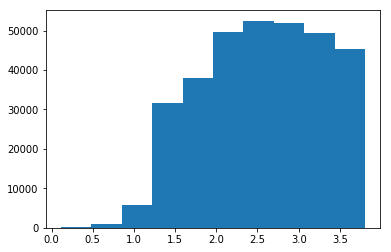

In [93]:
plt.figure()
plt.hist(hist_entropy)

In [99]:
new_merchant_monthly_perchase_cnts.head()

,new_merchant_per_cnts_month_lag1,new_merchant_per_cnts_month_lag2
card_id,,
C_ID_00007093c1,0.0,2.0
C_ID_0001238066,17.0,9.0
C_ID_0001506ef0,2.0,0.0
C_ID_0001793786,21.0,10.0
C_ID_000183fdda,8.0,3.0


In [96]:
# let's do same for new merchant perchase
sum_purchases=new_merchant_monthly_perchase_cnts.sum(axis=1)
new_merchant_monthly_perchase_cnts_prob=new_merchant_monthly_perchase_cnts.div(sum_purchases,axis=0)
new_merchant_monthly_perchase_cnts_prob_log=np.log2(new_merchant_monthly_perchase_cnts_prob)
new_merchant_monthly_perchase_cnts_prob_log.replace([-np.inf],0,inplace=True)
# new_merchant_monthly_perchase_cnts_prob_log_prob=new_merchant_monthly_perchase_perchase_cnts_prob_log*new_merchant_monthly_perchase_cnts_prob_log
# new_merchant_entropy=-new_merchant_monthly_perchase_cnts_prob_log_prob.sum(axis=1)

In [97]:
new_merchant_monthly_perchase_cnts_prob_log_prob=new_merchant_monthly_perchase_cnts_prob_log*new_merchant_monthly_perchase_cnts_prob
new_merchant_entropy=-new_merchant_monthly_perchase_cnts_prob_log_prob.sum(axis=1)

(array([9.96390e+04, 1.10000e+01, 2.22000e+02, 9.87000e+02, 2.22700e+03,
        7.60400e+03, 8.24100e+03, 1.49150e+04, 3.24230e+04, 1.23732e+05]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

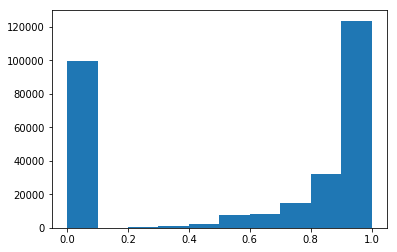

In [98]:
plt.figure()
plt.hist(new_merchant_entropy)

In [104]:
df_train['hist_entropy'] = df_train.card_id.map(hist_entropy)
df_test['hist_entropy'] = df_test.card_id.map(hist_entropy)
df_train['new_merchant_entropy'] = df_train.card_id.map(new_merchant_entropy)
df_test['new_merchant_entropy'] = df_test.card_id.map(new_merchant_entropy)

In [110]:
df_train_columns2=df_train_columns[:]
df_train_columns2=df_train_columns2+['hist_entropy','new_merchant_entropy']

In [111]:
len(df_train_columns2),len(df_train_columns)

(267, 265)

In [112]:
trn_data = lgb.Dataset(df_train[df_train_columns2], label=target)#, categorical_feature=categorical_feats)

In [113]:
lgb_cv = lgb.cv(param, trn_data, 10000, stratified=False, early_stopping_rounds=600, verbose_eval=200)
print(f'best cv score: {lgb_cv["rmse-mean"][-1]}\nbest boost nums: {len(lgb_cv["rmse-mean"])}')

[200]	cv_agg's rmse: 3.6809 + 0.0289862
[400]	cv_agg's rmse: 3.66059 + 0.0278944
[600]	cv_agg's rmse: 3.65336 + 0.0274063
[800]	cv_agg's rmse: 3.65086 + 0.0271351
[1000]	cv_agg's rmse: 3.64987 + 0.0267068
[1200]	cv_agg's rmse: 3.64953 + 0.0267174
[1400]	cv_agg's rmse: 3.64982 + 0.0261579
[1600]	cv_agg's rmse: 3.64976 + 0.025924
best cv score: 3.6494249101110214
best boost nums: 1161


lgb.cv show's that num_boost_round is around 2000, so we train a model with num_boost_round=2000

In [125]:
clf = lgb.train(param, trn_data, 1650, valid_sets=(trn_data), verbose_eval=200)

[200]	training's rmse: 3.57259
[400]	training's rmse: 3.48514
[600]	training's rmse: 3.42812
[800]	training's rmse: 3.38474
[1000]	training's rmse: 3.34848
[1200]	training's rmse: 3.31626
[1400]	training's rmse: 3.2838
[1600]	training's rmse: 3.25427


In [126]:
feature_importance_updated=pd.DataFrame({'feature':clf.feature_name(),'importance':clf.feature_importance()})

In [128]:
feature_importance_updated[feature_importance_updated.feature.isin(['hist_entropy','new_merchant_entropy'])]

,feature,importance
265,hist_entropy,669
266,new_merchant_entropy,29


In [131]:
feature_importance_updated.sort_values('importance',ascending=False).head(10)

,feature,importance
63,auth_hist_month_diff_mean,1353
197,new_hist_purchase_date_uptonow,1153
117,hist_month_diff_mean,1112
153,new_hist_purchase_amount_max,1023
56,auth_hist_purchase_date_max,918
164,new_hist_purchase_date_max,744
265,hist_entropy,669
34,auth_hist_month_nunique,602
57,auth_hist_purchase_date_min,539
155,new_hist_purchase_amount_mean,524


In [135]:
#LB:3.676
y_pred = clf.predict(df_test[df_train_columns2], num_iteration=clf.best_iteration)
single_pd = pd.DataFrame({
        'card_id': df_test.card_id,
        'target': y_pred
})
single_pd.to_csv('../wang_newest_with_purchase_journeys_updated2.csv', index=False)


In [136]:
clf = lgb.train(param, trn_data, 1200, valid_sets=(trn_data), verbose_eval=200)

[200]	training's rmse: 3.57259
[400]	training's rmse: 3.48514
[600]	training's rmse: 3.42812
[800]	training's rmse: 3.38474
[1000]	training's rmse: 3.34848
[1200]	training's rmse: 3.31626


In [137]:
feature_importance_updated3=pd.DataFrame({'feature':clf.feature_name(),'importance':clf.feature_importance()})

In [138]:
feature_importance_updated3.sort_values('importance',ascending=False).head(20)

,feature,importance
63,auth_hist_month_diff_mean,922
197,new_hist_purchase_date_uptonow,883
153,new_hist_purchase_amount_max,861
117,hist_month_diff_mean,736
56,auth_hist_purchase_date_max,646
164,new_hist_purchase_date_max,545
34,auth_hist_month_nunique,505
265,hist_entropy,481
155,new_hist_purchase_amount_mean,423
14,hist_per_cnts_month_lag0,413


In [139]:
#LB:3.676
y_pred = clf.predict(df_test[df_train_columns2], num_iteration=clf.best_iteration)
single_pd = pd.DataFrame({
        'card_id': df_test.card_id,
        'target': y_pred
})
single_pd.to_csv('../wang_newest_with_purchase_journeys_updated3.csv', index=False)

In [142]:
list_features=feature_importance.feature.tolist()

In [149]:
df_train.hist_entropy.describe()

count    201917.000000
mean          2.563527
std           0.716934
min           0.111910
25%           1.987021
50%           2.579946
75%           3.168374
max           3.807355
Name: hist_entropy, dtype: float64

In [155]:
df_train.hist_entropy.mean()

2.563527458080427

In [158]:
mean=df_train.hist_entropy.mean()
std=df_train.hist_entropy.std()
noise=np.random.normal(loc=mean/100,scale=std/100,size=df_train.shape[0])

In [159]:
df_train2=df_train.copy()
df_train2.loc[:,'hist_entropy']=df_train.loc[:,'hist_entropy']+noise

In [160]:
trn_data = lgb.Dataset(df_train2[df_train_columns2], label=target)#, categorical_feature=categorical_feats)

In [161]:
lgb_cv = lgb.cv(param, trn_data, 10000, stratified=False, early_stopping_rounds=600, verbose_eval=200)
print(f'best cv score: {lgb_cv["rmse-mean"][-1]}\nbest boost nums: {len(lgb_cv["rmse-mean"])}')

[200]	cv_agg's rmse: 3.68072 + 0.0288572
[400]	cv_agg's rmse: 3.66021 + 0.0283242
[600]	cv_agg's rmse: 3.65296 + 0.0274929
[800]	cv_agg's rmse: 3.65012 + 0.0271477
[1000]	cv_agg's rmse: 3.64904 + 0.0267301
[1200]	cv_agg's rmse: 3.64864 + 0.0264761
[1400]	cv_agg's rmse: 3.64865 + 0.0262347
[1600]	cv_agg's rmse: 3.64857 + 0.0257793
[1800]	cv_agg's rmse: 3.64905 + 0.0254578
[2000]	cv_agg's rmse: 3.64933 + 0.0253847
best cv score: 3.6484795957811684
best boost nums: 1485


In [166]:
from sklearn.model_selection import train_test_split

In [198]:
train,test=train_test_split(df_train2,test_size=0.2,stratify=df_train2.outliers)

In [197]:
?train_test_split

In [199]:
train.outliers.mean(),test.outliers.mean()

(0.010932750583472107, 0.010920166402535658)

In [200]:
trn_data = lgb.Dataset(train[df_train_columns2], label=train.target)#, categorical_feature=categorical_feats)
vld_data=lgb.Dataset(test[df_train_columns2], label=test.target)#, categorical_feature=categorical_feats)

In [226]:
clf = lgb.train(param, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55232	valid_1's rmse: 3.67583
[400]	training's rmse: 3.45505	valid_1's rmse: 3.65687
[600]	training's rmse: 3.39345	valid_1's rmse: 3.6498
[800]	training's rmse: 3.34508	valid_1's rmse: 3.64714
[1000]	training's rmse: 3.30225	valid_1's rmse: 3.64603
[1200]	training's rmse: 3.26287	valid_1's rmse: 3.64642
[1400]	training's rmse: 3.22744	valid_1's rmse: 3.64578
[1600]	training's rmse: 3.19426	valid_1's rmse: 3.64569
[1800]	training's rmse: 3.16129	valid_1's rmse: 3.64565
[2000]	training's rmse: 3.13215	valid_1's rmse: 3.64603
Early stopping, best iteration is:
[1649]	training's rmse: 3.18555	valid_1's rmse: 3.64544


In [233]:
param2=param.copy()
param['num_leaves']

31

In [228]:
param2['num_leaves']=20

In [229]:
clf = lgb.train(param2, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.60468	valid_1's rmse: 3.68099
[400]	training's rmse: 3.53015	valid_1's rmse: 3.66285
[600]	training's rmse: 3.48438	valid_1's rmse: 3.655
[800]	training's rmse: 3.44925	valid_1's rmse: 3.65194
[1000]	training's rmse: 3.41781	valid_1's rmse: 3.6496
[1200]	training's rmse: 3.38995	valid_1's rmse: 3.64878
[1400]	training's rmse: 3.36301	valid_1's rmse: 3.64806
[1600]	training's rmse: 3.33836	valid_1's rmse: 3.64808
[1800]	training's rmse: 3.31497	valid_1's rmse: 3.64796
[2000]	training's rmse: 3.29289	valid_1's rmse: 3.6481
Early stopping, best iteration is:
[1660]	training's rmse: 3.33113	valid_1's rmse: 3.64778


In [230]:
param2['num_leaves']=25
clf = lgb.train(param2, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.57941	valid_1's rmse: 3.67926
[400]	training's rmse: 3.49429	valid_1's rmse: 3.66171
[600]	training's rmse: 3.43979	valid_1's rmse: 3.65349
[800]	training's rmse: 3.39932	valid_1's rmse: 3.65004
[1000]	training's rmse: 3.3635	valid_1's rmse: 3.64867
[1200]	training's rmse: 3.33016	valid_1's rmse: 3.64871
[1400]	training's rmse: 3.29832	valid_1's rmse: 3.64813
Early stopping, best iteration is:
[1069]	training's rmse: 3.35216	valid_1's rmse: 3.64805


In [234]:
param2['num_leaves']=31
param2['lambda_l2']=1
clf = lgb.train(param2, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55508	valid_1's rmse: 3.67595
[400]	training's rmse: 3.45851	valid_1's rmse: 3.65691
[600]	training's rmse: 3.39678	valid_1's rmse: 3.65028
[800]	training's rmse: 3.34831	valid_1's rmse: 3.64723
[1000]	training's rmse: 3.30676	valid_1's rmse: 3.64596
[1200]	training's rmse: 3.26896	valid_1's rmse: 3.6462
[1400]	training's rmse: 3.23276	valid_1's rmse: 3.64558
[1600]	training's rmse: 3.20004	valid_1's rmse: 3.64518
[1800]	training's rmse: 3.16688	valid_1's rmse: 3.64576
[2000]	training's rmse: 3.13763	valid_1's rmse: 3.64577
Early stopping, best iteration is:
[1634]	training's rmse: 3.19451	valid_1's rmse: 3.64496


In [235]:
param2['max_bin']=100
clf = lgb.train(param2, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55508	valid_1's rmse: 3.67595
[400]	training's rmse: 3.45851	valid_1's rmse: 3.65691
[600]	training's rmse: 3.39678	valid_1's rmse: 3.65028
[800]	training's rmse: 3.34831	valid_1's rmse: 3.64723
[1000]	training's rmse: 3.30676	valid_1's rmse: 3.64596
[1200]	training's rmse: 3.26896	valid_1's rmse: 3.6462
[1400]	training's rmse: 3.23276	valid_1's rmse: 3.64558
[1600]	training's rmse: 3.20004	valid_1's rmse: 3.64518
[1800]	training's rmse: 3.16688	valid_1's rmse: 3.64576
[2000]	training's rmse: 3.13763	valid_1's rmse: 3.64577
Early stopping, best iteration is:
[1634]	training's rmse: 3.19451	valid_1's rmse: 3.64496


In [236]:
param2['max_bin']=50
clf = lgb.train(param2, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55508	valid_1's rmse: 3.67595
[400]	training's rmse: 3.45851	valid_1's rmse: 3.65691
[600]	training's rmse: 3.39678	valid_1's rmse: 3.65028
[800]	training's rmse: 3.34831	valid_1's rmse: 3.64723
[1000]	training's rmse: 3.30676	valid_1's rmse: 3.64596
[1200]	training's rmse: 3.26896	valid_1's rmse: 3.6462
[1400]	training's rmse: 3.23276	valid_1's rmse: 3.64558
[1600]	training's rmse: 3.20004	valid_1's rmse: 3.64518
[1800]	training's rmse: 3.16688	valid_1's rmse: 3.64576
[2000]	training's rmse: 3.13763	valid_1's rmse: 3.64577
Early stopping, best iteration is:
[1634]	training's rmse: 3.19451	valid_1's rmse: 3.64496


In [238]:
param2['max_bin']=2
clf = lgb.train(param2, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55508	valid_1's rmse: 3.67595
[400]	training's rmse: 3.45851	valid_1's rmse: 3.65691
[600]	training's rmse: 3.39678	valid_1's rmse: 3.65028
[800]	training's rmse: 3.34831	valid_1's rmse: 3.64723
[1000]	training's rmse: 3.30676	valid_1's rmse: 3.64596
[1200]	training's rmse: 3.26896	valid_1's rmse: 3.6462
[1400]	training's rmse: 3.23276	valid_1's rmse: 3.64558
[1600]	training's rmse: 3.20004	valid_1's rmse: 3.64518
[1800]	training's rmse: 3.16688	valid_1's rmse: 3.64576
[2000]	training's rmse: 3.13763	valid_1's rmse: 3.64577
Early stopping, best iteration is:
[1634]	training's rmse: 3.19451	valid_1's rmse: 3.64496


In [242]:
param2['max_bin']=2
clf = lgb.train(param2, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55508	valid_1's rmse: 3.67595
[400]	training's rmse: 3.45851	valid_1's rmse: 3.65691
[600]	training's rmse: 3.39678	valid_1's rmse: 3.65028
[800]	training's rmse: 3.34831	valid_1's rmse: 3.64723
[1000]	training's rmse: 3.30676	valid_1's rmse: 3.64596
[1200]	training's rmse: 3.26896	valid_1's rmse: 3.6462
[1400]	training's rmse: 3.23276	valid_1's rmse: 3.64558
[1600]	training's rmse: 3.20004	valid_1's rmse: 3.64518
[1800]	training's rmse: 3.16688	valid_1's rmse: 3.64576
[2000]	training's rmse: 3.13763	valid_1's rmse: 3.64577
Early stopping, best iteration is:
[1634]	training's rmse: 3.19451	valid_1's rmse: 3.64496


In [245]:
param2['num_leaves']=31
param2['lambda_l2']=2
clf = lgb.train(param2, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55767	valid_1's rmse: 3.67664
[400]	training's rmse: 3.4615	valid_1's rmse: 3.65753
[600]	training's rmse: 3.3995	valid_1's rmse: 3.65025
[800]	training's rmse: 3.35171	valid_1's rmse: 3.64798
[1000]	training's rmse: 3.31032	valid_1's rmse: 3.64695
[1200]	training's rmse: 3.27144	valid_1's rmse: 3.64653
[1400]	training's rmse: 3.23535	valid_1's rmse: 3.64654
Early stopping, best iteration is:
[1084]	training's rmse: 3.29363	valid_1's rmse: 3.64628


In [248]:
param2['num_leaves']=31
param2['lambda_l2']=1
param2['min_data_in_leaf']=60
clf = lgb.train(param2, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.56891	valid_1's rmse: 3.6755
[400]	training's rmse: 3.48391	valid_1's rmse: 3.65789
[600]	training's rmse: 3.43081	valid_1's rmse: 3.6509
[800]	training's rmse: 3.38845	valid_1's rmse: 3.64819
[1000]	training's rmse: 3.35096	valid_1's rmse: 3.64701
[1200]	training's rmse: 3.31709	valid_1's rmse: 3.64725
[1400]	training's rmse: 3.28576	valid_1's rmse: 3.64711
Early stopping, best iteration is:
[1033]	training's rmse: 3.34537	valid_1's rmse: 3.64682


In [249]:
param2['num_leaves']=31
param2['lambda_l2']=1
param2['min_data_in_leaf']=45
clf = lgb.train(param2, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.56223	valid_1's rmse: 3.67519
[400]	training's rmse: 3.47231	valid_1's rmse: 3.65648
[600]	training's rmse: 3.41464	valid_1's rmse: 3.64938
[800]	training's rmse: 3.36993	valid_1's rmse: 3.64619
[1000]	training's rmse: 3.33102	valid_1's rmse: 3.64512
[1200]	training's rmse: 3.29488	valid_1's rmse: 3.64548
[1400]	training's rmse: 3.26144	valid_1's rmse: 3.64512
Early stopping, best iteration is:
[1027]	training's rmse: 3.32621	valid_1's rmse: 3.64469


In [250]:
param2['num_leaves']=31
param2['lambda_l2']=1
param2['min_data_in_leaf']=52
clf = lgb.train(param2, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.56514	valid_1's rmse: 3.67544
[400]	training's rmse: 3.47734	valid_1's rmse: 3.65735
[600]	training's rmse: 3.42285	valid_1's rmse: 3.6499
[800]	training's rmse: 3.37919	valid_1's rmse: 3.64744
[1000]	training's rmse: 3.34044	valid_1's rmse: 3.64673
[1200]	training's rmse: 3.30494	valid_1's rmse: 3.64702
[1400]	training's rmse: 3.27248	valid_1's rmse: 3.64645
Early stopping, best iteration is:
[1027]	training's rmse: 3.33571	valid_1's rmse: 3.64629


In [251]:
param2['num_leaves']=31
param2['lambda_l2']=1
param2['min_data_in_leaf']=48
clf = lgb.train(param2, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.56358	valid_1's rmse: 3.6763
[400]	training's rmse: 3.47505	valid_1's rmse: 3.65829
[600]	training's rmse: 3.41899	valid_1's rmse: 3.65169
[800]	training's rmse: 3.3758	valid_1's rmse: 3.649
[1000]	training's rmse: 3.33638	valid_1's rmse: 3.64828
[1200]	training's rmse: 3.30076	valid_1's rmse: 3.64872
[1400]	training's rmse: 3.2677	valid_1's rmse: 3.64881
Early stopping, best iteration is:
[1077]	training's rmse: 3.32303	valid_1's rmse: 3.64796


# Now, let's check with original Wang's results

In [200]:
trn_data = lgb.Dataset(train[df_train_columns], label=train.target)#, categorical_feature=categorical_feats)
vld_data=lgb.Dataset(test[df_train_columns], label=test.target)#, categorical_feature=categorical_feats)

In [253]:
param3=param.copy()
param3['lambda_l2']=1
param3['min_data_in_leaf']=45


In [254]:
clf = lgb.train(param3, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.56223	valid_1's rmse: 3.67519
[400]	training's rmse: 3.47231	valid_1's rmse: 3.65648
[600]	training's rmse: 3.41464	valid_1's rmse: 3.64938
[800]	training's rmse: 3.36993	valid_1's rmse: 3.64619
[1000]	training's rmse: 3.33102	valid_1's rmse: 3.64512
[1200]	training's rmse: 3.29488	valid_1's rmse: 3.64548
[1400]	training's rmse: 3.26144	valid_1's rmse: 3.64512
Early stopping, best iteration is:
[1027]	training's rmse: 3.32621	valid_1's rmse: 3.64469


Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55232	valid_1's rmse: 3.67583
[400]	training's rmse: 3.45505	valid_1's rmse: 3.65687
[600]	training's rmse: 3.39345	valid_1's rmse: 3.6498
[800]	training's rmse: 3.34508	valid_1's rmse: 3.64714
[1000]	training's rmse: 3.30225	valid_1's rmse: 3.64603
[1200]	training's rmse: 3.26287	valid_1's rmse: 3.64642
[1400]	training's rmse: 3.22744	valid_1's rmse: 3.64578
[1600]	training's rmse: 3.19426	valid_1's rmse: 3.64569
[1800]	training's rmse: 3.16129	valid_1's rmse: 3.64565
[2000]	training's rmse: 3.13215	valid_1's rmse: 3.64603
Early stopping, best iteration is:
[1649]	training's rmse: 3.18555	valid_1's rmse: 3.64544

In [256]:
param3['bagging_fraction']=0.5
clf = lgb.train(param3, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.57711	valid_1's rmse: 3.67783
[400]	training's rmse: 3.49718	valid_1's rmse: 3.65887
[600]	training's rmse: 3.44452	valid_1's rmse: 3.65373
[800]	training's rmse: 3.40109	valid_1's rmse: 3.65138
[1000]	training's rmse: 3.35845	valid_1's rmse: 3.65088
[1200]	training's rmse: 3.31977	valid_1's rmse: 3.65141
[1400]	training's rmse: 3.28325	valid_1's rmse: 3.65158
[1600]	training's rmse: 3.25005	valid_1's rmse: 3.65244
Early stopping, best iteration is:
[1253]	training's rmse: 3.30957	valid_1's rmse: 3.65064


In [258]:
param3['bagging_fraction']=0.8
clf = lgb.train(param3, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.5636	valid_1's rmse: 3.67661
[400]	training's rmse: 3.47699	valid_1's rmse: 3.65678
[600]	training's rmse: 3.42096	valid_1's rmse: 3.64939
[800]	training's rmse: 3.3753	valid_1's rmse: 3.64669
[1000]	training's rmse: 3.33443	valid_1's rmse: 3.64552
[1200]	training's rmse: 3.29612	valid_1's rmse: 3.64485
[1400]	training's rmse: 3.26099	valid_1's rmse: 3.64463
[1600]	training's rmse: 3.22866	valid_1's rmse: 3.64505
Early stopping, best iteration is:
[1357]	training's rmse: 3.26845	valid_1's rmse: 3.64429


In [257]:
param3['bagging_fraction']=
clf = lgb.train(param3, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.56777	valid_1's rmse: 3.67694
[400]	training's rmse: 3.48111	valid_1's rmse: 3.65995
[600]	training's rmse: 3.42578	valid_1's rmse: 3.65344
[800]	training's rmse: 3.38065	valid_1's rmse: 3.65155
[1000]	training's rmse: 3.33919	valid_1's rmse: 3.65104
[1200]	training's rmse: 3.30063	valid_1's rmse: 3.65074
[1400]	training's rmse: 3.26497	valid_1's rmse: 3.65091
[1600]	training's rmse: 3.23201	valid_1's rmse: 3.65109
Early stopping, best iteration is:
[1254]	training's rmse: 3.29122	valid_1's rmse: 3.65048


In [263]:
param4=param.copy()
param4['min_data_in_leaf']=45
param4['lambda_l2']=1
for i in range(2,8):
    if i ==2:
        param4['max_depth']=-1
    else:
        param4['max_depth']=i
    print('Results for max_depth='+str(param4['max_depth']))
    clf = lgb.train(param4, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)  



Results for max_depth=-1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.56223	valid_1's rmse: 3.67519
[400]	training's rmse: 3.47231	valid_1's rmse: 3.65648
[600]	training's rmse: 3.41464	valid_1's rmse: 3.64938
[800]	training's rmse: 3.36993	valid_1's rmse: 3.64619
[1000]	training's rmse: 3.33102	valid_1's rmse: 3.64512
[1200]	training's rmse: 3.29488	valid_1's rmse: 3.64548
[1400]	training's rmse: 3.26144	valid_1's rmse: 3.64512
Early stopping, best iteration is:
[1027]	training's rmse: 3.32621	valid_1's rmse: 3.64469
Results for max_depth=3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.70603	valid_1's rmse: 3.70938
[400]	training's rmse: 3.67558	valid_1's rmse: 3.68681
[600]	training's rmse: 3.66006	valid_1's rmse: 3.67821
[800]	training's rmse: 3.64918	valid_1's rmse: 3.6726
[1000]	training's rmse: 3.64006	valid_1's rmse: 3.66889
[1200]	training's rmse: 3.63211	valid_1's rmse: 3.66623
[1400]	training

In [264]:
param4=param.copy()
param4['min_data_in_leaf']=45
param4['lambda_l2']=1
for i in range(8,12):
    if i ==2:
        param4['max_depth']=-1
    else:
        param4['max_depth']=i
    print('Results for max_depth='+str(param4['max_depth']))
    clf = lgb.train(param4, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)  



Results for max_depth=8
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.5792	valid_1's rmse: 3.67167
[400]	training's rmse: 3.5078	valid_1's rmse: 3.65355
[600]	training's rmse: 3.46215	valid_1's rmse: 3.64799
[800]	training's rmse: 3.42278	valid_1's rmse: 3.64613
[1000]	training's rmse: 3.38747	valid_1's rmse: 3.64561
[1200]	training's rmse: 3.35455	valid_1's rmse: 3.64633
[1400]	training's rmse: 3.32394	valid_1's rmse: 3.64636
Early stopping, best iteration is:
[1021]	training's rmse: 3.38404	valid_1's rmse: 3.64546
Results for max_depth=9
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.57251	valid_1's rmse: 3.67383
[400]	training's rmse: 3.49686	valid_1's rmse: 3.65652
[600]	training's rmse: 3.44752	valid_1's rmse: 3.65082
[800]	training's rmse: 3.40554	valid_1's rmse: 3.64847
[1000]	training's rmse: 3.36892	valid_1's rmse: 3.64843
[1200]	training's rmse: 3.33475	valid_1's rmse: 3.64846
[1400]	training's

In [265]:
param4=param.copy()
param4['min_data_in_leaf']=45
param4['lambda_l2']=1
for i in range(12,17):
    if i ==2:
        param4['max_depth']=-1
    else:
        param4['max_depth']=i
    print('Results for max_depth='+str(param4['max_depth']))
    clf = lgb.train(param4, trn_data, 2500, valid_sets=(trn_data,vld_data), verbose_eval=200,early_stopping_rounds=400)  



Results for max_depth=12
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.56322	valid_1's rmse: 3.67487
[400]	training's rmse: 3.47597	valid_1's rmse: 3.65564
[600]	training's rmse: 3.42143	valid_1's rmse: 3.64878
[800]	training's rmse: 3.37832	valid_1's rmse: 3.64596
[1000]	training's rmse: 3.34055	valid_1's rmse: 3.64487
[1200]	training's rmse: 3.30479	valid_1's rmse: 3.64542
[1400]	training's rmse: 3.27211	valid_1's rmse: 3.64545
Early stopping, best iteration is:
[1075]	training's rmse: 3.32756	valid_1's rmse: 3.6445
Results for max_depth=13
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.56274	valid_1's rmse: 3.67622
[400]	training's rmse: 3.47552	valid_1's rmse: 3.65703
[600]	training's rmse: 3.41915	valid_1's rmse: 3.64935
[800]	training's rmse: 3.37503	valid_1's rmse: 3.64642
[1000]	training's rmse: 3.33717	valid_1's rmse: 3.64509
[1200]	training's rmse: 3.30079	valid_1's rmse: 3.64582
[1400]	trainin

In [316]:
from bayes_opt import BayesianOptimization
import gc
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    else:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [325]:
def lgb_cv(num_leaves, min_data_in_leaf, bagging_fraction, feature_fraction, lambda_l1,lambda_l2,max_depth, data, target):
    folds = KFold(n_splits=5, shuffle=True, random_state=11)
    oof = np.zeros(data.shape[0])
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(data, target)):
        print(f'fold: {fold_}')
        trn_data = lgb.Dataset(data[trn_idx], label=target[trn_idx])
        val_data = lgb.Dataset(data[val_idx], label=target[val_idx])
        param = {
            # general parameters
            'objective': 'regression',
            'boosting': 'gbdt',
            'metric': 'rmse',
            'learning_rate': 0.01,
            # tuning parameters
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf),
            'bagging_freq': 1,
            'bagging_fraction': bagging_fraction,
            'feature_fraction': feature_fraction,
            'lambda_l1': lambda_l1,
            'lambda_l2': lambda_l2,
            'max_depth': int(max_depth)
        }
        clf = lgb.train(param, trn_data, 10000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400)
        oof[val_idx] = clf.predict(data[val_idx], num_iteration=clf.best_iteration)
        del clf, trn_idx, val_idx
        gc.collect()
    return -mean_squared_error(target, oof)**0.5

In [326]:
def optimize_lgb(data, target):
    def lgb_crossval(num_leaves, min_data_in_leaf, bagging_fraction, feature_fraction, lambda_l1,lambda_l2,max_depth):
        return lgb_cv(num_leaves, min_data_in_leaf, bagging_fraction, feature_fraction, lambda_l1,lambda_l2,max_depth, data, target )
    
    optimizer = BayesianOptimization(lgb_crossval, {
        'num_leaves': (40, 60),
        'min_data_in_leaf': (30, 60),
        'bagging_fraction': (0.5, 1.0),
        'feature_fraction': (0.5, 1.0),
        'lambda_l1': (0, 10),
        'lambda_l2':(0,10),
        'max_depth':(2,20)
    })

    start_time = timer()
    optimizer.maximize(init_points=10, n_iter=100, acq='ucb', kappa=10)
    timer(start_time)
    print("Final result:", optimizer.max)

In [327]:

train = df_train[df_train_columns].values
target = df_train.target
#train = reduce_mem_usage(train)
optimize_lgb(train, target)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------
fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.5701	valid_1's rmse: 3.71779
[400]	training's rmse: 3.50078	valid_1's rmse: 3.69684
[600]	training's rmse: 3.45529	valid_1's rmse: 3.6946
[800]	training's rmse: 3.41608	valid_1's rmse: 3.69368
[1000]	training's rmse: 3.3784	valid_1's rmse: 3.69481
[1200]	training's rmse: 3.34281	valid_1's rmse: 3.6948
Early stopping, best iteration is:
[827]	training's rmse: 3.41091	valid_1's rmse: 3.69341
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.58761	valid_1's rmse: 3.64965
[400]	training's rmse: 3.51653	valid_1's rmse: 3.63335
[600]	training's rmse: 3.47142	valid_1's rmse: 3.62835
[800]	training's rmse: 3.43189	valid_1's rmse: 3.62597


[1200]	training's rmse: 3.39015	valid_1's rmse: 3.63848
[1400]	training's rmse: 3.36113	valid_1's rmse: 3.63926
Early stopping, best iteration is:
[1012]	training's rmse: 3.41887	valid_1's rmse: 3.63782
fold: 4
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.61043	valid_1's rmse: 3.62441
[400]	training's rmse: 3.54407	valid_1's rmse: 3.608
[600]	training's rmse: 3.50223	valid_1's rmse: 3.60233
[800]	training's rmse: 3.46437	valid_1's rmse: 3.5993
[1000]	training's rmse: 3.42993	valid_1's rmse: 3.59932
[1200]	training's rmse: 3.39882	valid_1's rmse: 3.59826
[1400]	training's rmse: 3.36725	valid_1's rmse: 3.59811
[1600]	training's rmse: 3.33656	valid_1's rmse: 3.59779
Early stopping, best iteration is:
[1294]	training's rmse: 3.38379	valid_1's rmse: 3.59748
|  3        | -3.642    |  0.6829   |  0.7743   |  3.306    |  9.814    |  6.235    |  34.28    |  50.33    |
fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	trainin

fold: 2
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.54624	valid_1's rmse: 3.69133
[400]	training's rmse: 3.46201	valid_1's rmse: 3.66946
[600]	training's rmse: 3.40479	valid_1's rmse: 3.66302
[800]	training's rmse: 3.3564	valid_1's rmse: 3.66034
[1000]	training's rmse: 3.3141	valid_1's rmse: 3.65962
[1200]	training's rmse: 3.27506	valid_1's rmse: 3.65906
[1400]	training's rmse: 3.23608	valid_1's rmse: 3.65851
[1600]	training's rmse: 3.20214	valid_1's rmse: 3.65956
Early stopping, best iteration is:
[1390]	training's rmse: 3.2381	valid_1's rmse: 3.65832
fold: 3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.54806	valid_1's rmse: 3.65816
[400]	training's rmse: 3.46032	valid_1's rmse: 3.6469
[600]	training's rmse: 3.40366	valid_1's rmse: 3.64457
[800]	training's rmse: 3.3579	valid_1's rmse: 3.64383
[1000]	training's rmse: 3.3146	valid_1's rmse: 3.64376
[1200]	training's rmse: 3.27495	valid_1's rmse: 3.644

[200]	training's rmse: 3.51398	valid_1's rmse: 3.65572
[400]	training's rmse: 3.39466	valid_1's rmse: 3.6365
[600]	training's rmse: 3.31528	valid_1's rmse: 3.63144
[800]	training's rmse: 3.24648	valid_1's rmse: 3.62868
[1000]	training's rmse: 3.18415	valid_1's rmse: 3.62793
[1200]	training's rmse: 3.12555	valid_1's rmse: 3.62816
[1400]	training's rmse: 3.07048	valid_1's rmse: 3.62887
Early stopping, best iteration is:
[1012]	training's rmse: 3.18018	valid_1's rmse: 3.62758
fold: 2
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.50293	valid_1's rmse: 3.69924
[400]	training's rmse: 3.38555	valid_1's rmse: 3.67541
[600]	training's rmse: 3.30529	valid_1's rmse: 3.66929
[800]	training's rmse: 3.23863	valid_1's rmse: 3.66599
[1000]	training's rmse: 3.17733	valid_1's rmse: 3.66508
[1200]	training's rmse: 3.12083	valid_1's rmse: 3.66446
[1400]	training's rmse: 3.06566	valid_1's rmse: 3.6646
[1600]	training's rmse: 3.01409	valid_1's rmse: 3.66492
Early st

[1400]	training's rmse: 3.68546	valid_1's rmse: 3.67584
[1600]	training's rmse: 3.68166	valid_1's rmse: 3.67407
[1800]	training's rmse: 3.67811	valid_1's rmse: 3.67255
[2000]	training's rmse: 3.6747	valid_1's rmse: 3.67116
[2200]	training's rmse: 3.67165	valid_1's rmse: 3.67016
[2400]	training's rmse: 3.66861	valid_1's rmse: 3.66902
[2600]	training's rmse: 3.66578	valid_1's rmse: 3.66817
[2800]	training's rmse: 3.66293	valid_1's rmse: 3.66708
[3000]	training's rmse: 3.66042	valid_1's rmse: 3.66651
[3200]	training's rmse: 3.65792	valid_1's rmse: 3.66594
[3400]	training's rmse: 3.65539	valid_1's rmse: 3.66541
[3600]	training's rmse: 3.65299	valid_1's rmse: 3.6647
[3800]	training's rmse: 3.65068	valid_1's rmse: 3.66424
[4000]	training's rmse: 3.64844	valid_1's rmse: 3.66367
[4200]	training's rmse: 3.64624	valid_1's rmse: 3.66327
[4400]	training's rmse: 3.6442	valid_1's rmse: 3.66299
[4600]	training's rmse: 3.6422	valid_1's rmse: 3.66275
[4800]	training's rmse: 3.64013	valid_1's rmse: 3.66

[5400]	training's rmse: 3.64249	valid_1's rmse: 3.63029
[5600]	training's rmse: 3.64072	valid_1's rmse: 3.62982
[5800]	training's rmse: 3.63901	valid_1's rmse: 3.62944
[6000]	training's rmse: 3.63723	valid_1's rmse: 3.62902
[6200]	training's rmse: 3.63557	valid_1's rmse: 3.62867
[6400]	training's rmse: 3.63398	valid_1's rmse: 3.62849
[6600]	training's rmse: 3.63231	valid_1's rmse: 3.62832
[6800]	training's rmse: 3.63066	valid_1's rmse: 3.62818
[7000]	training's rmse: 3.629	valid_1's rmse: 3.62812
[7200]	training's rmse: 3.62738	valid_1's rmse: 3.62782
[7400]	training's rmse: 3.62579	valid_1's rmse: 3.62769
[7600]	training's rmse: 3.62423	valid_1's rmse: 3.62758
[7800]	training's rmse: 3.62278	valid_1's rmse: 3.62738
[8000]	training's rmse: 3.62133	valid_1's rmse: 3.62728
[8200]	training's rmse: 3.61994	valid_1's rmse: 3.62706
[8400]	training's rmse: 3.61843	valid_1's rmse: 3.62698
[8600]	training's rmse: 3.61689	valid_1's rmse: 3.62691
[8800]	training's rmse: 3.61547	valid_1's rmse: 3.

[1200]	training's rmse: 3.67307	valid_1's rmse: 3.75179
[1400]	training's rmse: 3.66855	valid_1's rmse: 3.74861
[1600]	training's rmse: 3.66469	valid_1's rmse: 3.74628
[1800]	training's rmse: 3.66093	valid_1's rmse: 3.74438
[2000]	training's rmse: 3.65756	valid_1's rmse: 3.74265
[2200]	training's rmse: 3.65455	valid_1's rmse: 3.74128
[2400]	training's rmse: 3.65158	valid_1's rmse: 3.74021
[2600]	training's rmse: 3.64855	valid_1's rmse: 3.73881
[2800]	training's rmse: 3.64587	valid_1's rmse: 3.73758
[3000]	training's rmse: 3.64342	valid_1's rmse: 3.73698
[3200]	training's rmse: 3.64079	valid_1's rmse: 3.73581
[3400]	training's rmse: 3.6384	valid_1's rmse: 3.73513
[3600]	training's rmse: 3.6361	valid_1's rmse: 3.73451
[3800]	training's rmse: 3.63395	valid_1's rmse: 3.73396
[4000]	training's rmse: 3.63173	valid_1's rmse: 3.73323
[4200]	training's rmse: 3.62968	valid_1's rmse: 3.73257
[4400]	training's rmse: 3.6277	valid_1's rmse: 3.73215
[4600]	training's rmse: 3.62581	valid_1's rmse: 3.7

[1800]	training's rmse: 3.67614	valid_1's rmse: 3.67449
[2000]	training's rmse: 3.67287	valid_1's rmse: 3.67365
[2200]	training's rmse: 3.66955	valid_1's rmse: 3.67282
[2400]	training's rmse: 3.66656	valid_1's rmse: 3.6719
[2600]	training's rmse: 3.66372	valid_1's rmse: 3.67114
[2800]	training's rmse: 3.6611	valid_1's rmse: 3.67056
[3000]	training's rmse: 3.65842	valid_1's rmse: 3.67001
[3200]	training's rmse: 3.65576	valid_1's rmse: 3.66955
[3400]	training's rmse: 3.65329	valid_1's rmse: 3.66899
[3600]	training's rmse: 3.65099	valid_1's rmse: 3.66856
[3800]	training's rmse: 3.64867	valid_1's rmse: 3.66842
[4000]	training's rmse: 3.64638	valid_1's rmse: 3.66799
[4200]	training's rmse: 3.64415	valid_1's rmse: 3.66767
[4400]	training's rmse: 3.64198	valid_1's rmse: 3.66733
[4600]	training's rmse: 3.64	valid_1's rmse: 3.66708
[4800]	training's rmse: 3.63798	valid_1's rmse: 3.66697
[5000]	training's rmse: 3.63597	valid_1's rmse: 3.6669
[5200]	training's rmse: 3.63404	valid_1's rmse: 3.6667

[2800]	training's rmse: 3.66396	valid_1's rmse: 3.66723
[3000]	training's rmse: 3.66145	valid_1's rmse: 3.66662
[3200]	training's rmse: 3.65923	valid_1's rmse: 3.66608
[3400]	training's rmse: 3.6569	valid_1's rmse: 3.6655
[3600]	training's rmse: 3.65471	valid_1's rmse: 3.66468
[3800]	training's rmse: 3.65266	valid_1's rmse: 3.66427
[4000]	training's rmse: 3.65047	valid_1's rmse: 3.66371
[4200]	training's rmse: 3.64841	valid_1's rmse: 3.66326
[4400]	training's rmse: 3.64648	valid_1's rmse: 3.66291
[4600]	training's rmse: 3.64465	valid_1's rmse: 3.66269
[4800]	training's rmse: 3.64279	valid_1's rmse: 3.66233
[5000]	training's rmse: 3.64083	valid_1's rmse: 3.66187
[5200]	training's rmse: 3.63894	valid_1's rmse: 3.66157
[5400]	training's rmse: 3.63721	valid_1's rmse: 3.66129
[5600]	training's rmse: 3.63553	valid_1's rmse: 3.66128
[5800]	training's rmse: 3.63372	valid_1's rmse: 3.66128
[6000]	training's rmse: 3.63185	valid_1's rmse: 3.661
[6200]	training's rmse: 3.63013	valid_1's rmse: 3.66

[3800]	training's rmse: 3.65985	valid_1's rmse: 3.63401
[4000]	training's rmse: 3.65784	valid_1's rmse: 3.63333
[4200]	training's rmse: 3.65596	valid_1's rmse: 3.63294
[4400]	training's rmse: 3.65396	valid_1's rmse: 3.63224
[4600]	training's rmse: 3.65202	valid_1's rmse: 3.63175
[4800]	training's rmse: 3.65006	valid_1's rmse: 3.63147
[5000]	training's rmse: 3.64838	valid_1's rmse: 3.6311
[5200]	training's rmse: 3.64661	valid_1's rmse: 3.63088
[5400]	training's rmse: 3.64492	valid_1's rmse: 3.6306
[5600]	training's rmse: 3.64327	valid_1's rmse: 3.63008
[5800]	training's rmse: 3.64166	valid_1's rmse: 3.62973
[6000]	training's rmse: 3.64004	valid_1's rmse: 3.62942
[6200]	training's rmse: 3.63848	valid_1's rmse: 3.62927
[6400]	training's rmse: 3.63684	valid_1's rmse: 3.62896
[6600]	training's rmse: 3.6352	valid_1's rmse: 3.62865
[6800]	training's rmse: 3.63367	valid_1's rmse: 3.62843
[7000]	training's rmse: 3.63208	valid_1's rmse: 3.62844
[7200]	training's rmse: 3.63064	valid_1's rmse: 3.6

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55385	valid_1's rmse: 3.72857
[400]	training's rmse: 3.46167	valid_1's rmse: 3.70357
[600]	training's rmse: 3.40374	valid_1's rmse: 3.69679
[800]	training's rmse: 3.35412	valid_1's rmse: 3.69457
[1000]	training's rmse: 3.31139	valid_1's rmse: 3.69366
[1200]	training's rmse: 3.27129	valid_1's rmse: 3.6938
[1400]	training's rmse: 3.23391	valid_1's rmse: 3.69351
[1600]	training's rmse: 3.19788	valid_1's rmse: 3.69391
Early stopping, best iteration is:
[1318]	training's rmse: 3.24931	valid_1's rmse: 3.69328
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.57164	valid_1's rmse: 3.6557
[400]	training's rmse: 3.47782	valid_1's rmse: 3.63579
[600]	training's rmse: 3.41727	valid_1's rmse: 3.62932
[800]	training's rmse: 3.36879	valid_1's rmse: 3.62724
[1000]	training's rmse: 3.32441	valid_1's rmse: 3.62511
[1200]	training's rmse: 3.28504	valid_1's rmse: 3

[1200]	training's rmse: 3.35926	valid_1's rmse: 3.64222
Early stopping, best iteration is:
[843]	training's rmse: 3.41627	valid_1's rmse: 3.64071
fold: 4
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.5927	valid_1's rmse: 3.62735
[400]	training's rmse: 3.52332	valid_1's rmse: 3.60993
[600]	training's rmse: 3.48058	valid_1's rmse: 3.60423
[800]	training's rmse: 3.44153	valid_1's rmse: 3.6015
[1000]	training's rmse: 3.40682	valid_1's rmse: 3.6006
[1200]	training's rmse: 3.37587	valid_1's rmse: 3.60051
[1400]	training's rmse: 3.34648	valid_1's rmse: 3.60113
Early stopping, best iteration is:
[1153]	training's rmse: 3.38303	valid_1's rmse: 3.60034
|  20       | -3.645    |  0.9916   |  0.9248   |  9.783    |  0.405    |  7.43     |  59.39    |  40.75    |
fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.53357	valid_1's rmse: 3.72498
[400]	training's rmse: 3.43767	valid_1's rmse: 3.70166
[600]	training's

[4200]	training's rmse: 3.54665	valid_1's rmse: 3.68557
[4400]	training's rmse: 3.54211	valid_1's rmse: 3.68547
[4600]	training's rmse: 3.53767	valid_1's rmse: 3.68542
[4800]	training's rmse: 3.53318	valid_1's rmse: 3.6854
[5000]	training's rmse: 3.529	valid_1's rmse: 3.68527
[5200]	training's rmse: 3.52491	valid_1's rmse: 3.68523
[5400]	training's rmse: 3.52099	valid_1's rmse: 3.68518
[5600]	training's rmse: 3.51706	valid_1's rmse: 3.6851
[5800]	training's rmse: 3.5127	valid_1's rmse: 3.68509
[6000]	training's rmse: 3.50862	valid_1's rmse: 3.68529
Early stopping, best iteration is:
[5682]	training's rmse: 3.51522	valid_1's rmse: 3.685
fold: 3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.71038	valid_1's rmse: 3.68946
[400]	training's rmse: 3.67934	valid_1's rmse: 3.66883
[600]	training's rmse: 3.66338	valid_1's rmse: 3.66129
[800]	training's rmse: 3.65221	valid_1's rmse: 3.657
[1000]	training's rmse: 3.64249	valid_1's rmse: 3.65439
[1200]	trai

[400]	training's rmse: 3.42284	valid_1's rmse: 3.64708
[600]	training's rmse: 3.3527	valid_1's rmse: 3.6436
[800]	training's rmse: 3.29251	valid_1's rmse: 3.64351
[1000]	training's rmse: 3.23609	valid_1's rmse: 3.64321
[1200]	training's rmse: 3.18318	valid_1's rmse: 3.64371
Early stopping, best iteration is:
[973]	training's rmse: 3.24337	valid_1's rmse: 3.64309
fold: 4
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.54274	valid_1's rmse: 3.63011
[400]	training's rmse: 3.43495	valid_1's rmse: 3.6099
[600]	training's rmse: 3.36346	valid_1's rmse: 3.60313
[800]	training's rmse: 3.30139	valid_1's rmse: 3.60086
[1000]	training's rmse: 3.24428	valid_1's rmse: 3.60024
[1200]	training's rmse: 3.19088	valid_1's rmse: 3.60002
[1400]	training's rmse: 3.13978	valid_1's rmse: 3.60079
Early stopping, best iteration is:
[1124]	training's rmse: 3.21116	valid_1's rmse: 3.59963
|  24       | -3.644    |  0.5471   |  0.7992   |  0.0204   |  9.087    |  9.239    | 

[2800]	training's rmse: 3.66802	valid_1's rmse: 3.66792
[3000]	training's rmse: 3.66548	valid_1's rmse: 3.66705
[3200]	training's rmse: 3.66307	valid_1's rmse: 3.66641
[3400]	training's rmse: 3.66094	valid_1's rmse: 3.66576
[3600]	training's rmse: 3.6588	valid_1's rmse: 3.66521
[3800]	training's rmse: 3.65669	valid_1's rmse: 3.6647
[4000]	training's rmse: 3.65453	valid_1's rmse: 3.66437
[4200]	training's rmse: 3.65246	valid_1's rmse: 3.66377
[4400]	training's rmse: 3.65053	valid_1's rmse: 3.66333
[4600]	training's rmse: 3.64866	valid_1's rmse: 3.66297
[4800]	training's rmse: 3.64676	valid_1's rmse: 3.66256
[5000]	training's rmse: 3.64494	valid_1's rmse: 3.66224
[5200]	training's rmse: 3.64313	valid_1's rmse: 3.66207
[5400]	training's rmse: 3.64139	valid_1's rmse: 3.66184
[5600]	training's rmse: 3.63977	valid_1's rmse: 3.66156
[5800]	training's rmse: 3.63803	valid_1's rmse: 3.66114
[6000]	training's rmse: 3.63628	valid_1's rmse: 3.66066
[6200]	training's rmse: 3.63464	valid_1's rmse: 3.

[3800]	training's rmse: 3.66389	valid_1's rmse: 3.6359
[4000]	training's rmse: 3.66199	valid_1's rmse: 3.63527
[4200]	training's rmse: 3.66019	valid_1's rmse: 3.63475
[4400]	training's rmse: 3.6583	valid_1's rmse: 3.6341
[4600]	training's rmse: 3.65647	valid_1's rmse: 3.63352
[4800]	training's rmse: 3.65471	valid_1's rmse: 3.63313
[5000]	training's rmse: 3.65292	valid_1's rmse: 3.63272
[5200]	training's rmse: 3.65127	valid_1's rmse: 3.6322
[5400]	training's rmse: 3.64954	valid_1's rmse: 3.6318
[5600]	training's rmse: 3.64796	valid_1's rmse: 3.63144
[5800]	training's rmse: 3.64632	valid_1's rmse: 3.63112
[6000]	training's rmse: 3.64473	valid_1's rmse: 3.6308
[6200]	training's rmse: 3.64319	valid_1's rmse: 3.63062
[6400]	training's rmse: 3.64179	valid_1's rmse: 3.63047
[6600]	training's rmse: 3.64024	valid_1's rmse: 3.63021
[6800]	training's rmse: 3.63869	valid_1's rmse: 3.62998
[7000]	training's rmse: 3.63719	valid_1's rmse: 3.62977
[7200]	training's rmse: 3.63574	valid_1's rmse: 3.6297

[3200]	training's rmse: 3.6533	valid_1's rmse: 3.71683
[3400]	training's rmse: 3.65128	valid_1's rmse: 3.71633
[3600]	training's rmse: 3.64903	valid_1's rmse: 3.71567
[3800]	training's rmse: 3.64697	valid_1's rmse: 3.71514
[4000]	training's rmse: 3.64497	valid_1's rmse: 3.71452
[4200]	training's rmse: 3.64302	valid_1's rmse: 3.71389
[4400]	training's rmse: 3.64118	valid_1's rmse: 3.71326
[4600]	training's rmse: 3.6393	valid_1's rmse: 3.71284
[4800]	training's rmse: 3.63743	valid_1's rmse: 3.71228
[5000]	training's rmse: 3.63574	valid_1's rmse: 3.71185
[5200]	training's rmse: 3.63402	valid_1's rmse: 3.71144
[5400]	training's rmse: 3.63226	valid_1's rmse: 3.71109
[5600]	training's rmse: 3.63062	valid_1's rmse: 3.71062
[5800]	training's rmse: 3.62898	valid_1's rmse: 3.7102
[6000]	training's rmse: 3.62744	valid_1's rmse: 3.71001
[6200]	training's rmse: 3.62591	valid_1's rmse: 3.70955
[6400]	training's rmse: 3.62436	valid_1's rmse: 3.70928
[6600]	training's rmse: 3.62285	valid_1's rmse: 3.7

[200]	training's rmse: 3.5376	valid_1's rmse: 3.65428
[400]	training's rmse: 3.42509	valid_1's rmse: 3.63679
[600]	training's rmse: 3.35321	valid_1's rmse: 3.62967
[800]	training's rmse: 3.29574	valid_1's rmse: 3.62676
[1000]	training's rmse: 3.2429	valid_1's rmse: 3.62541
[1200]	training's rmse: 3.19622	valid_1's rmse: 3.62391
[1400]	training's rmse: 3.15125	valid_1's rmse: 3.62436
[1600]	training's rmse: 3.10872	valid_1's rmse: 3.62434
Early stopping, best iteration is:
[1208]	training's rmse: 3.1946	valid_1's rmse: 3.62382
fold: 2
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.52699	valid_1's rmse: 3.69931
[400]	training's rmse: 3.42015	valid_1's rmse: 3.67468
[600]	training's rmse: 3.34905	valid_1's rmse: 3.6668
[800]	training's rmse: 3.29093	valid_1's rmse: 3.66318
[1000]	training's rmse: 3.23963	valid_1's rmse: 3.6622
[1200]	training's rmse: 3.19226	valid_1's rmse: 3.66168
[1400]	training's rmse: 3.14764	valid_1's rmse: 3.66098
[1600]	trai

[4800]	training's rmse: 3.53838	valid_1's rmse: 3.63946
Early stopping, best iteration is:
[4440]	training's rmse: 3.54631	valid_1's rmse: 3.63912
fold: 2
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.69659	valid_1's rmse: 3.74606
[400]	training's rmse: 3.66804	valid_1's rmse: 3.71869
[600]	training's rmse: 3.65357	valid_1's rmse: 3.70761
[800]	training's rmse: 3.6433	valid_1's rmse: 3.70143
[1000]	training's rmse: 3.63419	valid_1's rmse: 3.69692
[1200]	training's rmse: 3.62655	valid_1's rmse: 3.69427
[1400]	training's rmse: 3.61939	valid_1's rmse: 3.69174
[1600]	training's rmse: 3.61307	valid_1's rmse: 3.68964
[1800]	training's rmse: 3.60673	valid_1's rmse: 3.68811
[2000]	training's rmse: 3.60078	valid_1's rmse: 3.68651
[2200]	training's rmse: 3.59503	valid_1's rmse: 3.6854
[2400]	training's rmse: 3.5897	valid_1's rmse: 3.68448
[2600]	training's rmse: 3.5845	valid_1's rmse: 3.68364
[2800]	training's rmse: 3.5795	valid_1's rmse: 3.68269
[3000]	

fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.52533	valid_1's rmse: 3.65709
[400]	training's rmse: 3.39859	valid_1's rmse: 3.63831
[600]	training's rmse: 3.31525	valid_1's rmse: 3.63137
[800]	training's rmse: 3.24554	valid_1's rmse: 3.62914
[1000]	training's rmse: 3.18016	valid_1's rmse: 3.62899
[1200]	training's rmse: 3.12232	valid_1's rmse: 3.62892
[1400]	training's rmse: 3.06734	valid_1's rmse: 3.62868
Early stopping, best iteration is:
[1076]	training's rmse: 3.15731	valid_1's rmse: 3.62835
fold: 2
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.51448	valid_1's rmse: 3.6992
[400]	training's rmse: 3.39277	valid_1's rmse: 3.6737
[600]	training's rmse: 3.31049	valid_1's rmse: 3.66709
[800]	training's rmse: 3.24115	valid_1's rmse: 3.6638
[1000]	training's rmse: 3.17911	valid_1's rmse: 3.66347
[1200]	training's rmse: 3.12048	valid_1's rmse: 3.66345
[1400]	training's rmse: 3.0642	valid_1's rmse: 3.6

[4600]	training's rmse: 3.54441	valid_1's rmse: 3.63799
[4800]	training's rmse: 3.53963	valid_1's rmse: 3.63811
Early stopping, best iteration is:
[4454]	training's rmse: 3.5478	valid_1's rmse: 3.63794
fold: 2
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.69803	valid_1's rmse: 3.74702
[400]	training's rmse: 3.66924	valid_1's rmse: 3.71929
[600]	training's rmse: 3.65486	valid_1's rmse: 3.70795
[800]	training's rmse: 3.64445	valid_1's rmse: 3.70142
[1000]	training's rmse: 3.63567	valid_1's rmse: 3.69721
[1200]	training's rmse: 3.62788	valid_1's rmse: 3.69414
[1400]	training's rmse: 3.62087	valid_1's rmse: 3.69171
[1600]	training's rmse: 3.61449	valid_1's rmse: 3.69009
[1800]	training's rmse: 3.60817	valid_1's rmse: 3.68845
[2000]	training's rmse: 3.60234	valid_1's rmse: 3.68712
[2200]	training's rmse: 3.59622	valid_1's rmse: 3.68571
[2400]	training's rmse: 3.59092	valid_1's rmse: 3.68499
[2600]	training's rmse: 3.58546	valid_1's rmse: 3.68396
[28

[400]	training's rmse: 3.46109	valid_1's rmse: 3.61538
[600]	training's rmse: 3.39331	valid_1's rmse: 3.60616
[800]	training's rmse: 3.34003	valid_1's rmse: 3.60125
[1000]	training's rmse: 3.29417	valid_1's rmse: 3.59896
[1200]	training's rmse: 3.25416	valid_1's rmse: 3.5974
[1400]	training's rmse: 3.21605	valid_1's rmse: 3.59602
[1600]	training's rmse: 3.17937	valid_1's rmse: 3.59569
[1800]	training's rmse: 3.14583	valid_1's rmse: 3.59574
Early stopping, best iteration is:
[1574]	training's rmse: 3.18446	valid_1's rmse: 3.59557
|  35       | -3.641    |  0.9816   |  0.5092   |  9.985    |  9.843    |  14.91    |  32.53    |  40.21    |
fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.7304	valid_1's rmse: 3.80581
[400]	training's rmse: 3.7073	valid_1's rmse: 3.78204
[600]	training's rmse: 3.6949	valid_1's rmse: 3.77026
[800]	training's rmse: 3.68696	valid_1's rmse: 3.76337
[1000]	training's rmse: 3.6808	valid_1's rmse: 3.75834
[1200]	train

[8000]	training's rmse: 3.61081	valid_1's rmse: 3.70316
[8200]	training's rmse: 3.60947	valid_1's rmse: 3.70286
[8400]	training's rmse: 3.60812	valid_1's rmse: 3.70276
[8600]	training's rmse: 3.6068	valid_1's rmse: 3.70239
[8800]	training's rmse: 3.60549	valid_1's rmse: 3.70217
[9000]	training's rmse: 3.60413	valid_1's rmse: 3.70205
[9200]	training's rmse: 3.60288	valid_1's rmse: 3.70199
[9400]	training's rmse: 3.60161	valid_1's rmse: 3.70171
[9600]	training's rmse: 3.60033	valid_1's rmse: 3.7016
[9800]	training's rmse: 3.5991	valid_1's rmse: 3.70155
[10000]	training's rmse: 3.59783	valid_1's rmse: 3.70136
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 3.59783	valid_1's rmse: 3.70136
fold: 3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.74949	valid_1's rmse: 3.71976
[400]	training's rmse: 3.72505	valid_1's rmse: 3.70031
[600]	training's rmse: 3.71161	valid_1's rmse: 3.69127
[800]	training's rmse: 3.70288	valid_1's rmse

[400]	training's rmse: 3.48356	valid_1's rmse: 3.61619
[600]	training's rmse: 3.42232	valid_1's rmse: 3.60747
[800]	training's rmse: 3.36999	valid_1's rmse: 3.6036
[1000]	training's rmse: 3.32286	valid_1's rmse: 3.60148
[1200]	training's rmse: 3.27922	valid_1's rmse: 3.6011
[1400]	training's rmse: 3.23731	valid_1's rmse: 3.6009
[1600]	training's rmse: 3.19622	valid_1's rmse: 3.60113
[1800]	training's rmse: 3.15752	valid_1's rmse: 3.60187
Early stopping, best iteration is:
[1439]	training's rmse: 3.22919	valid_1's rmse: 3.6006
|  37       | -3.643    |  0.5584   |  0.5624   |  0.584    |  9.972    |  12.03    |  37.91    |  40.45    |
fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.47637	valid_1's rmse: 3.72445
[400]	training's rmse: 3.34907	valid_1's rmse: 3.69984
[600]	training's rmse: 3.26398	valid_1's rmse: 3.69338
[800]	training's rmse: 3.19466	valid_1's rmse: 3.69143
[1000]	training's rmse: 3.1344	valid_1's rmse: 3.69113
[1200]	train

[600]	training's rmse: 3.31079	valid_1's rmse: 3.66493
[800]	training's rmse: 3.2437	valid_1's rmse: 3.66219
[1000]	training's rmse: 3.18123	valid_1's rmse: 3.66095
[1200]	training's rmse: 3.12335	valid_1's rmse: 3.66118
[1400]	training's rmse: 3.07011	valid_1's rmse: 3.66135
[1600]	training's rmse: 3.01861	valid_1's rmse: 3.66162
Early stopping, best iteration is:
[1241]	training's rmse: 3.11194	valid_1's rmse: 3.66077
fold: 3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.51751	valid_1's rmse: 3.65856
[400]	training's rmse: 3.39389	valid_1's rmse: 3.64566
[600]	training's rmse: 3.3099	valid_1's rmse: 3.64357
[800]	training's rmse: 3.24064	valid_1's rmse: 3.64264
[1000]	training's rmse: 3.17853	valid_1's rmse: 3.64245
[1200]	training's rmse: 3.11985	valid_1's rmse: 3.64228
Early stopping, best iteration is:
[950]	training's rmse: 3.19349	valid_1's rmse: 3.6417
fold: 4
Training until validation scores don't improve for 400 rounds.
[200]	training

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55488	valid_1's rmse: 3.72552
[400]	training's rmse: 3.46185	valid_1's rmse: 3.70055
[600]	training's rmse: 3.40191	valid_1's rmse: 3.6944
[800]	training's rmse: 3.34848	valid_1's rmse: 3.69269
[1000]	training's rmse: 3.30026	valid_1's rmse: 3.69402
[1200]	training's rmse: 3.25391	valid_1's rmse: 3.69493
Early stopping, best iteration is:
[829]	training's rmse: 3.34114	valid_1's rmse: 3.69231
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.57044	valid_1's rmse: 3.65584
[400]	training's rmse: 3.47545	valid_1's rmse: 3.63805
[600]	training's rmse: 3.41333	valid_1's rmse: 3.63236
[800]	training's rmse: 3.35857	valid_1's rmse: 3.62981
[1000]	training's rmse: 3.30819	valid_1's rmse: 3.62862
[1200]	training's rmse: 3.26183	valid_1's rmse: 3.62936
Early stopping, best iteration is:
[972]	training's rmse: 3.3152	valid_1's rmse: 3.62852
fold: 2
Training

[9000]	training's rmse: 3.62191	valid_1's rmse: 3.65878
[9200]	training's rmse: 3.62078	valid_1's rmse: 3.65867
[9400]	training's rmse: 3.61953	valid_1's rmse: 3.65849
[9600]	training's rmse: 3.61824	valid_1's rmse: 3.65845
[9800]	training's rmse: 3.61703	valid_1's rmse: 3.65838
[10000]	training's rmse: 3.61584	valid_1's rmse: 3.6584
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 3.61584	valid_1's rmse: 3.6584
fold: 2
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.73628	valid_1's rmse: 3.7848
[400]	training's rmse: 3.71318	valid_1's rmse: 3.76022
[600]	training's rmse: 3.70116	valid_1's rmse: 3.7485
[800]	training's rmse: 3.69295	valid_1's rmse: 3.74146
[1000]	training's rmse: 3.68717	valid_1's rmse: 3.73668
[1200]	training's rmse: 3.68247	valid_1's rmse: 3.73297
[1400]	training's rmse: 3.67849	valid_1's rmse: 3.73006
[1600]	training's rmse: 3.67507	valid_1's rmse: 3.72772
[1800]	training's rmse: 3.67197	valid_1's rmse:

[7600]	training's rmse: 3.63894	valid_1's rmse: 3.63204
[7800]	training's rmse: 3.63768	valid_1's rmse: 3.63192
[8000]	training's rmse: 3.63625	valid_1's rmse: 3.63166
[8200]	training's rmse: 3.63503	valid_1's rmse: 3.63146
[8400]	training's rmse: 3.63373	valid_1's rmse: 3.63133
[8600]	training's rmse: 3.63243	valid_1's rmse: 3.63119
[8800]	training's rmse: 3.63122	valid_1's rmse: 3.63113
[9000]	training's rmse: 3.62997	valid_1's rmse: 3.63093
[9200]	training's rmse: 3.62866	valid_1's rmse: 3.63075
[9400]	training's rmse: 3.62744	valid_1's rmse: 3.6307
[9600]	training's rmse: 3.62623	valid_1's rmse: 3.63068
[9800]	training's rmse: 3.62504	valid_1's rmse: 3.63065
[10000]	training's rmse: 3.62388	valid_1's rmse: 3.63061
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 3.62388	valid_1's rmse: 3.63061
|  44       | -3.679    |  0.9599   |  0.552    |  0.6832   |  9.607    |  2.098    |  30.83    |  40.96    |
fold: 0
Training until validation scores don't improve fo

[4600]	training's rmse: 3.64331	valid_1's rmse: 3.71536
[4800]	training's rmse: 3.64168	valid_1's rmse: 3.71505
[5000]	training's rmse: 3.64001	valid_1's rmse: 3.71463
[5200]	training's rmse: 3.63839	valid_1's rmse: 3.71423
[5400]	training's rmse: 3.63679	valid_1's rmse: 3.71379
[5600]	training's rmse: 3.63522	valid_1's rmse: 3.7135
[5800]	training's rmse: 3.63375	valid_1's rmse: 3.71319
[6000]	training's rmse: 3.6323	valid_1's rmse: 3.71294
[6200]	training's rmse: 3.63084	valid_1's rmse: 3.71268
[6400]	training's rmse: 3.6294	valid_1's rmse: 3.7124
[6600]	training's rmse: 3.62792	valid_1's rmse: 3.71211
[6800]	training's rmse: 3.62656	valid_1's rmse: 3.71187
[7000]	training's rmse: 3.62525	valid_1's rmse: 3.71165
[7200]	training's rmse: 3.62384	valid_1's rmse: 3.71149
[7400]	training's rmse: 3.6225	valid_1's rmse: 3.71131
[7600]	training's rmse: 3.62112	valid_1's rmse: 3.71115
[7800]	training's rmse: 3.61983	valid_1's rmse: 3.711
[8000]	training's rmse: 3.61855	valid_1's rmse: 3.71085

[1200]	training's rmse: 3.11535	valid_1's rmse: 3.62594
Early stopping, best iteration is:
[908]	training's rmse: 3.20288	valid_1's rmse: 3.62494
fold: 2
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.50217	valid_1's rmse: 3.69593
[400]	training's rmse: 3.38426	valid_1's rmse: 3.67374
[600]	training's rmse: 3.30334	valid_1's rmse: 3.66809
[800]	training's rmse: 3.23382	valid_1's rmse: 3.66447
[1000]	training's rmse: 3.17156	valid_1's rmse: 3.66339
[1200]	training's rmse: 3.11453	valid_1's rmse: 3.66344
[1400]	training's rmse: 3.05996	valid_1's rmse: 3.66463
Early stopping, best iteration is:
[1048]	training's rmse: 3.15623	valid_1's rmse: 3.66254
fold: 3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.50542	valid_1's rmse: 3.6571
[400]	training's rmse: 3.3834	valid_1's rmse: 3.6458
[600]	training's rmse: 3.30086	valid_1's rmse: 3.64368
[800]	training's rmse: 3.23224	valid_1's rmse: 3.64328
[1000]	training'

[4800]	training's rmse: 3.63293	valid_1's rmse: 3.70804
[5000]	training's rmse: 3.63117	valid_1's rmse: 3.70746
[5200]	training's rmse: 3.6294	valid_1's rmse: 3.70698
[5400]	training's rmse: 3.62762	valid_1's rmse: 3.70657
[5600]	training's rmse: 3.62594	valid_1's rmse: 3.70619
[5800]	training's rmse: 3.62425	valid_1's rmse: 3.70552
[6000]	training's rmse: 3.62264	valid_1's rmse: 3.70529
[6200]	training's rmse: 3.62111	valid_1's rmse: 3.7052
[6400]	training's rmse: 3.61954	valid_1's rmse: 3.70481
[6600]	training's rmse: 3.61791	valid_1's rmse: 3.70477
[6800]	training's rmse: 3.61638	valid_1's rmse: 3.70433
[7000]	training's rmse: 3.61488	valid_1's rmse: 3.70414
[7200]	training's rmse: 3.61343	valid_1's rmse: 3.70396
[7400]	training's rmse: 3.61197	valid_1's rmse: 3.70404
[7600]	training's rmse: 3.61045	valid_1's rmse: 3.70376
[7800]	training's rmse: 3.60883	valid_1's rmse: 3.70351
[8000]	training's rmse: 3.60747	valid_1's rmse: 3.70344
[8200]	training's rmse: 3.6061	valid_1's rmse: 3.7

[5400]	training's rmse: 3.62302	valid_1's rmse: 3.73128
[5600]	training's rmse: 3.62121	valid_1's rmse: 3.73101
[5800]	training's rmse: 3.61959	valid_1's rmse: 3.73057
[6000]	training's rmse: 3.61799	valid_1's rmse: 3.73023
[6200]	training's rmse: 3.61637	valid_1's rmse: 3.73005
[6400]	training's rmse: 3.61479	valid_1's rmse: 3.72941
[6600]	training's rmse: 3.61316	valid_1's rmse: 3.72902
[6800]	training's rmse: 3.6117	valid_1's rmse: 3.72887
[7000]	training's rmse: 3.61019	valid_1's rmse: 3.7287
[7200]	training's rmse: 3.60866	valid_1's rmse: 3.72847
[7400]	training's rmse: 3.6072	valid_1's rmse: 3.72812
[7600]	training's rmse: 3.60571	valid_1's rmse: 3.72792
[7800]	training's rmse: 3.60433	valid_1's rmse: 3.7277
[8000]	training's rmse: 3.60295	valid_1's rmse: 3.72739
[8200]	training's rmse: 3.6015	valid_1's rmse: 3.72731
[8400]	training's rmse: 3.60015	valid_1's rmse: 3.72731
[8600]	training's rmse: 3.59867	valid_1's rmse: 3.72709
[8800]	training's rmse: 3.59719	valid_1's rmse: 3.726

[3600]	training's rmse: 3.6549	valid_1's rmse: 3.66877
[3800]	training's rmse: 3.65263	valid_1's rmse: 3.66824
[4000]	training's rmse: 3.65062	valid_1's rmse: 3.66791
[4200]	training's rmse: 3.64863	valid_1's rmse: 3.66758
[4400]	training's rmse: 3.64665	valid_1's rmse: 3.66724
[4600]	training's rmse: 3.64475	valid_1's rmse: 3.66696
[4800]	training's rmse: 3.64286	valid_1's rmse: 3.66693
[5000]	training's rmse: 3.64099	valid_1's rmse: 3.66673
[5200]	training's rmse: 3.63915	valid_1's rmse: 3.66663
[5400]	training's rmse: 3.63739	valid_1's rmse: 3.66642
[5600]	training's rmse: 3.63567	valid_1's rmse: 3.66636
[5800]	training's rmse: 3.6339	valid_1's rmse: 3.66619
[6000]	training's rmse: 3.63225	valid_1's rmse: 3.66599
[6200]	training's rmse: 3.63068	valid_1's rmse: 3.66586
[6400]	training's rmse: 3.62907	valid_1's rmse: 3.66587
[6600]	training's rmse: 3.62746	valid_1's rmse: 3.66575
[6800]	training's rmse: 3.62583	valid_1's rmse: 3.66585
[7000]	training's rmse: 3.62428	valid_1's rmse: 3.

[600]	training's rmse: 3.30661	valid_1's rmse: 3.66746
[800]	training's rmse: 3.23415	valid_1's rmse: 3.66532
[1000]	training's rmse: 3.17019	valid_1's rmse: 3.66498
[1200]	training's rmse: 3.11003	valid_1's rmse: 3.66594
Early stopping, best iteration is:
[930]	training's rmse: 3.19235	valid_1's rmse: 3.66474
fold: 3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.51257	valid_1's rmse: 3.65975
[400]	training's rmse: 3.39138	valid_1's rmse: 3.64824
[600]	training's rmse: 3.30845	valid_1's rmse: 3.64417
[800]	training's rmse: 3.23538	valid_1's rmse: 3.64316
[1000]	training's rmse: 3.17018	valid_1's rmse: 3.64365
Early stopping, best iteration is:
[788]	training's rmse: 3.23938	valid_1's rmse: 3.64296
fold: 4
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.52265	valid_1's rmse: 3.63293
[400]	training's rmse: 3.40257	valid_1's rmse: 3.61599
[600]	training's rmse: 3.32056	valid_1's rmse: 3.60994
[800]	training'

[5800]	training's rmse: 3.62128	valid_1's rmse: 3.70817
[6000]	training's rmse: 3.61948	valid_1's rmse: 3.70817
[6200]	training's rmse: 3.61782	valid_1's rmse: 3.70789
[6400]	training's rmse: 3.61611	valid_1's rmse: 3.70764
[6600]	training's rmse: 3.61444	valid_1's rmse: 3.70726
[6800]	training's rmse: 3.61285	valid_1's rmse: 3.7069
[7000]	training's rmse: 3.61124	valid_1's rmse: 3.70685
[7200]	training's rmse: 3.60962	valid_1's rmse: 3.70672
[7400]	training's rmse: 3.60809	valid_1's rmse: 3.70663
[7600]	training's rmse: 3.60664	valid_1's rmse: 3.70662
[7800]	training's rmse: 3.60509	valid_1's rmse: 3.70633
[8000]	training's rmse: 3.60346	valid_1's rmse: 3.70615
[8200]	training's rmse: 3.60198	valid_1's rmse: 3.70616
[8400]	training's rmse: 3.60048	valid_1's rmse: 3.7059
[8600]	training's rmse: 3.59916	valid_1's rmse: 3.70589
[8800]	training's rmse: 3.59777	valid_1's rmse: 3.70567
[9000]	training's rmse: 3.59641	valid_1's rmse: 3.70566
[9200]	training's rmse: 3.59511	valid_1's rmse: 3.

fold: 4
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55058	valid_1's rmse: 3.63274
[400]	training's rmse: 3.45377	valid_1's rmse: 3.61264
[600]	training's rmse: 3.38737	valid_1's rmse: 3.60412
[800]	training's rmse: 3.33159	valid_1's rmse: 3.60179
[1000]	training's rmse: 3.28059	valid_1's rmse: 3.60077
[1200]	training's rmse: 3.22991	valid_1's rmse: 3.60096
Early stopping, best iteration is:
[941]	training's rmse: 3.29472	valid_1's rmse: 3.60037
|  52       | -3.645    |  0.5865   |  0.8818   |  7.0      |  0.2301   |  10.93    |  30.36    |  40.02    |
fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.73186	valid_1's rmse: 3.80811
[400]	training's rmse: 3.70906	valid_1's rmse: 3.78522
[600]	training's rmse: 3.69728	valid_1's rmse: 3.77427
[800]	training's rmse: 3.68975	valid_1's rmse: 3.76775
[1000]	training's rmse: 3.68396	valid_1's rmse: 3.76325
[1200]	training's rmse: 3.67938	valid_1's rmse: 3.

[5800]	training's rmse: 3.63807	valid_1's rmse: 3.7126
[6000]	training's rmse: 3.63662	valid_1's rmse: 3.71221
[6200]	training's rmse: 3.6352	valid_1's rmse: 3.71185
[6400]	training's rmse: 3.6338	valid_1's rmse: 3.71149
[6600]	training's rmse: 3.63254	valid_1's rmse: 3.7113
[6800]	training's rmse: 3.63124	valid_1's rmse: 3.71105
[7000]	training's rmse: 3.62996	valid_1's rmse: 3.71074
[7200]	training's rmse: 3.62875	valid_1's rmse: 3.71048
[7400]	training's rmse: 3.62746	valid_1's rmse: 3.71029
[7600]	training's rmse: 3.62617	valid_1's rmse: 3.70994
[7800]	training's rmse: 3.62491	valid_1's rmse: 3.70976
[8000]	training's rmse: 3.62372	valid_1's rmse: 3.70969
[8200]	training's rmse: 3.62248	valid_1's rmse: 3.70941
[8400]	training's rmse: 3.62129	valid_1's rmse: 3.70939
[8600]	training's rmse: 3.62012	valid_1's rmse: 3.70922
[8800]	training's rmse: 3.61895	valid_1's rmse: 3.70911
[9000]	training's rmse: 3.61775	valid_1's rmse: 3.70903
[9200]	training's rmse: 3.61655	valid_1's rmse: 3.70

[200]	training's rmse: 3.52329	valid_1's rmse: 3.69195
[400]	training's rmse: 3.42336	valid_1's rmse: 3.66981
[600]	training's rmse: 3.35482	valid_1's rmse: 3.6636
[800]	training's rmse: 3.29445	valid_1's rmse: 3.66072
[1000]	training's rmse: 3.23954	valid_1's rmse: 3.66012
[1200]	training's rmse: 3.18773	valid_1's rmse: 3.66068
[1400]	training's rmse: 3.1389	valid_1's rmse: 3.66043
Early stopping, best iteration is:
[1048]	training's rmse: 3.22619	valid_1's rmse: 3.65964
fold: 3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.52753	valid_1's rmse: 3.65623
[400]	training's rmse: 3.42587	valid_1's rmse: 3.64593
[600]	training's rmse: 3.35762	valid_1's rmse: 3.64398
[800]	training's rmse: 3.29827	valid_1's rmse: 3.64397
[1000]	training's rmse: 3.24266	valid_1's rmse: 3.64478
Early stopping, best iteration is:
[673]	training's rmse: 3.33489	valid_1's rmse: 3.64357
fold: 4
Training until validation scores don't improve for 400 rounds.
[200]	training'

[1400]	training's rmse: 3.26964	valid_1's rmse: 3.62651
[1600]	training's rmse: 3.23276	valid_1's rmse: 3.62695
[1800]	training's rmse: 3.19559	valid_1's rmse: 3.62812
Early stopping, best iteration is:
[1454]	training's rmse: 3.25908	valid_1's rmse: 3.62627
fold: 2
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.5704	valid_1's rmse: 3.7004
[400]	training's rmse: 3.48729	valid_1's rmse: 3.67479
[600]	training's rmse: 3.43225	valid_1's rmse: 3.66772
[800]	training's rmse: 3.38509	valid_1's rmse: 3.66441
[1000]	training's rmse: 3.34311	valid_1's rmse: 3.66269
[1200]	training's rmse: 3.30212	valid_1's rmse: 3.66175
[1400]	training's rmse: 3.26237	valid_1's rmse: 3.66124
[1600]	training's rmse: 3.22564	valid_1's rmse: 3.66211
Early stopping, best iteration is:
[1344]	training's rmse: 3.27272	valid_1's rmse: 3.66079
fold: 3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.57591	valid_1's rmse: 3.65901
[400]	train

[1000]	training's rmse: 3.21365	valid_1's rmse: 3.62337
[1200]	training's rmse: 3.16445	valid_1's rmse: 3.62316
[1400]	training's rmse: 3.11919	valid_1's rmse: 3.62293
[1600]	training's rmse: 3.07479	valid_1's rmse: 3.6233
Early stopping, best iteration is:
[1364]	training's rmse: 3.12714	valid_1's rmse: 3.62246
fold: 2
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.51337	valid_1's rmse: 3.69774
[400]	training's rmse: 3.3978	valid_1's rmse: 3.67232
[600]	training's rmse: 3.32382	valid_1's rmse: 3.66418
[800]	training's rmse: 3.26266	valid_1's rmse: 3.66137
[1000]	training's rmse: 3.20925	valid_1's rmse: 3.66028
[1200]	training's rmse: 3.1603	valid_1's rmse: 3.65986
[1400]	training's rmse: 3.11555	valid_1's rmse: 3.66013
Early stopping, best iteration is:
[1157]	training's rmse: 3.17101	valid_1's rmse: 3.65961
fold: 3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.51411	valid_1's rmse: 3.65817
[400]	traini

[400]	training's rmse: 3.66402	valid_1's rmse: 3.73993
[600]	training's rmse: 3.64976	valid_1's rmse: 3.72943
[800]	training's rmse: 3.63863	valid_1's rmse: 3.72286
[1000]	training's rmse: 3.62965	valid_1's rmse: 3.71905
[1200]	training's rmse: 3.62205	valid_1's rmse: 3.71657
[1400]	training's rmse: 3.61476	valid_1's rmse: 3.71405
[1600]	training's rmse: 3.60817	valid_1's rmse: 3.71221
[1800]	training's rmse: 3.60183	valid_1's rmse: 3.71106
[2000]	training's rmse: 3.59583	valid_1's rmse: 3.70974
[2200]	training's rmse: 3.58988	valid_1's rmse: 3.70839
[2400]	training's rmse: 3.58458	valid_1's rmse: 3.70737
[2600]	training's rmse: 3.57923	valid_1's rmse: 3.70644
[2800]	training's rmse: 3.57438	valid_1's rmse: 3.70604
[3000]	training's rmse: 3.56977	valid_1's rmse: 3.70584
[3200]	training's rmse: 3.56468	valid_1's rmse: 3.70515
[3400]	training's rmse: 3.5598	valid_1's rmse: 3.70447
[3600]	training's rmse: 3.55525	valid_1's rmse: 3.70407
[3800]	training's rmse: 3.55078	valid_1's rmse: 3.70

[2200]	training's rmse: 3.06261	valid_1's rmse: 3.62213
Early stopping, best iteration is:
[1829]	training's rmse: 3.12098	valid_1's rmse: 3.62128
fold: 2
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.52913	valid_1's rmse: 3.70226
[400]	training's rmse: 3.42729	valid_1's rmse: 3.67797
[600]	training's rmse: 3.35791	valid_1's rmse: 3.66941
[800]	training's rmse: 3.30397	valid_1's rmse: 3.66581
[1000]	training's rmse: 3.25901	valid_1's rmse: 3.66479
[1200]	training's rmse: 3.22018	valid_1's rmse: 3.66403
[1400]	training's rmse: 3.18487	valid_1's rmse: 3.66399
[1600]	training's rmse: 3.15227	valid_1's rmse: 3.66428
Early stopping, best iteration is:
[1304]	training's rmse: 3.20108	valid_1's rmse: 3.66384
fold: 3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.53438	valid_1's rmse: 3.66184
[400]	training's rmse: 3.42581	valid_1's rmse: 3.64844
[600]	training's rmse: 3.35764	valid_1's rmse: 3.64363
[800]	train

|  66       | -3.641    |  0.6227   |  0.5008   |  9.857    |  9.111    |  9.879    |  30.55    |  46.82    |
fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.52541	valid_1's rmse: 3.72166
[400]	training's rmse: 3.42517	valid_1's rmse: 3.69992
[600]	training's rmse: 3.3581	valid_1's rmse: 3.6941
[800]	training's rmse: 3.29819	valid_1's rmse: 3.69311
[1000]	training's rmse: 3.24358	valid_1's rmse: 3.69418
[1200]	training's rmse: 3.19231	valid_1's rmse: 3.69575
Early stopping, best iteration is:
[812]	training's rmse: 3.29472	valid_1's rmse: 3.69296
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.54007	valid_1's rmse: 3.65118
[400]	training's rmse: 3.43917	valid_1's rmse: 3.635
[600]	training's rmse: 3.37035	valid_1's rmse: 3.63177
[800]	training's rmse: 3.31036	valid_1's rmse: 3.6298
[1000]	training's rmse: 3.25308	valid_1's rmse: 3.63016
[1200]	training's rmse: 3.20152	valid_1's rmse: 3.63139

[1200]	training's rmse: 3.1099	valid_1's rmse: 3.64637
Early stopping, best iteration is:
[928]	training's rmse: 3.19205	valid_1's rmse: 3.64554
fold: 4
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.52842	valid_1's rmse: 3.63408
[400]	training's rmse: 3.40156	valid_1's rmse: 3.61476
[600]	training's rmse: 3.31717	valid_1's rmse: 3.60552
[800]	training's rmse: 3.24391	valid_1's rmse: 3.60267
[1000]	training's rmse: 3.17922	valid_1's rmse: 3.59992
[1200]	training's rmse: 3.12027	valid_1's rmse: 3.60014
[1400]	training's rmse: 3.06352	valid_1's rmse: 3.60152
Early stopping, best iteration is:
[1132]	training's rmse: 3.14049	valid_1's rmse: 3.59905
|  69       | -3.644    |  0.5964   |  0.6532   |  0.1236   |  9.929    |  19.3     |  36.07    |  59.63    |
fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55888	valid_1's rmse: 3.7244
[400]	training's rmse: 3.47551	valid_1's rmse: 3.70012
[600]	training'

[600]	training's rmse: 3.3892	valid_1's rmse: 3.66674
[800]	training's rmse: 3.33457	valid_1's rmse: 3.66174
[1000]	training's rmse: 3.28486	valid_1's rmse: 3.65958
[1200]	training's rmse: 3.23948	valid_1's rmse: 3.65833
[1400]	training's rmse: 3.19526	valid_1's rmse: 3.65765
[1600]	training's rmse: 3.15455	valid_1's rmse: 3.65808
[1800]	training's rmse: 3.11405	valid_1's rmse: 3.65902
Early stopping, best iteration is:
[1443]	training's rmse: 3.18683	valid_1's rmse: 3.6575
fold: 3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55075	valid_1's rmse: 3.66172
[400]	training's rmse: 3.45383	valid_1's rmse: 3.64896
[600]	training's rmse: 3.38954	valid_1's rmse: 3.64532
[800]	training's rmse: 3.33595	valid_1's rmse: 3.64365
[1000]	training's rmse: 3.28496	valid_1's rmse: 3.64303
[1200]	training's rmse: 3.23959	valid_1's rmse: 3.64241
[1400]	training's rmse: 3.19668	valid_1's rmse: 3.64337
Early stopping, best iteration is:
[1180]	training's rmse: 3.2

Early stopping, best iteration is:
[1758]	training's rmse: 3.16696	valid_1's rmse: 3.62239
fold: 2
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.54949	valid_1's rmse: 3.69965
[400]	training's rmse: 3.46117	valid_1's rmse: 3.67564
[600]	training's rmse: 3.40161	valid_1's rmse: 3.66796
[800]	training's rmse: 3.3522	valid_1's rmse: 3.66401
[1000]	training's rmse: 3.30813	valid_1's rmse: 3.66182
[1200]	training's rmse: 3.26726	valid_1's rmse: 3.66147
[1400]	training's rmse: 3.2286	valid_1's rmse: 3.66032
[1600]	training's rmse: 3.1918	valid_1's rmse: 3.6601
[1800]	training's rmse: 3.15836	valid_1's rmse: 3.66037
Early stopping, best iteration is:
[1590]	training's rmse: 3.19377	valid_1's rmse: 3.65997
fold: 3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55305	valid_1's rmse: 3.65916
[400]	training's rmse: 3.45971	valid_1's rmse: 3.64497
[600]	training's rmse: 3.39996	valid_1's rmse: 3.6417
[800]	training's

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.72993	valid_1's rmse: 3.80519
[400]	training's rmse: 3.70704	valid_1's rmse: 3.78205
[600]	training's rmse: 3.69455	valid_1's rmse: 3.76975
[800]	training's rmse: 3.68628	valid_1's rmse: 3.76227
[1000]	training's rmse: 3.67997	valid_1's rmse: 3.7571
[1200]	training's rmse: 3.67481	valid_1's rmse: 3.75317
[1400]	training's rmse: 3.67054	valid_1's rmse: 3.75011
[1600]	training's rmse: 3.6666	valid_1's rmse: 3.74777
[1800]	training's rmse: 3.66287	valid_1's rmse: 3.74553
[2000]	training's rmse: 3.65965	valid_1's rmse: 3.74379
[2200]	training's rmse: 3.65681	valid_1's rmse: 3.74207
[2400]	training's rmse: 3.65395	valid_1's rmse: 3.74067
[2600]	training's rmse: 3.65095	valid_1's rmse: 3.73898
[2800]	training's rmse: 3.64836	valid_1's rmse: 3.73781
[3000]	training's rmse: 3.64597	valid_1's rmse: 3.73695
[3200]	training's rmse: 3.64337	valid_1's rmse: 3.73555
[3400]	training's rmse: 3.64097	valid_1

[8600]	training's rmse: 3.60383	valid_1's rmse: 3.70103
[8800]	training's rmse: 3.60253	valid_1's rmse: 3.70092
[9000]	training's rmse: 3.60125	valid_1's rmse: 3.70077
[9200]	training's rmse: 3.59992	valid_1's rmse: 3.70052
[9400]	training's rmse: 3.59867	valid_1's rmse: 3.70034
[9600]	training's rmse: 3.59747	valid_1's rmse: 3.70021
[9800]	training's rmse: 3.5962	valid_1's rmse: 3.70005
[10000]	training's rmse: 3.59494	valid_1's rmse: 3.69999
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 3.59494	valid_1's rmse: 3.69999
fold: 3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.7496	valid_1's rmse: 3.7198
[400]	training's rmse: 3.72466	valid_1's rmse: 3.70019
[600]	training's rmse: 3.71137	valid_1's rmse: 3.6914
[800]	training's rmse: 3.70224	valid_1's rmse: 3.68615
[1000]	training's rmse: 3.69558	valid_1's rmse: 3.68266
[1200]	training's rmse: 3.69029	valid_1's rmse: 3.68009
[1400]	training's rmse: 3.68599	valid_1's rmse:

[600]	training's rmse: 3.39608	valid_1's rmse: 3.60509
[800]	training's rmse: 3.3431	valid_1's rmse: 3.60133
[1000]	training's rmse: 3.29493	valid_1's rmse: 3.5999
[1200]	training's rmse: 3.2506	valid_1's rmse: 3.59955
[1400]	training's rmse: 3.20713	valid_1's rmse: 3.59944
Early stopping, best iteration is:
[1137]	training's rmse: 3.26454	valid_1's rmse: 3.59924
|  79       | -3.642    |  0.8827   |  0.5284   |  9.903    |  4.058    |  9.214    |  38.78    |  47.34    |
fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.48859	valid_1's rmse: 3.7191
[400]	training's rmse: 3.36854	valid_1's rmse: 3.69903
[600]	training's rmse: 3.28648	valid_1's rmse: 3.69511
[800]	training's rmse: 3.21486	valid_1's rmse: 3.69392
[1000]	training's rmse: 3.14924	valid_1's rmse: 3.69361
Early stopping, best iteration is:
[707]	training's rmse: 3.24756	valid_1's rmse: 3.6933
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's r

Early stopping, best iteration is:
[916]	training's rmse: 3.25106	valid_1's rmse: 3.63901
fold: 4
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.53043	valid_1's rmse: 3.62804
[400]	training's rmse: 3.41933	valid_1's rmse: 3.61041
[600]	training's rmse: 3.351	valid_1's rmse: 3.6042
[800]	training's rmse: 3.29134	valid_1's rmse: 3.60252
[1000]	training's rmse: 3.23714	valid_1's rmse: 3.60186
[1200]	training's rmse: 3.187	valid_1's rmse: 3.60146
[1400]	training's rmse: 3.13974	valid_1's rmse: 3.60156
[1600]	training's rmse: 3.09543	valid_1's rmse: 3.60294
Early stopping, best iteration is:
[1301]	training's rmse: 3.16253	valid_1's rmse: 3.60118
|  82       | -3.643    |  0.8775   |  0.9779   |  0.8694   |  9.441    |  10.49    |  59.83    |  59.9     |
fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.50501	valid_1's rmse: 3.72387
[400]	training's rmse: 3.38941	valid_1's rmse: 3.69917
[600]	training's r

fold: 2
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.51734	valid_1's rmse: 3.69229
[400]	training's rmse: 3.41707	valid_1's rmse: 3.67026
[600]	training's rmse: 3.35105	valid_1's rmse: 3.66338
[800]	training's rmse: 3.29743	valid_1's rmse: 3.66153
[1000]	training's rmse: 3.2484	valid_1's rmse: 3.66201
Early stopping, best iteration is:
[766]	training's rmse: 3.30594	valid_1's rmse: 3.66127
fold: 3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.51899	valid_1's rmse: 3.65673
[400]	training's rmse: 3.41749	valid_1's rmse: 3.64604
[600]	training's rmse: 3.34842	valid_1's rmse: 3.6444
[800]	training's rmse: 3.2961	valid_1's rmse: 3.64324
[1000]	training's rmse: 3.24759	valid_1's rmse: 3.6445
Early stopping, best iteration is:
[780]	training's rmse: 3.30108	valid_1's rmse: 3.64309
fold: 4
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.53479	valid_1's rmse: 3.62591
[400

[2600]	training's rmse: 3.66325	valid_1's rmse: 3.72178
[2800]	training's rmse: 3.6611	valid_1's rmse: 3.72083
[3000]	training's rmse: 3.65904	valid_1's rmse: 3.7201
[3200]	training's rmse: 3.65711	valid_1's rmse: 3.7195
[3400]	training's rmse: 3.65509	valid_1's rmse: 3.71878
[3600]	training's rmse: 3.65326	valid_1's rmse: 3.71816
[3800]	training's rmse: 3.65145	valid_1's rmse: 3.71744
[4000]	training's rmse: 3.64965	valid_1's rmse: 3.71683
[4200]	training's rmse: 3.6479	valid_1's rmse: 3.71623
[4400]	training's rmse: 3.64626	valid_1's rmse: 3.7159
[4600]	training's rmse: 3.6446	valid_1's rmse: 3.7156
[4800]	training's rmse: 3.643	valid_1's rmse: 3.71505
[5000]	training's rmse: 3.6414	valid_1's rmse: 3.71455
[5200]	training's rmse: 3.63975	valid_1's rmse: 3.71412
[5400]	training's rmse: 3.63823	valid_1's rmse: 3.71375
[5600]	training's rmse: 3.63668	valid_1's rmse: 3.71339
[5800]	training's rmse: 3.63515	valid_1's rmse: 3.71309
[6000]	training's rmse: 3.63376	valid_1's rmse: 3.71273
[6

[600]	training's rmse: 3.32633	valid_1's rmse: 3.6272
[800]	training's rmse: 3.26919	valid_1's rmse: 3.62516
[1000]	training's rmse: 3.21679	valid_1's rmse: 3.62463
[1200]	training's rmse: 3.168	valid_1's rmse: 3.62433
[1400]	training's rmse: 3.12327	valid_1's rmse: 3.62458
Early stopping, best iteration is:
[1101]	training's rmse: 3.1917	valid_1's rmse: 3.62387
fold: 2
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.50081	valid_1's rmse: 3.69318
[400]	training's rmse: 3.39326	valid_1's rmse: 3.66983
[600]	training's rmse: 3.32327	valid_1's rmse: 3.66348
[800]	training's rmse: 3.2655	valid_1's rmse: 3.66125
[1000]	training's rmse: 3.21535	valid_1's rmse: 3.66101
[1200]	training's rmse: 3.16877	valid_1's rmse: 3.66067
[1400]	training's rmse: 3.12366	valid_1's rmse: 3.66045
[1600]	training's rmse: 3.08038	valid_1's rmse: 3.66102
Early stopping, best iteration is:
[1376]	training's rmse: 3.12947	valid_1's rmse: 3.66024
fold: 3
Training until validat

[400]	training's rmse: 3.38168	valid_1's rmse: 3.6355
[600]	training's rmse: 3.30349	valid_1's rmse: 3.63012
[800]	training's rmse: 3.24039	valid_1's rmse: 3.62824
[1000]	training's rmse: 3.18705	valid_1's rmse: 3.62696
[1200]	training's rmse: 3.13982	valid_1's rmse: 3.62628
[1400]	training's rmse: 3.09475	valid_1's rmse: 3.62616
[1600]	training's rmse: 3.05067	valid_1's rmse: 3.62654
Early stopping, best iteration is:
[1315]	training's rmse: 3.11336	valid_1's rmse: 3.62576
fold: 2
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.49661	valid_1's rmse: 3.69656
[400]	training's rmse: 3.37327	valid_1's rmse: 3.67093
[600]	training's rmse: 3.29337	valid_1's rmse: 3.66391
[800]	training's rmse: 3.23002	valid_1's rmse: 3.66065
[1000]	training's rmse: 3.17732	valid_1's rmse: 3.65944
[1200]	training's rmse: 3.13108	valid_1's rmse: 3.65913
[1400]	training's rmse: 3.08678	valid_1's rmse: 3.65876
[1600]	training's rmse: 3.04434	valid_1's rmse: 3.65937
Early 

[400]	training's rmse: 3.49161	valid_1's rmse: 3.61188
[600]	training's rmse: 3.43772	valid_1's rmse: 3.60444
[800]	training's rmse: 3.38937	valid_1's rmse: 3.60178
[1000]	training's rmse: 3.34552	valid_1's rmse: 3.60024
[1200]	training's rmse: 3.30326	valid_1's rmse: 3.59984
[1400]	training's rmse: 3.26309	valid_1's rmse: 3.60083
Early stopping, best iteration is:
[1112]	training's rmse: 3.32164	valid_1's rmse: 3.59956
|  92       | -3.644    |  0.6031   |  0.8946   |  0.0267   |  0.3237   |  8.753    |  37.92    |  40.69    |
fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.52564	valid_1's rmse: 3.72408
[400]	training's rmse: 3.43111	valid_1's rmse: 3.70123
[600]	training's rmse: 3.36781	valid_1's rmse: 3.69503
[800]	training's rmse: 3.31723	valid_1's rmse: 3.69361
[1000]	training's rmse: 3.27244	valid_1's rmse: 3.69394
[1200]	training's rmse: 3.23108	valid_1's rmse: 3.69469
Early stopping, best iteration is:
[859]	training's rmse: 3.303

Early stopping, best iteration is:
[1343]	training's rmse: 3.21406	valid_1's rmse: 3.62827
fold: 2
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.54026	valid_1's rmse: 3.70167
[400]	training's rmse: 3.44796	valid_1's rmse: 3.67876
[600]	training's rmse: 3.38651	valid_1's rmse: 3.67135
[800]	training's rmse: 3.33362	valid_1's rmse: 3.66936
[1000]	training's rmse: 3.28603	valid_1's rmse: 3.66823
[1200]	training's rmse: 3.24042	valid_1's rmse: 3.66813
[1400]	training's rmse: 3.19816	valid_1's rmse: 3.66761
[1600]	training's rmse: 3.15805	valid_1's rmse: 3.66779
[1800]	training's rmse: 3.11855	valid_1's rmse: 3.66997
Early stopping, best iteration is:
[1452]	training's rmse: 3.18785	valid_1's rmse: 3.66744
fold: 3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.54327	valid_1's rmse: 3.66019
[400]	training's rmse: 3.4482	valid_1's rmse: 3.64794
[600]	training's rmse: 3.38554	valid_1's rmse: 3.64515
[800]	traini

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.54111	valid_1's rmse: 3.72421
[400]	training's rmse: 3.44078	valid_1's rmse: 3.69982
[600]	training's rmse: 3.37415	valid_1's rmse: 3.69324
[800]	training's rmse: 3.31744	valid_1's rmse: 3.69162
[1000]	training's rmse: 3.26517	valid_1's rmse: 3.69139
[1200]	training's rmse: 3.2168	valid_1's rmse: 3.69208
Early stopping, best iteration is:
[982]	training's rmse: 3.26949	valid_1's rmse: 3.69094
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55719	valid_1's rmse: 3.6549
[400]	training's rmse: 3.4553	valid_1's rmse: 3.63575
[600]	training's rmse: 3.38889	valid_1's rmse: 3.62981
[800]	training's rmse: 3.33264	valid_1's rmse: 3.62816
[1000]	training's rmse: 3.27858	valid_1's rmse: 3.62788
[1200]	training's rmse: 3.23096	valid_1's rmse: 3.62838
[1400]	training's rmse: 3.18461	valid_1's rmse: 3.62761
[1600]	training's rmse: 3.14007	valid_1's rmse: 3.6

[200]	training's rmse: 3.51494	valid_1's rmse: 3.63461
[400]	training's rmse: 3.38582	valid_1's rmse: 3.61378
[600]	training's rmse: 3.30382	valid_1's rmse: 3.60602
[800]	training's rmse: 3.23932	valid_1's rmse: 3.60302
[1000]	training's rmse: 3.18347	valid_1's rmse: 3.60236
[1200]	training's rmse: 3.13591	valid_1's rmse: 3.60149
[1400]	training's rmse: 3.08872	valid_1's rmse: 3.60167
Early stopping, best iteration is:
[1196]	training's rmse: 3.13664	valid_1's rmse: 3.60146
|  100      | -3.644    |  0.9842   |  0.7407   |  0.0231   |  9.688    |  19.76    |  48.65    |  58.83    |
fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.57498	valid_1's rmse: 3.72337
[400]	training's rmse: 3.50476	valid_1's rmse: 3.69923
[600]	training's rmse: 3.45666	valid_1's rmse: 3.69372
[800]	training's rmse: 3.41503	valid_1's rmse: 3.69159
[1000]	training's rmse: 3.3767	valid_1's rmse: 3.69062
[1200]	training's rmse: 3.34169	valid_1's rmse: 3.69048
[1400]	tr

[1000]	training's rmse: 3.27793	valid_1's rmse: 3.65885
[1200]	training's rmse: 3.2353	valid_1's rmse: 3.65772
[1400]	training's rmse: 3.19441	valid_1's rmse: 3.6566
[1600]	training's rmse: 3.15679	valid_1's rmse: 3.65725
[1800]	training's rmse: 3.12016	valid_1's rmse: 3.65767
Early stopping, best iteration is:
[1410]	training's rmse: 3.19271	valid_1's rmse: 3.65648
fold: 3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55014	valid_1's rmse: 3.66242
[400]	training's rmse: 3.44495	valid_1's rmse: 3.64985
[600]	training's rmse: 3.37722	valid_1's rmse: 3.64528
[800]	training's rmse: 3.32383	valid_1's rmse: 3.64337
[1000]	training's rmse: 3.27797	valid_1's rmse: 3.64245
[1200]	training's rmse: 3.23617	valid_1's rmse: 3.6423
[1400]	training's rmse: 3.19536	valid_1's rmse: 3.64224
[1600]	training's rmse: 3.15648	valid_1's rmse: 3.64205
[1800]	training's rmse: 3.1187	valid_1's rmse: 3.64189
Early stopping, best iteration is:
[1525]	training's rmse: 3.1

[400]	training's rmse: 3.46298	valid_1's rmse: 3.70074
[600]	training's rmse: 3.40081	valid_1's rmse: 3.69494
[800]	training's rmse: 3.34876	valid_1's rmse: 3.69469
[1000]	training's rmse: 3.30117	valid_1's rmse: 3.69453
[1200]	training's rmse: 3.25681	valid_1's rmse: 3.69681
Early stopping, best iteration is:
[841]	training's rmse: 3.33857	valid_1's rmse: 3.69394
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.56834	valid_1's rmse: 3.65325
[400]	training's rmse: 3.47758	valid_1's rmse: 3.63661
[600]	training's rmse: 3.41611	valid_1's rmse: 3.63246
[800]	training's rmse: 3.36184	valid_1's rmse: 3.63015
[1000]	training's rmse: 3.31239	valid_1's rmse: 3.62864
[1200]	training's rmse: 3.26752	valid_1's rmse: 3.62901
[1400]	training's rmse: 3.22361	valid_1's rmse: 3.62885
[1600]	training's rmse: 3.18297	valid_1's rmse: 3.62908
Early stopping, best iteration is:
[1346]	training's rmse: 3.2351	valid_1's rmse: 3.6284
fold: 2
Training until valida

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55293	valid_1's rmse: 3.71893
[400]	training's rmse: 3.47127	valid_1's rmse: 3.69531
[600]	training's rmse: 3.41977	valid_1's rmse: 3.69026
[800]	training's rmse: 3.37612	valid_1's rmse: 3.68976
[1000]	training's rmse: 3.33702	valid_1's rmse: 3.68956
[1200]	training's rmse: 3.2998	valid_1's rmse: 3.69
Early stopping, best iteration is:
[942]	training's rmse: 3.34823	valid_1's rmse: 3.68942
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.56862	valid_1's rmse: 3.64674
[400]	training's rmse: 3.4842	valid_1's rmse: 3.62784
[600]	training's rmse: 3.42913	valid_1's rmse: 3.62219
[800]	training's rmse: 3.38426	valid_1's rmse: 3.6205
[1000]	training's rmse: 3.34444	valid_1's rmse: 3.61944
[1200]	training's rmse: 3.30476	valid_1's rmse: 3.61929
[1400]	training's rmse: 3.2677	valid_1's rmse: 3.61902
[1600]	training's rmse: 3.23336	valid_1's rmse: 3.61951

Time taken: 9 hours 35 minutes and 6.03 seconds.
Final result: {'target': -3.640603427550272, 'params': {'bagging_fraction': 0.9792600173767312, 'feature_fraction': 0.5032685146299749, 'lambda_l1': 3.9586917412187073, 'lambda_l2': 5.705519337321632, 'max_depth': 7.701331854486179, 'min_data_in_leaf': 31.186181934901654, 'num_leaves': 55.01731321859534}}


## Let's check our Bayesian optimization results

In [383]:
param_opt=param.copy()
param_opt['bagging_fraction']=0.979
param_opt['feature_fraction']=0.503
param_opt['lambda_l1']=3.96
param_opt['lambda_l2']=5.7
param_opt['max_depth']=7
param_opt['min_data_in_leaf']=31
param_opt['num_leaves']=55

In [390]:
def lgb_cv_testing(param, data,test, target):
    folds = KFold(n_splits=5, shuffle=True, random_state=11)
    oof = np.zeros(data.shape[0])
    predictions=np.zeros(test.shape[0])
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(data, target)):
        print(f'fold: {fold_}')
        trn_data = lgb.Dataset(data[trn_idx], label=target[trn_idx])
        val_data = lgb.Dataset(data[val_idx], label=target[val_idx])
        clf = lgb.train(param, trn_data, 10000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400)
        oof[val_idx] = clf.predict(data[val_idx], num_iteration=clf.best_iteration)
        predictions+=clf.predict(test,num_iteration=clf.best_iteration)/folds.n_splits
        
        del clf, trn_idx, val_idx
        gc.collect()
    print("CV error:"+str(mean_squared_error(target, oof)**0.5))
    return predictions

In [391]:
df_sub=lgb_cv_testing(param_opt,df_train[df_train_columns].values,df_test[df_train_columns],target)

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55325	valid_1's rmse: 3.71815
[400]	training's rmse: 3.47097	valid_1's rmse: 3.69586
[600]	training's rmse: 3.41849	valid_1's rmse: 3.69151
[800]	training's rmse: 3.37449	valid_1's rmse: 3.69022
[1000]	training's rmse: 3.33395	valid_1's rmse: 3.69079
Early stopping, best iteration is:
[790]	training's rmse: 3.3769	valid_1's rmse: 3.69011
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.56837	valid_1's rmse: 3.64827
[400]	training's rmse: 3.48443	valid_1's rmse: 3.63006
[600]	training's rmse: 3.4287	valid_1's rmse: 3.62469
[800]	training's rmse: 3.38441	valid_1's rmse: 3.62264
[1000]	training's rmse: 3.34394	valid_1's rmse: 3.62127
[1200]	training's rmse: 3.30662	valid_1's rmse: 3.62108
[1400]	training's rmse: 3.27134	valid_1's rmse: 3.62085
[1600]	training's rmse: 3.2363	valid_1's rmse: 3.621
Early stopping, best iteration is:
[1335]	training's 

In [394]:
#LB: 3.679
df=pd.DataFrame({'card_id':df_test.card_id,'target':df_sub})
df.to_csv('submission_bayes_original.csv',index=False)

In [334]:
trn_data = lgb.Dataset(df_train[df_train_columns], label=df_train.target)#, categorical_feature=categorical_feats)

In [335]:
lgb_cv = lgb.cv(param, trn_data, 10000, stratified=False, early_stopping_rounds=600, verbose_eval=200)
print(f'best cv score: {lgb_cv["rmse-mean"][-1]}\nbest boost nums: {len(lgb_cv["rmse-mean"])}')

[200]	cv_agg's rmse: 3.68087 + 0.0286224
[400]	cv_agg's rmse: 3.66059 + 0.0277126
[600]	cv_agg's rmse: 3.65342 + 0.0266092
[800]	cv_agg's rmse: 3.65037 + 0.0263869
[1000]	cv_agg's rmse: 3.64947 + 0.0263149
[1200]	cv_agg's rmse: 3.64939 + 0.0260138
[1400]	cv_agg's rmse: 3.64937 + 0.0255588
[1600]	cv_agg's rmse: 3.64944 + 0.0253349
[1800]	cv_agg's rmse: 3.64967 + 0.025173
[2000]	cv_agg's rmse: 3.64994 + 0.0249069
best cv score: 3.6492949256159832
best boost nums: 1470


In [336]:
lgb_cv = lgb.cv(param_opt, trn_data, 10000, stratified=False, early_stopping_rounds=600, verbose_eval=200)
print(f'best cv score: {lgb_cv["rmse-mean"][-1]}\nbest boost nums: {len(lgb_cv["rmse-mean"])}')

[200]	cv_agg's rmse: 3.66985 + 0.0279539
[400]	cv_agg's rmse: 3.65123 + 0.0268516
[600]	cv_agg's rmse: 3.64653 + 0.0265336
[800]	cv_agg's rmse: 3.64515 + 0.0258255
[1000]	cv_agg's rmse: 3.64472 + 0.0256922
[1200]	cv_agg's rmse: 3.64496 + 0.025359
[1400]	cv_agg's rmse: 3.64547 + 0.0246993
[1600]	cv_agg's rmse: 3.64606 + 0.0243821
best cv score: 3.6446798909973666
best boost nums: 1028


In [338]:
clf = lgb.train(param_opt, trn_data, len(lgb_cv['rmse-mean']), valid_sets=(trn_data), verbose_eval=200)

[200]	training's rmse: 3.58039
[400]	training's rmse: 3.50642
[600]	training's rmse: 3.45825
[800]	training's rmse: 3.41815
[1000]	training's rmse: 3.38421


In [339]:
#LB:3.682
y_pred=clf.predict(df_test[df_train_columns])
df_submission=pd.DataFrame({'card_id':df_test.card_id, 'target':y_pred})
df_submission.to_csv('submission_bayes_opt.csv',index=False)

In [343]:
clf = lgb.train(param_opt, trn_data, 1200, valid_sets=(trn_data), verbose_eval=200)

[200]	training's rmse: 3.58039
[400]	training's rmse: 3.50642
[600]	training's rmse: 3.45825
[800]	training's rmse: 3.41815
[1000]	training's rmse: 3.38421
[1200]	training's rmse: 3.35177


In [344]:
#LB:3.681
y_pred=clf.predict(df_test[df_train_columns])
df_submission=pd.DataFrame({'card_id':df_test.card_id, 'target':y_pred})
df_submission.to_csv('submission_bayes_opt_2.csv',index=False)

In [342]:
lgb_cv = lgb.cv(param4, trn_data, 10000, stratified=False, early_stopping_rounds=600, verbose_eval=200)
print(f'best cv score: {lgb_cv["rmse-mean"][-1]}\nbest boost nums: {len(lgb_cv["rmse-mean"])}')

[200]	cv_agg's rmse: 3.68055 + 0.0287151
[400]	cv_agg's rmse: 3.66076 + 0.0286026
[600]	cv_agg's rmse: 3.65387 + 0.0276872
[800]	cv_agg's rmse: 3.6508 + 0.0275415
[1000]	cv_agg's rmse: 3.65005 + 0.0272878
[1200]	cv_agg's rmse: 3.64968 + 0.0269768
[1400]	cv_agg's rmse: 3.64976 + 0.0268492
[1600]	cv_agg's rmse: 3.65008 + 0.0265984
[1800]	cv_agg's rmse: 3.65048 + 0.0263734
best cv score: 3.6496000634465835
best boost nums: 1227


In [345]:
# LB:3.676
clf = lgb.train(param4, trn_data, len(lgb_cv['rmse-mean']), valid_sets=(trn_data), verbose_eval=200)
y_pred=clf.predict(df_test[df_train_columns])
df_submission=pd.DataFrame({'card_id':df_test.card_id, 'target':y_pred})
df_submission.to_csv('submission_manual_opt.csv',index=False)

[200]	training's rmse: 3.58031
[400]	training's rmse: 3.49943
[600]	training's rmse: 3.44721
[800]	training's rmse: 3.40756
[1000]	training's rmse: 3.37387
[1200]	training's rmse: 3.34329


### Let's check original score with param

In [396]:
df_sub=lgb_cv_testing(param,df_train[df_train_columns].values,df_test[df_train_columns],target)

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.5412	valid_1's rmse: 3.72951
[400]	training's rmse: 3.4479	valid_1's rmse: 3.70667
[600]	training's rmse: 3.38673	valid_1's rmse: 3.69749
[800]	training's rmse: 3.33956	valid_1's rmse: 3.69502
[1000]	training's rmse: 3.29731	valid_1's rmse: 3.69364
[1200]	training's rmse: 3.25921	valid_1's rmse: 3.69324
[1400]	training's rmse: 3.22223	valid_1's rmse: 3.69415
Early stopping, best iteration is:
[1114]	training's rmse: 3.27442	valid_1's rmse: 3.693
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55907	valid_1's rmse: 3.65772
[400]	training's rmse: 3.46127	valid_1's rmse: 3.63788
[600]	training's rmse: 3.39998	valid_1's rmse: 3.63025
[800]	training's rmse: 3.35126	valid_1's rmse: 3.62701
[1000]	training's rmse: 3.30936	valid_1's rmse: 3.62541
[1200]	training's rmse: 3.2721	valid_1's rmse: 3.62484
[1400]	training's rmse: 3.23633	valid_1's rmse: 3.62

In [398]:
#LB: 3.676
df=pd.DataFrame({'card_id':df_test.card_id,'target':df_sub})
df.to_csv('submission_wang_random_seed11.csv',index=False)

In [399]:
df_sub=lgb_cv_testing(param4,df_train[df_train_columns].values,df_test[df_train_columns],target)

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55162	valid_1's rmse: 3.7281
[400]	training's rmse: 3.46401	valid_1's rmse: 3.70391
[600]	training's rmse: 3.4086	valid_1's rmse: 3.69611
[800]	training's rmse: 3.36468	valid_1's rmse: 3.69435
[1000]	training's rmse: 3.32626	valid_1's rmse: 3.69331
[1200]	training's rmse: 3.29082	valid_1's rmse: 3.69313
[1400]	training's rmse: 3.25611	valid_1's rmse: 3.69315
[1600]	training's rmse: 3.22352	valid_1's rmse: 3.69368
Early stopping, best iteration is:
[1269]	training's rmse: 3.27794	valid_1's rmse: 3.69281
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.56929	valid_1's rmse: 3.65583
[400]	training's rmse: 3.47841	valid_1's rmse: 3.63531
[600]	training's rmse: 3.42197	valid_1's rmse: 3.62771
[800]	training's rmse: 3.37539	valid_1's rmse: 3.62482
[1000]	training's rmse: 3.33721	valid_1's rmse: 3.62374
[1200]	training's rmse: 3.30202	valid_1's rmse: 3

In [401]:
df=pd.DataFrame({'card_id':df_test.card_id,'target':df_sub})
df.to_csv('submission_wang_random_seed11_param4.csv',index=False)

In [347]:
def custom_asymmetric_train(preds, train_data):
    y_true = train_data.get_label()
    residual = (y_true - preds).astype("float")
    grad = -4*residual**3
    hess = 12*residual**2
    return grad, hess

In [348]:
def custom_asymmetric_valid(preds, train_data):
    y_true = train_data.get_label()
    residual = (y_true - preds).astype("float")
    loss =residual**4
    return "custom_asymmetric_eval", np.mean(loss), False

In [ ]:
model = lgb.train(params,
                lgb_train, # a LGBM Dataset
                num_boost_round=10,
                fobj=custom_asymmetric_train,
                feval=custom_asymmetric_valid,
                valid_sets=eval_set # Also should be a LGBM Dataset I think


In [362]:
param_obj=param.copy()

In [364]:
param_obj['metric']=None
param_obj['objective']=None

In [355]:
train,test,y_train,y_test=train_test_split(df_train[df_train_columns],df_train.target,stratify=df_train.outliers,test_size=0.2)

In [360]:
trn_data=lgb.Dataset(train,label=y_train)
vld_data=lgb.Dataset(test,label=y_test)

In [366]:
clf = lgb.train(param_obj, trn_data, 10000, valid_sets=(trn_data,vld_data), verbose_eval=200,fobj=custom_asymmetric_train,
                feval=custom_asymmetric_valid,early_stopping_rounds=400)


Training until validation scores don't improve for 400 rounds.
[200]	training's custom_asymmetric_eval: 5105.94	valid_1's custom_asymmetric_eval: 5763.72
[400]	training's custom_asymmetric_eval: 4446.74	valid_1's custom_asymmetric_eval: 5556.93
[600]	training's custom_asymmetric_eval: 4039.43	valid_1's custom_asymmetric_eval: 5547.09
[800]	training's custom_asymmetric_eval: 3698.19	valid_1's custom_asymmetric_eval: 5564.07
Early stopping, best iteration is:
[577]	training's custom_asymmetric_eval: 4082.74	valid_1's custom_asymmetric_eval: 5544.66


In [367]:
y_pred=clf.predict(df_train[df_train_columns])

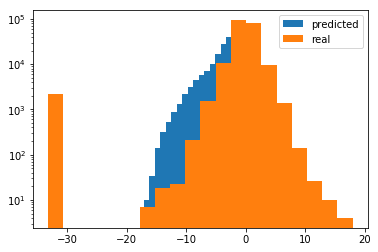

In [372]:
plt.figure()
plt.hist(y_pred,bins=20,label='predicted')
plt.hist(df_train.target,bins=20,label='real')
plt.yscale('log')
plt.legend()

In [369]:
mean_squared_error(df_train.target,y_pred)

23.94189687401011

# New features from purchase amount by month
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/79217

In [402]:
df_new=pd.read_csv('regression.csv')
df_new.head()

,card_id,coef,intercept
0,C_ID_00007093c1,0.033841,-5.447030
1,C_ID_0001238066,-0.455342,-11.679725
2,C_ID_0001506ef0,-0.097407,-3.234127
3,C_ID_0001793786,-0.234057,-4.122391
4,C_ID_000183fdda,0.290512,-8.154954


In [406]:
df_new.card_id.head()

0    C_ID_00007093c1
1    C_ID_0001238066
2    C_ID_0001506ef0
3    C_ID_0001793786
4    C_ID_000183fdda
Name: card_id, dtype: object

In [413]:
df_train=pd.merge(df_train,df_new,on='card_id')

In [416]:
df_test=pd.merge(df_test,df_new,on='card_id')


In [420]:
df_train_columns_new=df_train_columns[:]
df_train_columns_new=df_train_columns_new+['coef','intercept']

In [424]:
train_data=lgb.Dataset(df_train[df_train_columns_new],label=df_train.target)

In [429]:
lgb_cv = lgb.cv(param, train_data, 10000, stratified=False, early_stopping_rounds=600, verbose_eval=200)
print(f'best cv score: {lgb_cv["rmse-mean"][-1]}\nbest boost nums: {len(lgb_cv["rmse-mean"])}')

[200]	cv_agg's rmse: 3.68144 + 0.0295616
[400]	cv_agg's rmse: 3.66127 + 0.0288369
[600]	cv_agg's rmse: 3.65371 + 0.0282249
[800]	cv_agg's rmse: 3.65077 + 0.0282928
[1000]	cv_agg's rmse: 3.6496 + 0.0278915
[1200]	cv_agg's rmse: 3.64933 + 0.0275225
[1400]	cv_agg's rmse: 3.64966 + 0.0270221
[1600]	cv_agg's rmse: 3.65005 + 0.0266075
best cv score: 3.649255706519766
best boost nums: 1160


In [431]:
clf=lgb.train(param,train_data,1400,valid_sets=[train_data],early_stopping_rounds=600, verbose_eval=200)

Training until validation scores don't improve for 600 rounds.
[200]	training's rmse: 3.57319
[400]	training's rmse: 3.48621
[600]	training's rmse: 3.42882
[800]	training's rmse: 3.38571
[1000]	training's rmse: 3.34805
[1200]	training's rmse: 3.31521
[1400]	training's rmse: 3.2828
Did not meet early stopping. Best iteration is:
[1400]	training's rmse: 3.2828


In [432]:
y_pred=lgb_cv_testing(param,df_train[df_train_columns_new].values,df_test[df_train_columns_new],df_train.target)

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.5407	valid_1's rmse: 3.7278
[400]	training's rmse: 3.44614	valid_1's rmse: 3.7042
[600]	training's rmse: 3.38389	valid_1's rmse: 3.69582
[800]	training's rmse: 3.33623	valid_1's rmse: 3.69269
[1000]	training's rmse: 3.29479	valid_1's rmse: 3.69179
[1200]	training's rmse: 3.25621	valid_1's rmse: 3.69221
Early stopping, best iteration is:
[967]	training's rmse: 3.30154	valid_1's rmse: 3.6916
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55833	valid_1's rmse: 3.65964
[400]	training's rmse: 3.4603	valid_1's rmse: 3.63935
[600]	training's rmse: 3.39891	valid_1's rmse: 3.63332
[800]	training's rmse: 3.3497	valid_1's rmse: 3.63043
[1000]	training's rmse: 3.30755	valid_1's rmse: 3.62877
[1200]	training's rmse: 3.26869	valid_1's rmse: 3.62796
[1400]	training's rmse: 3.23395	valid_1's rmse: 3.62765
[1600]	training's rmse: 3.20031	valid_1's rmse: 3.6277

In [436]:
#LB:3.674
df=pd.DataFrame({'card_id':df_test.card_id,'target':y_pred})
df.to_csv('submission_with_2extraf.csv',index=False)

In [437]:
train_data=lgb.Dataset(df_train[df_train_columns_new],label=df_train.target)

In [438]:
clf=lgb.train(param,train_data,1650,valid_sets=[train_data], verbose_eval=200,early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.57319
[400]	training's rmse: 3.48621
[600]	training's rmse: 3.42882
[800]	training's rmse: 3.38571
[1000]	training's rmse: 3.34805
[1200]	training's rmse: 3.31521
[1400]	training's rmse: 3.2828
[1600]	training's rmse: 3.25397
Did not meet early stopping. Best iteration is:
[1650]	training's rmse: 3.24698


In [439]:
y_pred=clf.predict(df_test[df_train_columns])

In [440]:
#lB: 3.678
df=pd.DataFrame({'card_id':df_test.card_id,'target':y_pred})
df.to_csv('submission_with_2extraf_all_data.csv',index=False)

In [442]:
y_pred=clf.predict(df_test[df_train_columns],num_iteration=1200)

In [443]:
#LB:3.679
df=pd.DataFrame({'card_id':df_test.card_id,'target':y_pred})
df.to_csv('submission_with_2extraf_all_data_1200.csv',index=False)

# Now , let's use merchant features fron new merchant transactions

In [448]:
df=pd.read_pickle('../merchant_merge_new_hist_features.pickle')

In [450]:
df_train=df_train.merge(df,on='card_id', how='left')

In [451]:
df_test=df_test.merge(df,on='card_id', how='left')

In [452]:
exclude_features = []
exclude_features += ['card_id', 'first_active_month','target','outliers']
df_train_columns_5 = [c for c in df_train.columns if c not in exclude_features ]

In [453]:
len(df_train_columns_5)

309

In [454]:
y_pred=lgb_cv_testing(param,df_train[df_train_columns_5].values,df_test[df_train_columns_5],df_train.target)

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.54068	valid_1's rmse: 3.73065
[400]	training's rmse: 3.44408	valid_1's rmse: 3.7058
[600]	training's rmse: 3.38228	valid_1's rmse: 3.69746
[800]	training's rmse: 3.33429	valid_1's rmse: 3.69538
[1000]	training's rmse: 3.29334	valid_1's rmse: 3.69434
[1200]	training's rmse: 3.25588	valid_1's rmse: 3.69399
[1400]	training's rmse: 3.21884	valid_1's rmse: 3.69453
[1600]	training's rmse: 3.18482	valid_1's rmse: 3.69509
Early stopping, best iteration is:
[1223]	training's rmse: 3.25115	valid_1's rmse: 3.69366
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55718	valid_1's rmse: 3.65952
[400]	training's rmse: 3.45889	valid_1's rmse: 3.63897
[600]	training's rmse: 3.39555	valid_1's rmse: 3.63239
[800]	training's rmse: 3.34507	valid_1's rmse: 3.62935
[1000]	training's rmse: 3.30179	valid_1's rmse: 3.62733
[1200]	training's rmse: 3.26338	valid_1's rmse: 

In [455]:
#LB:3.678
df=pd.DataFrame({'card_id':df_test.card_id,'target':y_pred})
df.to_csv('submission_with_2extraf_new_merchant.csv', index=False)

# I have idea. Maybe reducing number of folds can make it CV more reliable. The main reason of deviations is due to outliers. If we have more outliers we might be able reduce effect of each individual outlier

In [502]:
def lgb_cv_fold(param, data,test, features,num_fold):
    folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)
    oof = np.zeros(data.shape[0])
    predictions=np.zeros(test.shape[0])
    feature_importance=pd.DataFrame()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(data, data.target)):
        print(f'fold: {fold_}')
        trn_data = lgb.Dataset(data[features].loc[trn_idx], label=data.target[trn_idx])
        val_data = lgb.Dataset(data[features].loc[val_idx], label=data.target[val_idx])
        clf = lgb.train(param, trn_data, 10000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400)
        oof[val_idx] = clf.predict(data[features].loc[val_idx], num_iteration=clf.best_iteration)
        predictions+=clf.predict(test[features],num_iteration=clf.best_iteration)/folds.n_splits
        feature_importance[fold_]=clf.feature_importance()
        feature_importance.index=clf.feature_name()
        del clf, trn_idx, val_idx
        gc.collect()
    df_sub=pd.DataFrame({'card_id':test.card_id,'target':predictions})
    print("CV error:"+str(mean_squared_error(target, oof)**0.5))
    return df_sub,feature_importance

In [503]:
df_sub5,feature_importance5=lgb_cv_fold(param,df_train,df_test,df_train_columns,5)

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

In [485]:
feature_importance5['mean']=feature_importance5[[0,1,2,3,4]].mean(axis=1)


In [487]:
feature_importance5['std']=feature_importance5[[0,1,2,3,4]].std(axis=1)

In [488]:
feature_importance5.sort_values('mean',ascending=False).head(20)

,0,1,2,3,4,mean,std
auth_hist_month_diff_mean,1049,1635,647,1214,1940,1297.0,504.625108
new_hist_purchase_date_uptonow,950,1206,560,1002,1533,1050.2,357.081503
hist_month_diff_mean,924,1335,427,987,1481,1030.8,410.218478
new_hist_purchase_amount_max,878,1147,686,877,1030,923.6,174.594673
auth_hist_purchase_date_max,635,1119,350,782,1180,813.2,344.724093
auth_hist_month_nunique,567,771,471,642,848,659.8,151.952953
new_hist_purchase_date_max,509,744,242,584,945,604.8,262.843490
auth_hist_purchase_date_min,388,510,267,566,608,467.8,139.435290
new_hist_purchase_amount_mean,462,478,273,444,628,457.0,126.225988
auth_encoder_merchant_category_id_auth_mean_mean,298,546,266,434,596,428.0,146.054784


In [491]:
df_sub4,feature_importance4=lgb_cv_fold(param,df_train,df_test,df_train_columns,4)

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.5362	valid_1's rmse: 3.71161
[400]	training's rmse: 3.43755	valid_1's rmse: 3.6919
[600]	training's rmse: 3.37272	valid_1's rmse: 3.68656
[800]	training's rmse: 3.32192	valid_1's rmse: 3.68442
[1000]	training's rmse: 3.2773	valid_1's rmse: 3.68297
[1200]	training's rmse: 3.23784	valid_1's rmse: 3.68236
[1400]	training's rmse: 3.20284	valid_1's rmse: 3.68237
[1600]	training's rmse: 3.1677	valid_1's rmse: 3.68179
[1800]	training's rmse: 3.13571	valid_1's rmse: 3.68222
[2000]	training's rmse: 3.10387	valid_1's rmse: 3.68247
Early stopping, best iteration is:
[1603]	training's rmse: 3.1672	valid_1's rmse: 3.68176
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.52755	valid_1's rmse: 3.74889
[400]	training's rmse: 3.42867	valid_1's rmse: 3.72609
[600]	training's rmse: 3.367	valid_1's rmse: 3.71798
[800]	training's rmse: 3.31883	valid_1's rmse: 3.7147

In [492]:
feature_importance4['mean']=feature_importance4.mean(axis=1)
feature_importance4['std']=feature_importance4.std(axis=1)
feature_importance4.sort_values('mean',ascending=False).head(20)

,0,1,2,3,mean,std
auth_hist_month_diff_mean,1422,1626,845,1813,1426.50,363.092619
hist_month_diff_mean,1211,1352,647,1313,1130.75,283.998570
new_hist_purchase_date_uptonow,1096,1229,696,1418,1109.75,264.866358
new_hist_purchase_amount_max,981,1099,771,1017,967.00,120.971071
auth_hist_purchase_date_max,800,1162,529,1134,906.25,260.232949
new_hist_purchase_date_max,684,734,424,813,663.75,145.860164
auth_hist_month_nunique,586,745,528,782,660.25,106.076329
auth_hist_purchase_date_min,582,507,371,595,513.75,88.998244
new_hist_purchase_amount_mean,544,503,290,536,468.25,104.053772
auth_encoder_merchant_category_id_auth_mean_mean,333,556,312,635,459.00,139.525983


In [490]:
df_sub3,feature_importance3=lgb_cv_fold(param,df_train,df_test,df_train_columns,3)

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.50432	valid_1's rmse: 3.74193
[400]	training's rmse: 3.40117	valid_1's rmse: 3.72204
[600]	training's rmse: 3.33267	valid_1's rmse: 3.71522
[800]	training's rmse: 3.27991	valid_1's rmse: 3.7129
[1000]	training's rmse: 3.23429	valid_1's rmse: 3.71133
[1200]	training's rmse: 3.19424	valid_1's rmse: 3.71075
[1400]	training's rmse: 3.15619	valid_1's rmse: 3.71061
[1600]	training's rmse: 3.11919	valid_1's rmse: 3.71051
[1800]	training's rmse: 3.08456	valid_1's rmse: 3.71104
Early stopping, best iteration is:
[1557]	training's rmse: 3.12675	valid_1's rmse: 3.71046
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.54891	valid_1's rmse: 3.6559
[400]	training's rmse: 3.44297	valid_1's rmse: 3.63394
[600]	training's rmse: 3.37702	valid_1's rmse: 3.62676
[800]	training's rmse: 3.32447	valid_1's rmse: 3.62382
[1000]	training's rmse: 3.27952	valid_1's rmse: 3

In [489]:
df_sub2,feature_importance2=lgb_cv_fold(param,df_train,df_test,df_train_columns,2)

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.46497	valid_1's rmse: 3.72778
[400]	training's rmse: 3.35131	valid_1's rmse: 3.70506
[600]	training's rmse: 3.27707	valid_1's rmse: 3.69869
[800]	training's rmse: 3.21547	valid_1's rmse: 3.69607
[1000]	training's rmse: 3.16139	valid_1's rmse: 3.69539
[1200]	training's rmse: 3.1127	valid_1's rmse: 3.69528
[1400]	training's rmse: 3.06835	valid_1's rmse: 3.69532
[1600]	training's rmse: 3.02587	valid_1's rmse: 3.6953
Early stopping, best iteration is:
[1353]	training's rmse: 3.07879	valid_1's rmse: 3.69513
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.54316	valid_1's rmse: 3.6357
[400]	training's rmse: 3.42097	valid_1's rmse: 3.61766
[600]	training's rmse: 3.34121	valid_1's rmse: 3.61174
[800]	training's rmse: 3.27983	valid_1's rmse: 3.60962
[1000]	training's rmse: 3.22822	valid_1's rmse: 3.60936
[1200]	training's rmse: 3.17819	valid_1's rmse: 3.

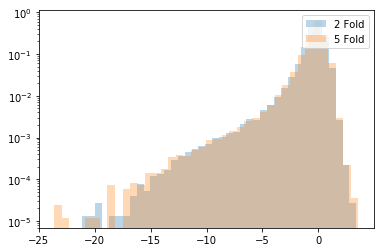

In [501]:
plt.figure()
kwargds = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)
plt.hist(df_sub2.target,label='2 Fold',**kwargds)
#plt.hist(df_sub3.target,label='3 Fold',**kwargds)
#plt.hist(df_sub4.target,label='4 Fold',**kwargds)
plt.hist(df_sub5.target,label='5 Fold',**kwargds)
plt.legend()
plt.yscale('log')

# Let's check how much amount of data is effecting error. Basically, we will answer to question if more data helps to improve or not

In [552]:
def lgb_cv_num_data(param, data, features,num_fold):
    # 20% test size
    train,test=train_test_split(data,stratify=data.outliers,test_size=0.2,random_state=4950)
    rmse={}
    train_idx=[]
    folds = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=4950)
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(data[features], data.outliers)):
        print(f'fold: {fold_}')
        train_idx+=list(val_idx) # add more data in each round
        print(len(train_idx))
        trn_data = lgb.Dataset(train[features].loc[train_idx], label=train.target[train_idx])
        val_data = lgb.Dataset(test[features], label=test.target)
        clf = lgb.train(param, trn_data, 10000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400)
        oof = clf.predict(test[features], num_iteration=clf.best_iteration)
        rmse[fold_]=mean_squared_error(test.target, oof)**0.5
    return rmse


In [553]:
rmse=lgb_cv_num_data(param,df_train,df_train_columns,10)

fold: 0
20192
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: nan	valid_1's rmse: 3.7043
[400]	training's rmse: nan	valid_1's rmse: 3.68897


TypeError: 'NoneType' object is not iterable

In [ ]:
df_sub2,feature_importance2=lgb_cv_fold(param,df_train,df_test,df_train_columns,2)

In [524]:
train_idx.keys()

dict_keys([0, 1, 2, 3, 4])

In [558]:
param

{'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'bagging_seed': 42,
 'boosting': 'gbdt',
 'feature_fraction': 0.9,
 'lambda_l1': 0.1,
 'learning_rate': 0.01,
 'max_depth': -1,
 'metric': 'rmse',
 'min_child_samples': 20,
 'min_data_in_leaf': 32,
 'nthread': 48,
 'num_leaves': 31,
 'objective': 'regression',
 'random_state': 4950,
 'verbosity': -1}

In [592]:
num_fold=10
train,test=train_test_split(df_train,stratify=df_train.outliers,test_size=0.2,)
rmse={}
train_idx=[]
folds = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=4950)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train[df_train_columns], train['outliers'])):
    print(f'fold: {fold_}')
    train_idx+=list(val_idx) # add more data in each round
    print(len(train_idx))
    trn_data = lgb.Dataset(train[df_train_columns].iloc[train_idx], label=train.target.iloc[train_idx])
    val_data = lgb.Dataset(test[df_train_columns], label=test.target)
    clf = lgb.train(param, trn_data, 10000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400)
    oof = clf.predict(test[df_train_columns], num_iteration=clf.best_iteration)
    rmse[fold_]=mean_squared_error(test.target, oof)**0.5

fold: 0
16154
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.26384	valid_1's rmse: 3.71691
[400]	training's rmse: 2.97698	valid_1's rmse: 3.71207
[600]	training's rmse: 2.77186	valid_1's rmse: 3.71579
Early stopping, best iteration is:
[307]	training's rmse: 3.09281	valid_1's rmse: 3.71138
fold: 1
32308
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.34184	valid_1's rmse: 3.70186
[400]	training's rmse: 3.13908	valid_1's rmse: 3.69173
[600]	training's rmse: 2.99332	valid_1's rmse: 3.69349
[800]	training's rmse: 2.87368	valid_1's rmse: 3.69643
Early stopping, best iteration is:
[453]	training's rmse: 3.09757	valid_1's rmse: 3.69131
fold: 2
48462
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.40866	valid_1's rmse: 3.69194
[400]	training's rmse: 3.23691	valid_1's rmse: 3.67915
[600]	training's rmse: 3.12221	valid_1's rmse: 3.67822
[800]	training's rmse: 3.02596	valid_1'

In [605]:
clf.current_iteration()

1710

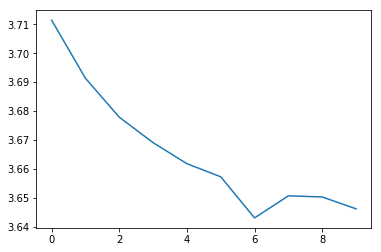

In [601]:
plt.figure()
plt.plot(rmse.keys(),rmse.values())

In [606]:
num_fold=10
train,test=train_test_split(df_train,stratify=df_train.outliers,test_size=0.2,)
rmse={}
train_idx=[]
folds = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=4950)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train[df_train_columns], train['outliers'])):
    print(f'fold: {fold_}')
    train_idx+=list(val_idx) # add more data in each round
    print(len(train_idx))
    trn_data = lgb.Dataset(train[df_train_columns].iloc[train_idx], label=train.target.iloc[train_idx])
    val_data = lgb.Dataset(test[df_train_columns], label=test.target)
    clf = lgb.train(param4, trn_data, 10000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400)
    oof = clf.predict(test[df_train_columns], num_iteration=clf.best_iteration)
    rmse[fold_]=mean_squared_error(test.target, oof)**0.5

fold: 0
16154
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.26255	valid_1's rmse: 3.72004
[400]	training's rmse: 2.98372	valid_1's rmse: 3.72208
Early stopping, best iteration is:
[181]	training's rmse: 3.29941	valid_1's rmse: 3.7183
fold: 1
32308
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.39168	valid_1's rmse: 3.70221
[400]	training's rmse: 3.2036	valid_1's rmse: 3.69478
[600]	training's rmse: 3.07002	valid_1's rmse: 3.69472
[800]	training's rmse: 2.95844	valid_1's rmse: 3.69788
Early stopping, best iteration is:
[528]	training's rmse: 3.11482	valid_1's rmse: 3.69398
fold: 2
48462
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.42704	valid_1's rmse: 3.69854
[400]	training's rmse: 3.27299	valid_1's rmse: 3.68873
[600]	training's rmse: 3.16434	valid_1's rmse: 3.68703
[800]	training's rmse: 3.07298	valid_1's rmse: 3.68851
[1000]	training's rmse: 2.99441	valid_1's

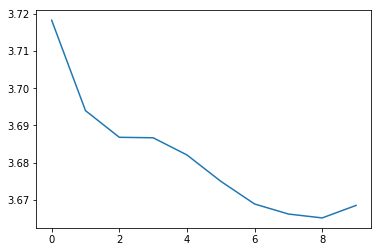

In [607]:
plt.figure()
plt.plot(rmse.keys(),rmse.values())

In [608]:
num_fold=10
train,test=train_test_split(df_train,stratify=df_train.outliers,test_size=0.2,)
rmse={}
train_idx=[]
folds = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=4950)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train[df_train_columns], train['outliers'])):
    print(f'fold: {fold_}')
    train_idx+=list(val_idx) # add more data in each round
    print(len(train_idx))
    trn_data = lgb.Dataset(train[df_train_columns].iloc[train_idx], label=train.target.iloc[train_idx])
    val_data = lgb.Dataset(test[df_train_columns], label=test.target)
    clf = lgb.train(param_opt, trn_data, 10000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400)
    oof = clf.predict(test[df_train_columns], num_iteration=clf.best_iteration)
    rmse[fold_]=mean_squared_error(test.target, oof)**0.5

fold: 0
16154
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.23613	valid_1's rmse: 3.71455
[400]	training's rmse: 2.99659	valid_1's rmse: 3.70758
[600]	training's rmse: 2.84065	valid_1's rmse: 3.70649
[800]	training's rmse: 2.70322	valid_1's rmse: 3.7069
Early stopping, best iteration is:
[579]	training's rmse: 2.85909	valid_1's rmse: 3.70627
fold: 1
32308
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.40224	valid_1's rmse: 3.69017
[400]	training's rmse: 3.22304	valid_1's rmse: 3.67826
[600]	training's rmse: 3.11304	valid_1's rmse: 3.67688
[800]	training's rmse: 3.01869	valid_1's rmse: 3.67743
Early stopping, best iteration is:
[573]	training's rmse: 3.12586	valid_1's rmse: 3.67651
fold: 2
48462
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.44342	valid_1's rmse: 3.69022
[400]	training's rmse: 3.28657	valid_1's rmse: 3.6784
[600]	training's rmse: 3.17991	valid_1's 

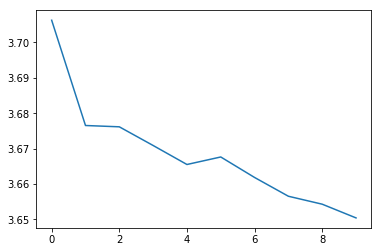

In [609]:
plt.figure()
plt.plot(rmse.keys(),rmse.values())

In [512]:
trn_data = lgb.Dataset(train[df_train_columns].iloc[train_idx], label=train.target.iloc[train_idx])



[]

In [610]:
?lgb.Dataset

# Uniform distribution of train data from Aleksandr Kosolapov
###https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/78903

In [646]:
train=df_train.copy()

In [647]:
train['rounded_target'] = train['target'].round(0)

train = train.sort_values('rounded_target').reset_index(drop=True)

vc = train['rounded_target'].value_counts()

vc = dict(sorted(vc.items()))

df = pd.DataFrame()

train['indexcol'],i = 0,1

for k,v in vc.items():

    step = train.shape[0]/v

    indent = train.shape[0]/(v+1)

    df2 = train[train['rounded_target'] == k].sample(v, random_state=120).reset_index(drop=True)

    for j in range(0, v):

        df2.at[j, 'indexcol'] = indent + j*step + 0.000001*i

    df = pd.concat([df2,df])

    i+=1

train = df.sort_values('indexcol', ascending=True).reset_index(drop=True)

del train['indexcol'], train['rounded_target']

In [651]:
train_data=lgb.Dataset(df[df_train_columns],label=df.target)

In [654]:
lgb_cv=lgb.cv(param,train_data,10000,verbose_eval=200,early_stopping_rounds=400,stratified=False)

[200]	cv_agg's rmse: 3.67861 + 0.0960188
[400]	cv_agg's rmse: 3.65819 + 0.0956289
[600]	cv_agg's rmse: 3.6509 + 0.0962171
[800]	cv_agg's rmse: 3.64795 + 0.0966084
[1000]	cv_agg's rmse: 3.6467 + 0.0964896
[1200]	cv_agg's rmse: 3.64608 + 0.09629
[1400]	cv_agg's rmse: 3.64601 + 0.0963511
[1600]	cv_agg's rmse: 3.64581 + 0.0964606
[1800]	cv_agg's rmse: 3.64594 + 0.0963038
[2000]	cv_agg's rmse: 3.64608 + 0.0960098


In [669]:
num_fold=10
train,test=train_test_split(df,test_size=0.2,)
rmse={}
train_idx=[]
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train[df_train_columns], train['outliers'])):
    print(f'fold: {fold_}')
    train_idx+=list(val_idx) # add more data in each round
    print(len(train_idx))
    trn_data = lgb.Dataset(train[df_train_columns].iloc[train_idx], label=train.target.iloc[train_idx])
    val_data = lgb.Dataset(test[df_train_columns], label=test.target)
    clf = lgb.train(param_opt, trn_data, 10000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400)
    oof = clf.predict(test[df_train_columns], num_iteration=clf.best_iteration)
    rmse[fold_]=mean_squared_error(test.target, oof)**0.5

fold: 0
16154
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.17559	valid_1's rmse: 3.74338
[400]	training's rmse: 2.93216	valid_1's rmse: 3.73779
[600]	training's rmse: 2.78235	valid_1's rmse: 3.74043
Early stopping, best iteration is:
[395]	training's rmse: 2.93628	valid_1's rmse: 3.7376
fold: 1
32308
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.31125	valid_1's rmse: 3.71199
[400]	training's rmse: 3.11819	valid_1's rmse: 3.70473
[600]	training's rmse: 2.99658	valid_1's rmse: 3.70573
[800]	training's rmse: 2.89591	valid_1's rmse: 3.70839
Early stopping, best iteration is:
[431]	training's rmse: 3.09726	valid_1's rmse: 3.70434
fold: 2
48462
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.40382	valid_1's rmse: 3.69987
[400]	training's rmse: 3.24053	valid_1's rmse: 3.68901
[600]	training's rmse: 3.13977	valid_1's rmse: 3.68854
[800]	training's rmse: 3.06185	valid_1's

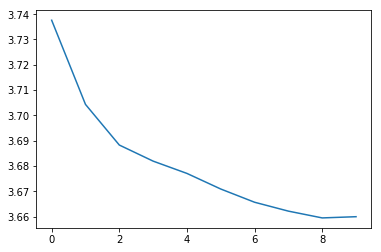

In [671]:
plt.figure()
plt.plot(rmse.keys(),rmse.values())

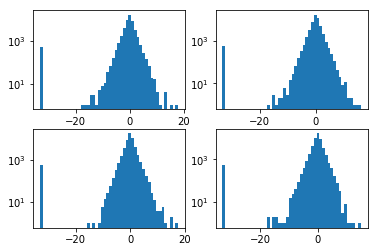

In [685]:
folds = KFold(n_splits=4, shuffle=True, random_state=4950)
plt.figure()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
    plt.subplot(2,2,fold_+1)
    plt.hist(df.target.iloc[val_idx],bins=50)
    plt.yscale('log')

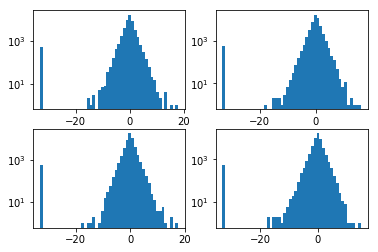

In [686]:
folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=4950)
plt.figure()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train[df_train_columns],df_train.outliers)):
    plt.subplot(2,2,fold_+1)
    plt.hist(df.target.iloc[val_idx],bins=50)
    plt.yscale('log')

In [691]:
train_data=lgb.Dataset(df[df_train_columns],label=df.target)
lgb_cv = lgb.cv(param_opt, train_data, 10000, stratified=False,shuffle=True, early_stopping_rounds=600, verbose_eval=200)
print(f'best cv score: {lgb_cv["rmse-mean"][-1]}\nbest boost nums: {len(lgb_cv["rmse-mean"])}')

[200]	cv_agg's rmse: 3.66759 + 0.095848
[400]	cv_agg's rmse: 3.64877 + 0.0952354
[600]	cv_agg's rmse: 3.64435 + 0.0956795
[800]	cv_agg's rmse: 3.64286 + 0.0957362
[1000]	cv_agg's rmse: 3.64227 + 0.095869
[1200]	cv_agg's rmse: 3.64233 + 0.0956713
[1400]	cv_agg's rmse: 3.64244 + 0.0955121
[1600]	cv_agg's rmse: 3.64288 + 0.0952788
[1800]	cv_agg's rmse: 3.64349 + 0.0952903
best cv score: 3.6422150419263537
best boost nums: 1246


In [721]:
df['stratify']=(df['target']).round().astype('int')

In [722]:
df['stratify'].value_counts()

 0     68531
-1     38864
 1     37614
-2     15652
 2     14648
-3      6685
 3      6400
-4      3067
 4      2907
-33     2207
-5      1515
 5      1388
-6       704
 6       652
 7       313
-7       284
-8       141
 8       103
-9        56
 9        47
-10       31
 10       27
-11       14
 11       11
 12       10
-14        8
-15        6
-13        6
-12        5
 13        4
 15        4
 14        3
-17        3
 16        2
-16        2
 18        2
-18        1
Name: stratify, dtype: int64

In [723]:
train,test=train_test_split(df,test_size=0.2,stratify=df['stratify'])


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [711]:
train.outliers.mean(),test.outliers.mean()

(0.010932750583472107, 0.010920166402535658)

In [724]:
num_fold=10
train,test=train_test_split(df,test_size=0.2)
rmse={}
train_idx=[]
folds = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=4950)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train[df_train_columns], train['stratify'])):
    print(f'fold: {fold_}')
    train_idx+=list(val_idx) # add more data in each round
    print(len(train_idx))
    trn_data = lgb.Dataset(train[df_train_columns].iloc[train_idx], label=train.target.iloc[train_idx])
    val_data = lgb.Dataset(test[df_train_columns], label=test.target)
    clf = lgb.train(param_opt, trn_data, 10000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400)
    oof = clf.predict(test[df_train_columns], num_iteration=clf.best_iteration)
    rmse[fold_]=mean_squared_error(test.target, oof)**0.5

fold: 0
16165
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.24212	valid_1's rmse: 3.74837
[400]	training's rmse: 3.03152	valid_1's rmse: 3.74098
[600]	training's rmse: 2.88906	valid_1's rmse: 3.74326
Early stopping, best iteration is:
[335]	training's rmse: 3.08779	valid_1's rmse: 3.7407
fold: 1
32336
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.35866	valid_1's rmse: 3.72982
[400]	training's rmse: 3.17858	valid_1's rmse: 3.71582
[600]	training's rmse: 3.08291	valid_1's rmse: 3.71422
[800]	training's rmse: 2.99618	valid_1's rmse: 3.71433
Early stopping, best iteration is:
[519]	training's rmse: 3.12086	valid_1's rmse: 3.71386
fold: 2
48492
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.41375	valid_1's rmse: 3.72259
[400]	training's rmse: 3.26241	valid_1's rmse: 3.70476
[600]	training's rmse: 3.16862	valid_1's rmse: 3.70017
[800]	training's rmse: 3.09692	valid_1's

fold: 0
16154
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.35429	valid_1's rmse: 3.6656
[400]	training's rmse: 3.05082	valid_1's rmse: 3.66455
[600]	training's rmse: 2.83211	valid_1's rmse: 3.66977
Early stopping, best iteration is:
[307]	training's rmse: 3.1749	valid_1's rmse: 3.66258
fold: 1
32308
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.36198	valid_1's rmse: 3.66048
[400]	training's rmse: 3.15286	valid_1's rmse: 3.65186
[600]	training's rmse: 3.00524	valid_1's rmse: 3.6518
[800]	training's rmse: 2.88496	valid_1's rmse: 3.65352
Early stopping, best iteration is:
[468]	training's rmse: 3.09909	valid_1's rmse: 3.65146
fold: 2
48462
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.46726	valid_1's rmse: 3.65415
[400]	training's rmse: 3.28679	valid_1's rmse: 3.64119
[600]	training's rmse: 3.168	valid_1's rmse: 3.63845
[800]	training's rmse: 3.06907	valid_1's rms

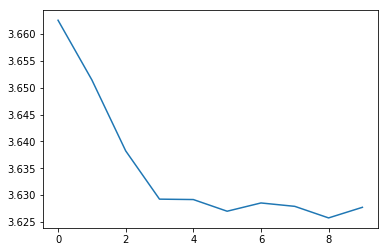

In [672]:
num_fold=10
train,test=train_test_split(df,test_size=0.2,)
rmse={}
train_idx=[]
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train[df_train_columns], train['outliers'])):
    print(f'fold: {fold_}')
    train_idx+=list(val_idx) # add more data in each round
    print(len(train_idx))
    trn_data = lgb.Dataset(train[df_train_columns].iloc[train_idx], label=train.target.iloc[train_idx])
    val_data = lgb.Dataset(test[df_train_columns], label=test.target)
    clf = lgb.train(param, trn_data, 10000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400)
    oof = clf.predict(test[df_train_columns], num_iteration=clf.best_iteration)
    rmse[fold_]=mean_squared_error(test.target, oof)**0.5
plt.figure()
plt.plot(rmse.keys(),rmse.values())

In [668]:
num_fold=5
rmse={}
oof=np.zeros(df.shape[0])
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
    trn_data = lgb.Dataset(df[df_train_columns].iloc[trn_idx], label=df.target.iloc[trn_idx])
    val_data = lgb.Dataset(df[df_train_columns].iloc[val_idx], label=df.target.iloc[val_idx])
    clf = lgb.train(param_opt, trn_data, 10000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400)
    oof[val_idx] = clf.predict(df[df_train_columns].iloc[val_idx], num_iteration=clf.best_iteration)
mean_squared_error(df.target, oof)**0.5

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.57417	valid_1's rmse: 3.61829
[400]	training's rmse: 3.48915	valid_1's rmse: 3.60454
[600]	training's rmse: 3.43699	valid_1's rmse: 3.60038
[800]	training's rmse: 3.39353	valid_1's rmse: 3.59886
[1000]	training's rmse: 3.35349	valid_1's rmse: 3.59842
[1200]	training's rmse: 3.31684	valid_1's rmse: 3.59834
[1400]	training's rmse: 3.28176	valid_1's rmse: 3.59883
Early stopping, best iteration is:
[1063]	training's rmse: 3.34124	valid_1's rmse: 3.59806
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.5615	valid_1's rmse: 3.67904
[400]	training's rmse: 3.4782	valid_1's rmse: 3.6629
[600]	training's rmse: 3.42541	valid_1's rmse: 3.65903
[800]	training's rmse: 3.38395	valid_1's rmse: 3.6573
[1000]	training's rmse: 3.34545	valid_1's rmse: 3.65662
[1200]	training's rmse: 3.30965	valid_1's rmse: 3.65682
[1400]	training's rmse: 3.27477	valid_1's rmse: 3.65694
Early stopp

3.64486405058755

In [673]:
num_fold=5
rmse={}
oof=np.zeros(df.shape[0])
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
    trn_data = lgb.Dataset(df[df_train_columns].iloc[trn_idx], label=df.target.iloc[trn_idx])
    val_data = lgb.Dataset(df[df_train_columns].iloc[val_idx], label=df.target.iloc[val_idx])
    clf = lgb.train(param, trn_data, 10000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400)
    oof[val_idx] = clf.predict(df[df_train_columns].iloc[val_idx], num_iteration=clf.best_iteration)
mean_squared_error(df.target, oof)**0.5

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.56031	valid_1's rmse: 3.63525
[400]	training's rmse: 3.46123	valid_1's rmse: 3.61969
[600]	training's rmse: 3.40047	valid_1's rmse: 3.61417
[800]	training's rmse: 3.35197	valid_1's rmse: 3.61229
[1000]	training's rmse: 3.30981	valid_1's rmse: 3.61152
[1200]	training's rmse: 3.27169	valid_1's rmse: 3.61143
[1400]	training's rmse: 3.23668	valid_1's rmse: 3.61125
[1600]	training's rmse: 3.20323	valid_1's rmse: 3.61118
Early stopping, best iteration is:
[1367]	training's rmse: 3.24231	valid_1's rmse: 3.61099
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.5489	valid_1's rmse: 3.68959
[400]	training's rmse: 3.44986	valid_1's rmse: 3.67235
[600]	training's rmse: 3.39004	valid_1's rmse: 3.66624
[800]	training's rmse: 3.3441	valid_1's rmse: 3.66459
[1000]	training's rmse: 3.3033	valid_1's rmse: 3.66469
[1200]	training's rmse: 3.2679	valid_1's rmse: 3.66409
[1400]	trai

3.650907789270488

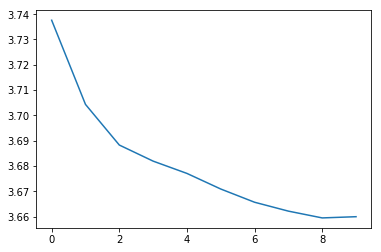

In [670]:
plt.figure()
plt.plot(rmse.keys(),rmse.values())

In [674]:
num_fold=5
rmse={}
oof=np.zeros(df.shape[0])
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
    trn_data = lgb.Dataset(df[df_train_columns].iloc[trn_idx], label=df.target.iloc[trn_idx])
    val_data = lgb.Dataset(df[df_train_columns].iloc[val_idx], label=df.target.iloc[val_idx])
    clf = lgb.train(param4, trn_data, 10000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400)
    oof[val_idx] = clf.predict(df[df_train_columns].iloc[val_idx], num_iteration=clf.best_iteration)
mean_squared_error(df.target, oof)**0.5

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.57129	valid_1's rmse: 3.63246
[400]	training's rmse: 3.47974	valid_1's rmse: 3.61718
[600]	training's rmse: 3.42295	valid_1's rmse: 3.61137
[800]	training's rmse: 3.37852	valid_1's rmse: 3.60849
[1000]	training's rmse: 3.33951	valid_1's rmse: 3.60726
[1200]	training's rmse: 3.30373	valid_1's rmse: 3.60642
[1400]	training's rmse: 3.27107	valid_1's rmse: 3.60621
[1600]	training's rmse: 3.24032	valid_1's rmse: 3.60612
[1800]	training's rmse: 3.21072	valid_1's rmse: 3.60624
Early stopping, best iteration is:
[1471]	training's rmse: 3.26037	valid_1's rmse: 3.60576
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55901	valid_1's rmse: 3.69115
[400]	training's rmse: 3.4677	valid_1's rmse: 3.6731
[600]	training's rmse: 3.41217	valid_1's rmse: 3.66704
[800]	training's rmse: 3.36999	valid_1's rmse: 3.66543
[1000]	training's rmse: 3.33234	valid_1's rmse: 3.66452
[1200]	tr

3.6497352064511506

In [725]:
param

{'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'bagging_seed': 42,
 'boosting': 'gbdt',
 'feature_fraction': 0.9,
 'lambda_l1': 0.1,
 'learning_rate': 0.01,
 'max_depth': -1,
 'metric': 'rmse',
 'min_child_samples': 20,
 'min_data_in_leaf': 32,
 'nthread': 48,
 'num_leaves': 31,
 'objective': 'regression',
 'random_state': 4950,
 'verbosity': -1}

In [740]:
param_dart=param_opt.copy()
param_dart['boosting']='rf'
eval_results={}

num_fold=5
rmse={}
oof=np.zeros(df.shape[0])
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
    trn_data = lgb.Dataset(df[df_train_columns].iloc[trn_idx], label=df.target.iloc[trn_idx])
    val_data = lgb.Dataset(df[df_train_columns].iloc[val_idx], label=df.target.iloc[val_idx])
    clf = lgb.train(param_dart, trn_data, 10000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400,evals_result=eval_results)
    oof[val_idx] = clf.predict(df[df_train_columns].iloc[val_idx], num_iteration=clf.best_iteration)
mean_squared_error(df.target, oof)**0.5

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.63697	valid_1's rmse: 3.63059
[400]	training's rmse: 3.6365	valid_1's rmse: 3.63184
Early stopping, best iteration is:
[29]	training's rmse: 3.63725	valid_1's rmse: 3.63039
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.62241	valid_1's rmse: 3.69128
[400]	training's rmse: 3.62269	valid_1's rmse: 3.69117
Early stopping, best iteration is:
[60]	training's rmse: 3.62094	valid_1's rmse: 3.69159
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.61638	valid_1's rmse: 3.72035
[400]	training's rmse: 3.61715	valid_1's rmse: 3.71971
Early stopping, best iteration is:
[31]	training's rmse: 3.61506	valid_1's rmse: 3.72057
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.63691	valid_1's rmse: 3.63451
[400]	training's rmse: 3.63746	valid_1's rmse: 3.63492
Early stopping, best iteration is:
[60]	tr

3.681887295595433

In [747]:
eval_results['training']['rmse']

[3.6566549287170718,
 3.6315278847678325,
 3.62516242764802,
 3.618367206008351,
 3.6198357708332396,
 3.620609965548792,
 3.6162364784226635,
 3.613533750400936,
 3.613657248863661,
 3.6128531165111792,
 3.613905192797454,
 3.6144802569172105,
 3.6149364596300795,
 3.6151464239986697,
 3.6154390367342972,
 3.6148376114691034,
 3.6143827483046955,
 3.614087761595908,
 3.6142607826651596,
 3.6138653395466385,
 3.61246808845866,
 3.6129253378675195,
 3.612281528115232,
 3.612515885573932,
 3.6121948602264218,
 3.612470194615912,
 3.6122315929474547,
 3.6122501614497677,
 3.612100529727639,
 3.6119436520053823,
 3.6120927032027033,
 3.6118242310464588,
 3.6120582712032343,
 3.6121150795008994,
 3.6120754176974623,
 3.6120358249535967,
 3.6119255311722234,
 3.611917967171624,
 3.6114439766274136,
 3.6115311148157914,
 3.6119379240756517,
 3.611431514767125,
 3.6113243620462945,
 3.6113508754180326,
 3.6113005350931253,
 3.611316741521795,
 3.611529933512893,
 3.6112821435950027,
 3.6112307

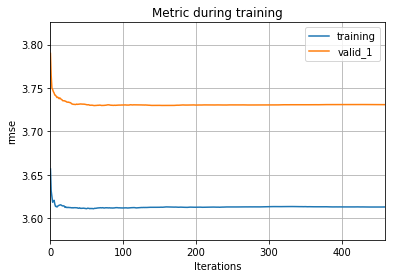

In [742]:
_ = lgb.plot_metric(eval_results)


In [748]:
param_dart=param_opt.copy()
param_dart['boosting']='dart'
eval_list=[]
num_fold=5
rmse={}
oof=np.zeros(df.shape[0])
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
    eval_results={}
    trn_data = lgb.Dataset(df[df_train_columns].iloc[trn_idx], label=df.target.iloc[trn_idx])
    val_data = lgb.Dataset(df[df_train_columns].iloc[val_idx], label=df.target.iloc[val_idx])
    clf = lgb.train(param_dart, trn_data, 2000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400,evals_result=eval_results)
    oof[val_idx] = clf.predict(df[df_train_columns].iloc[val_idx], num_iteration=clf.best_iteration)
    eval_list.append(eval_results)
mean_squared_error(df.target, oof)**0.5

[200]	training's rmse: 3.71647	valid_1's rmse: 3.6736
[400]	training's rmse: 3.65288	valid_1's rmse: 3.64547
[600]	training's rmse: 3.60617	valid_1's rmse: 3.62936
[800]	training's rmse: 3.56083	valid_1's rmse: 3.61907
[1000]	training's rmse: 3.53745	valid_1's rmse: 3.61546
[1200]	training's rmse: 3.50199	valid_1's rmse: 3.60945
[1400]	training's rmse: 3.47696	valid_1's rmse: 3.60563
[1600]	training's rmse: 3.4448	valid_1's rmse: 3.60327
[1800]	training's rmse: 3.41982	valid_1's rmse: 3.60213
[2000]	training's rmse: 3.3975	valid_1's rmse: 3.60074
[200]	training's rmse: 3.69867	valid_1's rmse: 3.74946
[400]	training's rmse: 3.63815	valid_1's rmse: 3.71492
[600]	training's rmse: 3.59214	valid_1's rmse: 3.69565
[800]	training's rmse: 3.54745	valid_1's rmse: 3.68171
[1000]	training's rmse: 3.52493	valid_1's rmse: 3.67704
[1200]	training's rmse: 3.49012	valid_1's rmse: 3.6705
[1400]	training's rmse: 3.46406	valid_1's rmse: 3.66702
[1600]	training's rmse: 3.43254	valid_1's rmse: 3.66442
[180

3.65066779558061

In [758]:
eval_list_dart=eval_list[:]

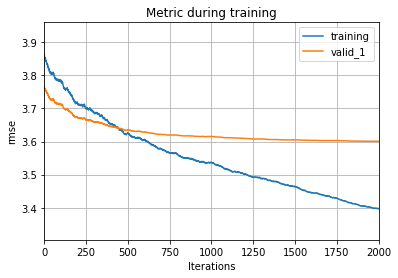

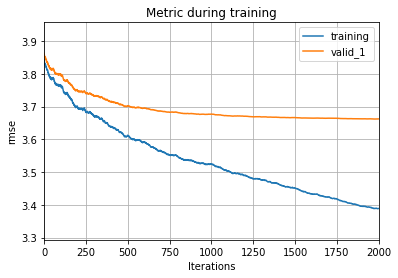

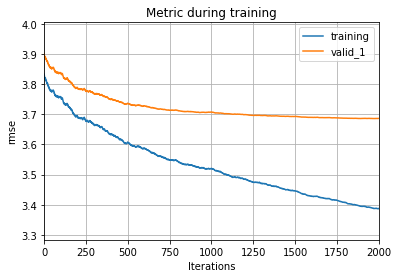

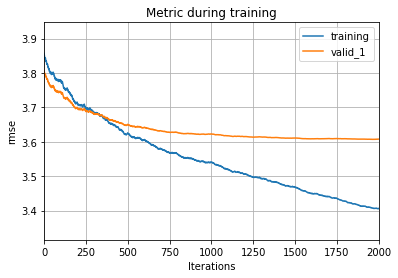

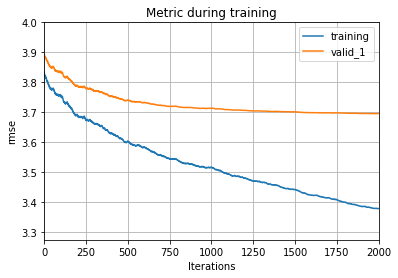

In [759]:
for i in range(5):
    _ = lgb.plot_metric(eval_list[i])

In [810]:
param_opt

{'bagging_fraction': 0.979,
 'bagging_freq': 1,
 'bagging_seed': 42,
 'boosting': 'gbdt',
 'feature_fraction': 0.503,
 'lambda_l1': 3.96,
 'lambda_l2': 5.7,
 'learning_rate': 0.01,
 'max_depth': 7,
 'metric': 'rmse',
 'min_child_samples': 20,
 'min_data_in_leaf': 31,
 'nthread': 48,
 'num_leaves': 55,
 'objective': 'regression',
 'random_state': 4950,
 'verbosity': -1}

In [811]:
param_dart=param_opt.copy()
param_dart['boosting']='dart'
param_dart['nthread']=4
param_dart['device_type']='gpu'
param_dart['gpu_use_dp']=True
eval_list=[]
num_fold=5
rmse={}
oof=np.zeros(df.shape[0])
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
    eval_results={}
    trn_data = lgb.Dataset(df[df_train_columns].iloc[trn_idx], label=df.target.iloc[trn_idx])
    val_data = lgb.Dataset(df[df_train_columns].iloc[val_idx], label=df.target.iloc[val_idx])
    clf = lgb.train(param_dart, trn_data, 2000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400,evals_result=eval_results)
    oof[val_idx] = clf.predict(df[df_train_columns].iloc[val_idx], num_iteration=clf.best_iteration)
    eval_list.append(eval_results)
mean_squared_error(df.target, oof)**0.5

[200]	training's rmse: 3.71573	valid_1's rmse: 3.67261
[400]	training's rmse: 3.65327	valid_1's rmse: 3.64485
[600]	training's rmse: 3.6063	valid_1's rmse: 3.62885
[800]	training's rmse: 3.56182	valid_1's rmse: 3.6176
[1000]	training's rmse: 3.53934	valid_1's rmse: 3.61329
[1200]	training's rmse: 3.50364	valid_1's rmse: 3.6079
[1400]	training's rmse: 3.47621	valid_1's rmse: 3.60559
[1600]	training's rmse: 3.44397	valid_1's rmse: 3.60392
[1800]	training's rmse: 3.4195	valid_1's rmse: 3.60332
[2000]	training's rmse: 3.39781	valid_1's rmse: 3.60241
[200]	training's rmse: 3.69857	valid_1's rmse: 3.74954
[400]	training's rmse: 3.63861	valid_1's rmse: 3.71464
[600]	training's rmse: 3.5925	valid_1's rmse: 3.69467
[800]	training's rmse: 3.54767	valid_1's rmse: 3.68097
[1000]	training's rmse: 3.52491	valid_1's rmse: 3.67657
[1200]	training's rmse: 3.4914	valid_1's rmse: 3.66917
[1400]	training's rmse: 3.46513	valid_1's rmse: 3.66671
[1600]	training's rmse: 3.43474	valid_1's rmse: 3.6637
[1800]	

3.6512649444044505

In [812]:
eval_list_dart_gpu=eval_list[:]

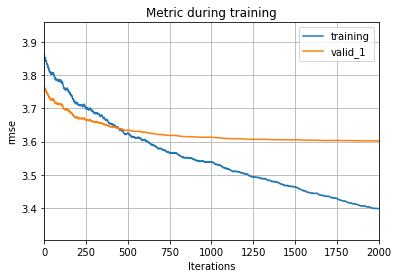

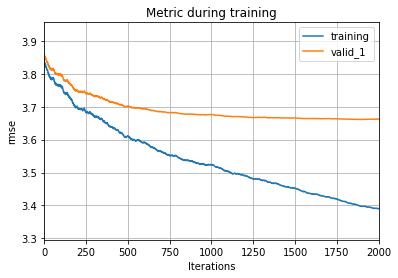

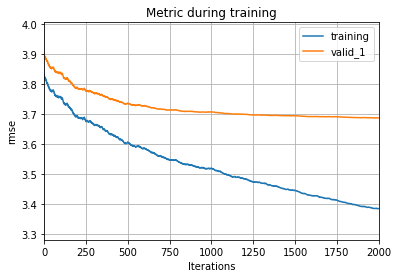

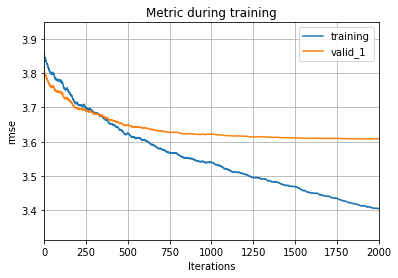

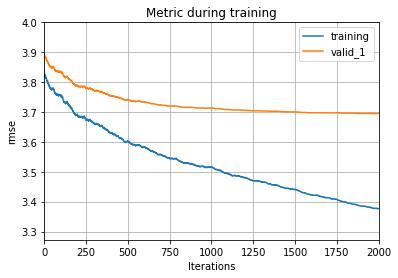

In [813]:
for i in range(5):
    _ = lgb.plot_metric(eval_list[i])

In [814]:
param_dart=param_opt.copy()
param_dart['boosting']='dart'
param_dart['nthread']=4
param_dart['device_type']='gpu'
#param_dart['gpu_use_dp']=True # Let's use single precision only
eval_list=[]
num_fold=5
rmse={}
oof=np.zeros(df.shape[0])
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
    eval_results={}
    trn_data = lgb.Dataset(df[df_train_columns].iloc[trn_idx], label=df.target.iloc[trn_idx])
    val_data = lgb.Dataset(df[df_train_columns].iloc[val_idx], label=df.target.iloc[val_idx])
    clf = lgb.train(param_dart, trn_data, 2000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400,evals_result=eval_results)
    oof[val_idx] = clf.predict(df[df_train_columns].iloc[val_idx], num_iteration=clf.best_iteration)
    eval_list.append(eval_results)
mean_squared_error(df.target, oof)**0.5

[200]	training's rmse: 3.71573	valid_1's rmse: 3.67261
[400]	training's rmse: 3.65327	valid_1's rmse: 3.64485
[600]	training's rmse: 3.6063	valid_1's rmse: 3.62885
[800]	training's rmse: 3.56182	valid_1's rmse: 3.61761
[1000]	training's rmse: 3.53934	valid_1's rmse: 3.61329
[1200]	training's rmse: 3.50364	valid_1's rmse: 3.6079
[1400]	training's rmse: 3.47622	valid_1's rmse: 3.60564
[1600]	training's rmse: 3.44427	valid_1's rmse: 3.60381
[1800]	training's rmse: 3.42035	valid_1's rmse: 3.60278
[2000]	training's rmse: 3.39874	valid_1's rmse: 3.60132
[200]	training's rmse: 3.69857	valid_1's rmse: 3.74954
[400]	training's rmse: 3.63861	valid_1's rmse: 3.71464
[600]	training's rmse: 3.59252	valid_1's rmse: 3.69377
[800]	training's rmse: 3.54761	valid_1's rmse: 3.6804
[1000]	training's rmse: 3.52539	valid_1's rmse: 3.67646
[1200]	training's rmse: 3.49162	valid_1's rmse: 3.66968
[1400]	training's rmse: 3.46468	valid_1's rmse: 3.66734
[1600]	training's rmse: 3.43387	valid_1's rmse: 3.66438
[18

3.6517182773242114

In [815]:
eval_list_dart_gpu_single=eval_list[:]

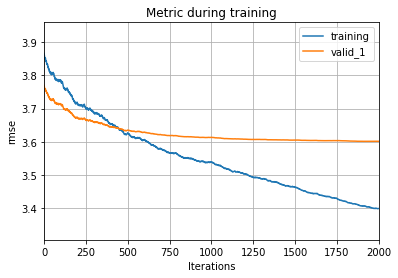

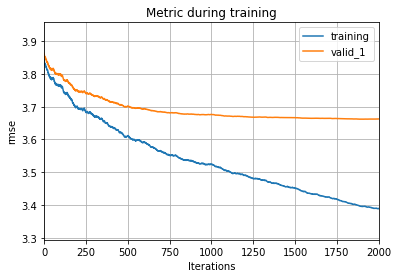

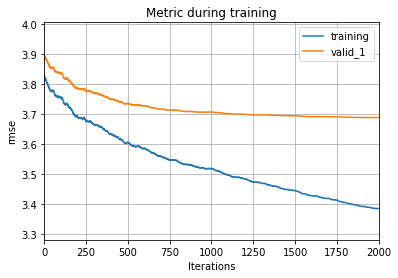

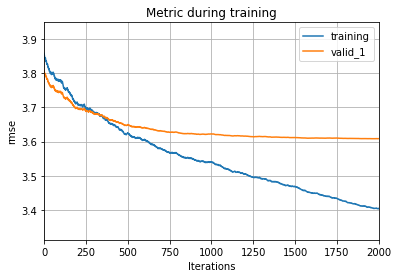

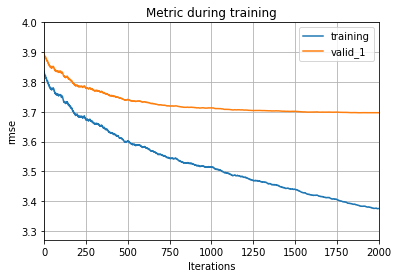

In [816]:
for i in range(5):
    _ = lgb.plot_metric(eval_list[i])

In [817]:
param_dart=param_opt.copy()
param_dart['boosting']='dart'
param_dart['nthread']=4
param_dart['device_type']='gpu'
param_dart['drop_rate']=0.2 # default is 0.1
#param_dart['gpu_use_dp']=True # Let's use single precision only
eval_list=[]
num_fold=5
rmse={}
oof=np.zeros(df.shape[0])
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
    eval_results={}
    trn_data = lgb.Dataset(df[df_train_columns].iloc[trn_idx], label=df.target.iloc[trn_idx])
    val_data = lgb.Dataset(df[df_train_columns].iloc[val_idx], label=df.target.iloc[val_idx])
    clf = lgb.train(param_dart, trn_data, 2000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400,evals_result=eval_results)
    oof[val_idx] = clf.predict(df[df_train_columns].iloc[val_idx], num_iteration=clf.best_iteration)
    eval_list.append(eval_results)
mean_squared_error(df.target, oof)**0.5

[200]	training's rmse: 3.7285	valid_1's rmse: 3.68033
[400]	training's rmse: 3.66415	valid_1's rmse: 3.6495
[600]	training's rmse: 3.60917	valid_1's rmse: 3.63044
[800]	training's rmse: 3.5549	valid_1's rmse: 3.61518
[1000]	training's rmse: 3.51826	valid_1's rmse: 3.60947
[1200]	training's rmse: 3.48951	valid_1's rmse: 3.60628
[1400]	training's rmse: 3.4645	valid_1's rmse: 3.60452
[1600]	training's rmse: 3.42756	valid_1's rmse: 3.60221
[1800]	training's rmse: 3.40902	valid_1's rmse: 3.60165
[2000]	training's rmse: 3.38642	valid_1's rmse: 3.60056
[200]	training's rmse: 3.71147	valid_1's rmse: 3.75817
[400]	training's rmse: 3.64932	valid_1's rmse: 3.72062
[600]	training's rmse: 3.59657	valid_1's rmse: 3.69701
[800]	training's rmse: 3.54091	valid_1's rmse: 3.67945
[1000]	training's rmse: 3.50497	valid_1's rmse: 3.67219
[1200]	training's rmse: 3.47716	valid_1's rmse: 3.66962
[1400]	training's rmse: 3.45247	valid_1's rmse: 3.66706
[1600]	training's rmse: 3.4183	valid_1's rmse: 3.66292
[1800

3.650733253234177

In [818]:
eval_list_dart_gpu_single_drop=eval_list[:]

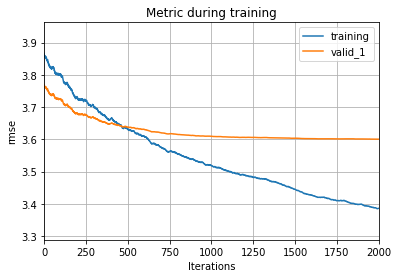

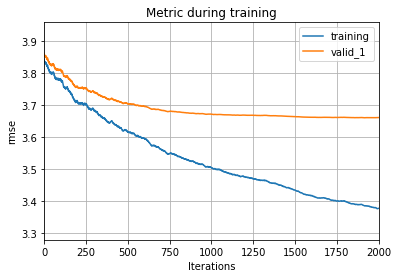

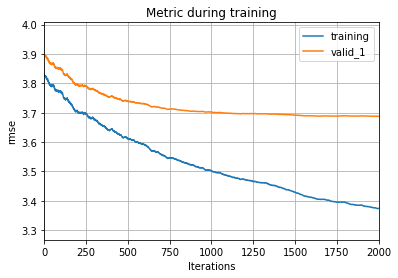

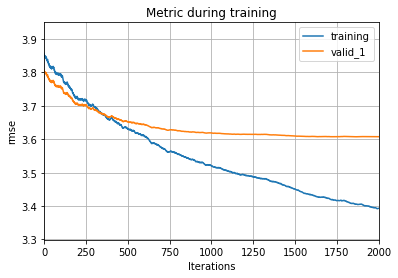

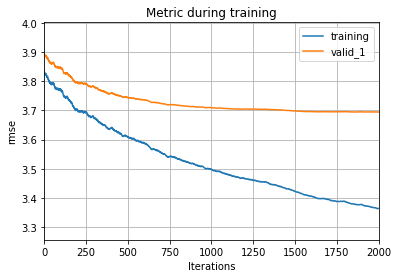

In [819]:
for i in range(5):
    _ = lgb.plot_metric(eval_list[i])

In [820]:
param_dart=param_opt.copy()
param_dart['boosting']='dart'
param_dart['nthread']=4
param_dart['device_type']='gpu'
param_dart['drop_rate']=0.3 # default is 0.1
#param_dart['gpu_use_dp']=True # Let's use single precision only
eval_list=[]
num_fold=5
rmse={}
oof=np.zeros(df.shape[0])
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
    eval_results={}
    trn_data = lgb.Dataset(df[df_train_columns].iloc[trn_idx], label=df.target.iloc[trn_idx])
    val_data = lgb.Dataset(df[df_train_columns].iloc[val_idx], label=df.target.iloc[val_idx])
    clf = lgb.train(param_dart, trn_data, 2000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400,evals_result=eval_results)
    oof[val_idx] = clf.predict(df[df_train_columns].iloc[val_idx], num_iteration=clf.best_iteration)
    eval_list.append(eval_results)
mean_squared_error(df.target, oof)**0.5

[200]	training's rmse: 3.72832	valid_1's rmse: 3.67974
[400]	training's rmse: 3.65458	valid_1's rmse: 3.64625
[600]	training's rmse: 3.59306	valid_1's rmse: 3.62812
[800]	training's rmse: 3.55587	valid_1's rmse: 3.6183
[1000]	training's rmse: 3.51267	valid_1's rmse: 3.61019
[1200]	training's rmse: 3.47702	valid_1's rmse: 3.60547
[1400]	training's rmse: 3.44855	valid_1's rmse: 3.60299
[1600]	training's rmse: 3.41754	valid_1's rmse: 3.60103
[1800]	training's rmse: 3.39228	valid_1's rmse: 3.59986
[2000]	training's rmse: 3.36355	valid_1's rmse: 3.59862
[200]	training's rmse: 3.7112	valid_1's rmse: 3.75853
[400]	training's rmse: 3.64103	valid_1's rmse: 3.71651
[600]	training's rmse: 3.58091	valid_1's rmse: 3.69128
[800]	training's rmse: 3.54227	valid_1's rmse: 3.68114
[1000]	training's rmse: 3.499	valid_1's rmse: 3.67167
[1200]	training's rmse: 3.46487	valid_1's rmse: 3.66708
[1400]	training's rmse: 3.43556	valid_1's rmse: 3.66544
[1600]	training's rmse: 3.40635	valid_1's rmse: 3.66351
[180

3.649309639539765

In [821]:
eval_list_dart_gpu_single_drop2=eval_list[:]

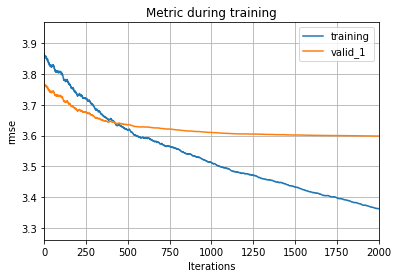

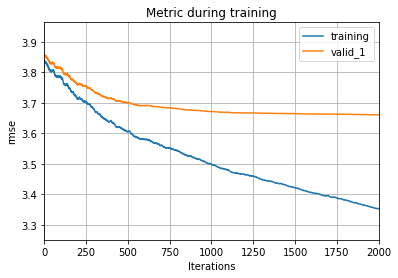

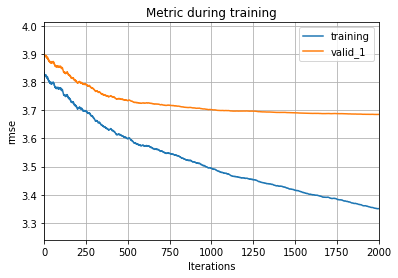

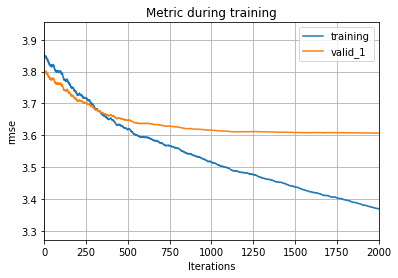

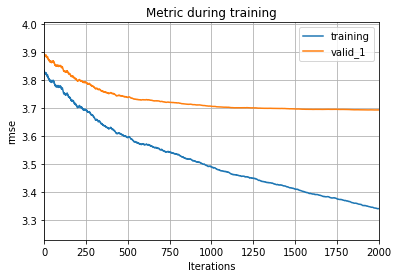

In [822]:
for i in range(5):
    _ = lgb.plot_metric(eval_list[i])

In [823]:
param_dart=param_opt.copy()
param_dart['boosting']='dart'
param_dart['nthread']=4
param_dart['device_type']='gpu'
param_dart['drop_rate']=0.4 # default is 0.1
#param_dart['gpu_use_dp']=True # Let's use single precision only
eval_list=[]
num_fold=5
rmse={}
oof=np.zeros(df.shape[0])
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
    eval_results={}
    trn_data = lgb.Dataset(df[df_train_columns].iloc[trn_idx], label=df.target.iloc[trn_idx])
    val_data = lgb.Dataset(df[df_train_columns].iloc[val_idx], label=df.target.iloc[val_idx])
    clf = lgb.train(param_dart, trn_data, 2000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400,evals_result=eval_results)
    oof[val_idx] = clf.predict(df[df_train_columns].iloc[val_idx], num_iteration=clf.best_iteration)
    eval_list.append(eval_results)
mean_squared_error(df.target, oof)**0.5

[200]	training's rmse: 3.75751	valid_1's rmse: 3.69784
[400]	training's rmse: 3.66417	valid_1's rmse: 3.65063
[600]	training's rmse: 3.61103	valid_1's rmse: 3.63229
[800]	training's rmse: 3.56983	valid_1's rmse: 3.6219
[1000]	training's rmse: 3.51868	valid_1's rmse: 3.61131
[1200]	training's rmse: 3.48569	valid_1's rmse: 3.60753
[1400]	training's rmse: 3.4616	valid_1's rmse: 3.6058
[1600]	training's rmse: 3.42772	valid_1's rmse: 3.60335
[1800]	training's rmse: 3.39706	valid_1's rmse: 3.60079
[2000]	training's rmse: 3.37041	valid_1's rmse: 3.59917
[200]	training's rmse: 3.73947	valid_1's rmse: 3.77945
[400]	training's rmse: 3.6489	valid_1's rmse: 3.72064
[600]	training's rmse: 3.5975	valid_1's rmse: 3.69749
[800]	training's rmse: 3.5575	valid_1's rmse: 3.68425
[1000]	training's rmse: 3.50755	valid_1's rmse: 3.67144
[1200]	training's rmse: 3.47588	valid_1's rmse: 3.66839
[1400]	training's rmse: 3.45234	valid_1's rmse: 3.66567
[1600]	training's rmse: 3.41991	valid_1's rmse: 3.66222
[1800]

3.6491752667345203

In [824]:
eval_list_dart_gpu_single_drop3=eval_list[:]

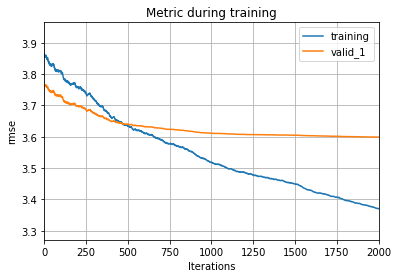

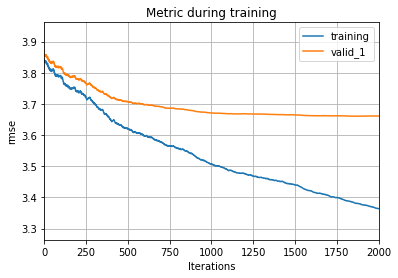

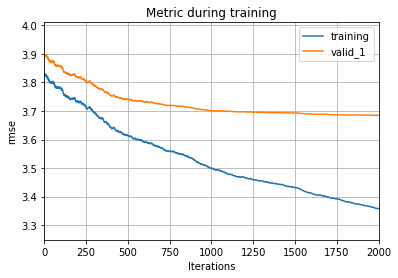

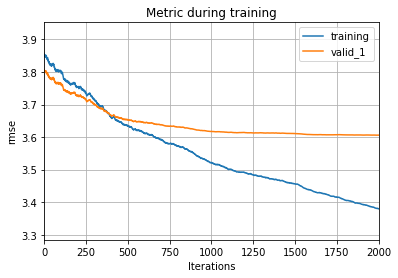

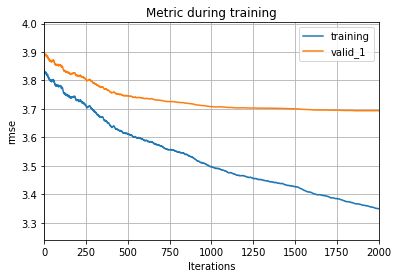

In [825]:
for i in range(5):
    _ = lgb.plot_metric(eval_list[i])

In [760]:
# param_dart=param_opt.copy()
# param_dart['boosting']='dart'
eval_list=[]
num_fold=5
rmse={}
oof=np.zeros(df.shape[0])
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
    eval_results={}
    trn_data = lgb.Dataset(df[df_train_columns].iloc[trn_idx], label=df.target.iloc[trn_idx])
    val_data = lgb.Dataset(df[df_train_columns].iloc[val_idx], label=df.target.iloc[val_idx])
    clf = lgb.train(param_opt, trn_data, 2000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400,evals_result=eval_results)
    oof[val_idx] = clf.predict(df[df_train_columns].iloc[val_idx], num_iteration=clf.best_iteration)
    eval_list.append(eval_results)
mean_squared_error(df.target, oof)**0.5

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.57417	valid_1's rmse: 3.61829
[400]	training's rmse: 3.48915	valid_1's rmse: 3.60454
[600]	training's rmse: 3.43699	valid_1's rmse: 3.60038
[800]	training's rmse: 3.39353	valid_1's rmse: 3.59886
[1000]	training's rmse: 3.35349	valid_1's rmse: 3.59842
[1200]	training's rmse: 3.31684	valid_1's rmse: 3.59834
[1400]	training's rmse: 3.28176	valid_1's rmse: 3.59883
Early stopping, best iteration is:
[1063]	training's rmse: 3.34124	valid_1's rmse: 3.59806
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.5615	valid_1's rmse: 3.67904
[400]	training's rmse: 3.4782	valid_1's rmse: 3.6629
[600]	training's rmse: 3.42541	valid_1's rmse: 3.65903
[800]	training's rmse: 3.38395	valid_1's rmse: 3.6573
[1000]	training's rmse: 3.34545	valid_1's rmse: 3.65662
[1200]	training's rmse: 3.30965	valid_1's rmse: 3.65682
[1400]	training's rmse: 3.27477	valid_1's rmse: 3.65694
Early stopp

3.64486405058755

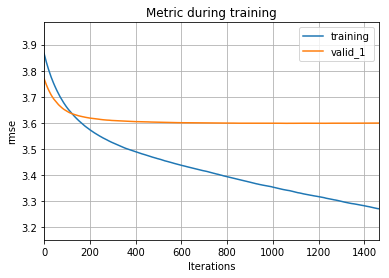

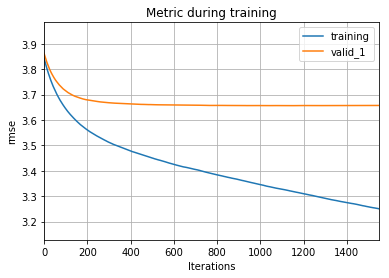

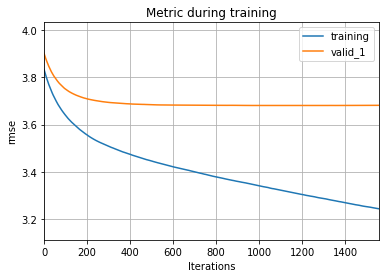

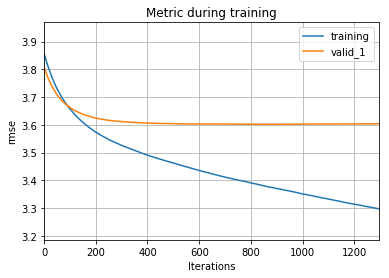

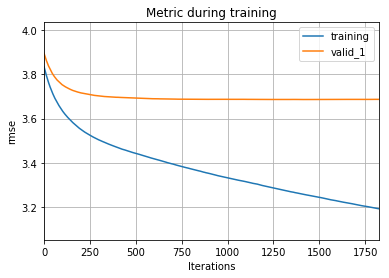

In [762]:
eval_list_gbdt=eval_list[:]
for i in range(5):
    _ = lgb.plot_metric(eval_list_gbdt[i])

In [782]:
train_data=lgb.Dataset(df_train[df_train_columns],label=df_train.target)
lg_cv=lgb.cv(param_dart,train_data,5000,verbose_eval=200,early_stopping_rounds=400,stratified=False)
    

[200]	cv_agg's rmse: 3.7396 + 0.0309926
[400]	cv_agg's rmse: 3.70581 + 0.0301843
[600]	cv_agg's rmse: 3.68574 + 0.0289123
[800]	cv_agg's rmse: 3.67155 + 0.0283527
[1000]	cv_agg's rmse: 3.66724 + 0.0277384
[1200]	cv_agg's rmse: 3.66047 + 0.0274107
[1400]	cv_agg's rmse: 3.65676 + 0.0269626
[1600]	cv_agg's rmse: 3.65298 + 0.0266088
[1800]	cv_agg's rmse: 3.65118 + 0.0263329
[2000]	cv_agg's rmse: 3.65035 + 0.0264972
[2200]	cv_agg's rmse: 3.64994 + 0.0259047
[2400]	cv_agg's rmse: 3.64924 + 0.0258467
[2600]	cv_agg's rmse: 3.64802 + 0.0254431
[2800]	cv_agg's rmse: 3.64722 + 0.0250099
[3000]	cv_agg's rmse: 3.647 + 0.0248301
[3200]	cv_agg's rmse: 3.64676 + 0.024977
[3400]	cv_agg's rmse: 3.64633 + 0.0248226
[3600]	cv_agg's rmse: 3.64663 + 0.0248452
[3800]	cv_agg's rmse: 3.64645 + 0.0247749
[4000]	cv_agg's rmse: 3.64664 + 0.0249514
[4200]	cv_agg's rmse: 3.64663 + 0.0246695
[4400]	cv_agg's rmse: 3.64693 + 0.0244546
[4600]	cv_agg's rmse: 3.64701 + 0.0242198
[4800]	cv_agg's rmse: 3.647 + 0.0242284
[5

In [788]:
lg_cv['rmse-mean'].index(min(lg_cv['rmse-mean']))

3401

In [779]:
param_goss=param_opt.copy()
param_goss['boosting']='goss'
## can't imput bagging
del param_goss['bagging_freq']
del param_goss['bagging_fraction']
del param_goss['bagging_seed']
eval_list=[]
num_fold=5
rmse={}
oof=np.zeros(df.shape[0])
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
    eval_results={}
    trn_data = lgb.Dataset(df[df_train_columns].iloc[trn_idx], label=df.target.iloc[trn_idx])
    val_data = lgb.Dataset(df[df_train_columns].iloc[val_idx], label=df.target.iloc[val_idx])
    clf = lgb.train(param_goss, trn_data, 2000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400,evals_result=eval_results)
    oof[val_idx] = clf.predict(df[df_train_columns].iloc[val_idx], num_iteration=clf.best_iteration)
    eval_list.append(eval_results)
mean_squared_error(df.target, oof)**0.5

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.54672	valid_1's rmse: 3.61271
[400]	training's rmse: 3.45266	valid_1's rmse: 3.61221
[600]	training's rmse: 3.37355	valid_1's rmse: 3.61978
Early stopping, best iteration is:
[280]	training's rmse: 3.50424	valid_1's rmse: 3.60819
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.53736	valid_1's rmse: 3.67758
[400]	training's rmse: 3.44776	valid_1's rmse: 3.67172
[600]	training's rmse: 3.37808	valid_1's rmse: 3.67573
Early stopping, best iteration is:
[384]	training's rmse: 3.45449	valid_1's rmse: 3.6698
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.53136	valid_1's rmse: 3.70776
[400]	training's rmse: 3.43879	valid_1's rmse: 3.70447
[600]	training's rmse: 3.3674	valid_1's rmse: 3.70513
Early stopping, best iteration is:
[284]	training's rmse: 3.48792	valid_1's rmse: 3.70259
Training until validation scores don't improve f

3.661254655760098

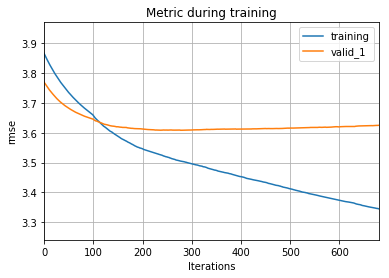

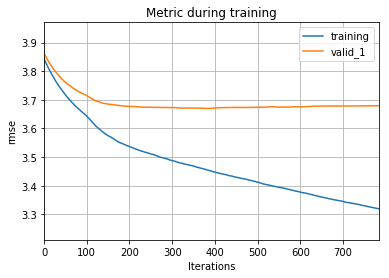

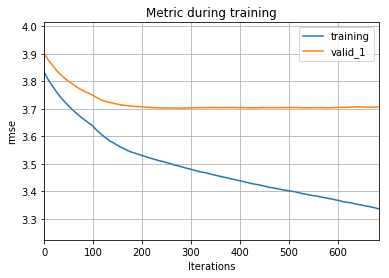

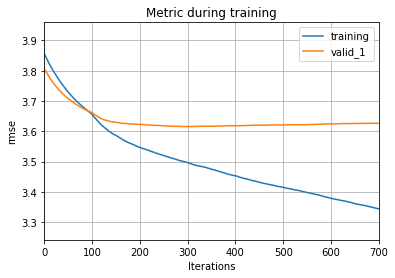

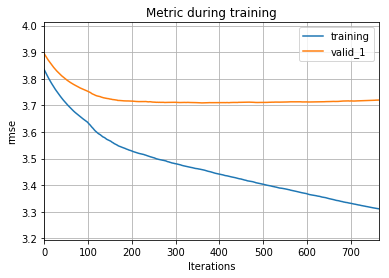

In [780]:
eval_list_goss=eval_list[:]
for i in range(5):
    _ = lgb.plot_metric(eval_list_goss[i])

In [653]:
lgb_cv = lgb.cv(param_opt, trn_data, 10000, stratified=False, early_stopping_rounds=600, verbose_eval=200)
print(f'best cv score: {lgb_cv["rmse-mean"][-1]}\nbest boost nums: {len(lgb_cv["rmse-mean"])}')

{'rmse-mean': [3.846570712131599,
  3.8439927278568975,
  3.8413791533895463,
  3.838768624082058,
  3.8362358328126724,
  3.8337125201874755,
  3.8310760046348813,
  3.8286017456923553,
  3.826242017788426,
  3.823915162567179,
  3.821627918854129,
  3.8193687064989303,
  3.8171178248003033,
  3.8148989944573763,
  3.812556207967746,
  3.81052278667482,
  3.8083641207667425,
  3.806278397283535,
  3.804176850160469,
  3.8021914355928543,
  3.8002037551366596,
  3.7983324305761395,
  3.7964603535909873,
  3.794617665514403,
  3.7928764379778954,
  3.7910903628883346,
  3.7893081393266086,
  3.787462817549012,
  3.785719925330831,
  3.783962116203488,
  3.7822622938499095,
  3.7807148252021214,
  3.779095918106587,
  3.7774611147034762,
  3.7759224603847423,
  3.7744311936009383,
  3.7729293964759085,
  3.771360676491151,
  3.7698497949049967,
  3.768421148693553,
  3.766994049348021,
  3.7656752246369165,
  3.7642769377459047,
  3.762915509934244,
  3.7616154448540917,
  3.760358891202

In [649]:
num_fold=10
train,test=train_test_split(df_train,stratify=df_train.outliers,test_size=0.2,)
rmse={}
train_idx=[]
folds = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=4950)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train[df_train_columns], train['outliers'])):
    print(f'fold: {fold_}')
    train_idx+=list(val_idx) # add more data in each round
    print(len(train_idx))
    trn_data = lgb.Dataset(train[df_train_columns].iloc[train_idx], label=train.target.iloc[train_idx])
    val_data = lgb.Dataset(test[df_train_columns], label=test.target)
    clf = lgb.train(param_opt, trn_data, 10000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400)
    oof = clf.predict(test[df_train_columns], num_iteration=clf.best_iteration)
    rmse[fold_]=mean_squared_error(test.target, oof)**0.5

0       17.965068
1       17.675716
0       15.606405
1       15.994455
0       15.294621
1       14.855160
2       15.171020
3       15.011358
0       13.592223
1       13.602322
2       13.609871
0       12.970394
1       13.350895
2       13.310613
3       12.743993
0       11.606558
1       12.446308
2       11.886459
3       11.759035
4       11.542822
5       11.553597
6       12.446566
7       11.601576
8       12.446049
9       12.385323
0       10.832827
1       10.774194
2       11.315665
3       10.571836
4       11.333782
          ...    
2177   -33.219281
2178   -33.219281
2179   -33.219281
2180   -33.219281
2181   -33.219281
2182   -33.219281
2183   -33.219281
2184   -33.219281
2185   -33.219281
2186   -33.219281
2187   -33.219281
2188   -33.219281
2189   -33.219281
2190   -33.219281
2191   -33.219281
2192   -33.219281
2193   -33.219281
2194   -33.219281
2195   -33.219281
2196   -33.219281
2197   -33.219281
2198   -33.219281
2199   -33.219281
2200   -33.219281
2201   -33

# We have a lot of features. Let's try to eliminate features  again. Using my previous methods.


## Before doing anything , I want to check what will happen if I shuffle target. Will it still able to fit?

In [829]:
# param_dart=param_opt.copy()
# param_dart['boosting']='dart'
eval_list=[]
num_fold=5
rmse={}
oof=np.zeros(df.shape[0])
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)
target=df.target.sample(frac=1,random_state=4950)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
    eval_results={}
    trn_data = lgb.Dataset(df[df_train_columns].iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df[df_train_columns].iloc[val_idx], label=target.iloc[val_idx])
    clf = lgb.train(param_opt, trn_data, 2000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400,evals_result=eval_results)
    oof[val_idx] = clf.predict(df[df_train_columns].iloc[val_idx], num_iteration=clf.best_iteration)
    eval_list.append(eval_results)
mean_squared_error(target, oof)**0.5

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.7967	valid_1's rmse: 3.94517
[400]	training's rmse: 3.7718	valid_1's rmse: 3.94618
Early stopping, best iteration is:
[2]	training's rmse: 3.8262	valid_1's rmse: 3.9442
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.81112	valid_1's rmse: 3.88755
[400]	training's rmse: 3.78779	valid_1's rmse: 3.88835
Early stopping, best iteration is:
[10]	training's rmse: 3.83924	valid_1's rmse: 3.88648
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.81356	valid_1's rmse: 3.87736
[400]	training's rmse: 3.78874	valid_1's rmse: 3.87778
Early stopping, best iteration is:
[182]	training's rmse: 3.81593	valid_1's rmse: 3.87726
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.85448	valid_1's rmse: 3.7022
[400]	training's rmse: 3.82893	valid_1's rmse: 3.70359
Early stopping, best iteration is:
[3]	trainin

3.850451002309258

In [830]:
# param_dart=param_opt.copy()
# param_dart['boosting']='dart'
eval_list=[]
num_fold=5
rmse={}
oof=np.zeros(df.shape[0])
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)
target=df.target.sample(frac=1,random_state=4950)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
    eval_results={}
    trn_data = lgb.Dataset(df[df_train_columns].iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df[df_train_columns].iloc[val_idx], label=target.iloc[val_idx])
    clf = lgb.train(param, trn_data, 2000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400,evals_result=eval_results)
    oof[val_idx] = clf.predict(df[df_train_columns].iloc[val_idx], num_iteration=clf.best_iteration)
    eval_list.append(eval_results)
mean_squared_error(target, oof)**0.5

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.79442	valid_1's rmse: 3.94522
[400]	training's rmse: 3.76596	valid_1's rmse: 3.94628
Early stopping, best iteration is:
[11]	training's rmse: 3.82464	valid_1's rmse: 3.9441
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.8092	valid_1's rmse: 3.88709
[400]	training's rmse: 3.78037	valid_1's rmse: 3.88775
Early stopping, best iteration is:
[33]	training's rmse: 3.83538	valid_1's rmse: 3.88648
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.8114	valid_1's rmse: 3.87759
[400]	training's rmse: 3.78365	valid_1's rmse: 3.87812
Early stopping, best iteration is:
[29]	training's rmse: 3.83866	valid_1's rmse: 3.87743
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.85374	valid_1's rmse: 3.70201
[400]	training's rmse: 3.82447	valid_1's rmse: 3.70328
Early stopping, best iteration is:
[13]	trai

3.8504682429618446

In [834]:
# param_dart=param_opt.copy()
# param_dart['boosting']='dart'
param_rf=param.copy()
param_rf['boosting']='rf'
eval_list=[]
num_fold=5
rmse={}
oof=np.zeros(df.shape[0])
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)
target=df.target.sample(frac=1,random_state=4950)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
    eval_results={}
    trn_data = lgb.Dataset(df[df_train_columns].iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df[df_train_columns].iloc[val_idx], label=target.iloc[val_idx])
    clf = lgb.train(param_rf, trn_data, 2000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400,evals_result=eval_results)
    oof[val_idx] = clf.predict(df[df_train_columns].iloc[val_idx], num_iteration=clf.best_iteration)
    eval_list.append(eval_results)
mean_squared_error(target, oof)**0.5

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.80897	valid_1's rmse: 3.94453
[400]	training's rmse: 3.80899	valid_1's rmse: 3.94447
Early stopping, best iteration is:
[14]	training's rmse: 3.80944	valid_1's rmse: 3.94394
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.82369	valid_1's rmse: 3.88735
[400]	training's rmse: 3.82365	valid_1's rmse: 3.88745
Early stopping, best iteration is:
[15]	training's rmse: 3.82335	valid_1's rmse: 3.8881
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.82658	valid_1's rmse: 3.87783
[400]	training's rmse: 3.82659	valid_1's rmse: 3.87772
Early stopping, best iteration is:
[9]	training's rmse: 3.82732	valid_1's rmse: 3.87755
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.8693	valid_1's rmse: 3.70175
[400]	training's rmse: 3.86937	valid_1's rmse: 3.7018
Early stopping, best iteration is:
[118]	trai

3.851252033622219

In [835]:


# lets use goss here
eval_list=[]
num_fold=5
rmse={}
oof=np.zeros(df.shape[0])
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)
target=df.target.sample(frac=1,random_state=4950)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
    eval_results={}
    trn_data = lgb.Dataset(df[df_train_columns].iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df[df_train_columns].iloc[val_idx], label=target.iloc[val_idx])
    clf = lgb.train(param_goss, trn_data, 2000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400,evals_result=eval_results)
    oof[val_idx] = clf.predict(df[df_train_columns].iloc[val_idx], num_iteration=clf.best_iteration)
    eval_list.append(eval_results)
mean_squared_error(target, oof)**0.5

Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 4225.59	valid_1's rmse: 4194.69
[400]	training's rmse: 717.341	valid_1's rmse: 737.736
Early stopping, best iteration is:
[2]	training's rmse: 3.82622	valid_1's rmse: 3.94418
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 754.675	valid_1's rmse: 756.398
[400]	training's rmse: 1.3289e+18	valid_1's rmse: 1.32976e+18
Early stopping, best iteration is:
[10]	training's rmse: 3.83929	valid_1's rmse: 3.88644
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 158.129	valid_1's rmse: 156.647
[400]	training's rmse: 29.0887	valid_1's rmse: 29.7681
Early stopping, best iteration is:
[91]	training's rmse: 3.82838	valid_1's rmse: 3.87724
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 4.67101e+10	valid_1's rmse: 4.70753e+10
[400]	training's rmse: 7.93907e+09	valid_1's rmse: 8.24286e+09
Early stopping, bes

3.8504413055655338

In [839]:
clf.current_iteration()

200

In [ ]:
# param_dart['boosting']='dart'
param_rf=param.copy()
param_rf['boosting']='rf'
eval_list=[]
num_fold=5
rmse={}
oof=np.zeros(df.shape[0])
folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)
target=df.target.sample(frac=1,random_state=4950)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
    eval_results={}
    trn_data = lgb.Dataset(df[df_train_columns].iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df[df_train_columns].iloc[val_idx], label=target.iloc[val_idx])
    clf = lgb.train(param, trn_data, 2000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=400,evals_result=eval_results)
    oof[val_idx] = clf.predict(df[df_train_columns].iloc[val_idx], num_iteration=clf.best_iteration)
    eval_list.append(eval_results)
mean_squared_error(target, oof)**0.5

In [847]:
# Select relevant features
exclude_features = []
exclude_features += ['card_id', 'first_active_month','target','outliers']
df_train_columns_all = [c for c in df_train.columns if c not in exclude_features ]
target = df_train['target']
#del df_train['target']

In [850]:
len(df_train_columns_all)
#len(exclude_features)

309

In [842]:
folds.n_splits

5

In [852]:
def get_feature_importances(data, shuffle, param,columns,seed=None):
    # Gather real features
    #train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['target'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data.loc[:,columns], y, free_raw_data=False, silent=True)
    oof=np.zeros(data.shape[0])
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(columns)
    imp_df["importance_gain"]=0
    imp_df["importance_split"]=0
    folds = KFold(n_splits=num_fold, shuffle=True, random_state=4950)
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df[df_train_columns])):
        # Train and valid set
        trn_data = lgb.Dataset(data[columns].iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lgb.Dataset(data[columns].iloc[val_idx], label=y.iloc[val_idx])
        clf = lgb.train(param, trn_data, 2000, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=200)
        oof[val_idx] = clf.predict(data[columns].iloc[val_idx], num_iteration=clf.best_iteration)
        imp_df["importance_gain"] += clf.feature_importance(importance_type='gain')/folds.n_splits
        imp_df["importance_split"] += clf.feature_importance(importance_type='split')/folds.n_splits

    
    imp_df['trn_score']=np.sqrt(mean_squared_error(y, oof))
    
    return imp_df

In [853]:
param_elim=param_opt.copy()
param_elim['nthread']=4
param_elim['device_type']='gpu'

In [854]:
# Seed the unexpected randomness of this world
np.random.seed(4950)
# 
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=df_train, shuffle=False,param=param_elim,columns=df_train_columns)
# 

Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.55893	valid_1's rmse: 3.6785
[400]	training's rmse: 3.4776	valid_1's rmse: 3.66086
[600]	training's rmse: 3.42293	valid_1's rmse: 3.65661
[800]	training's rmse: 3.37583	valid_1's rmse: 3.65483
[1000]	training's rmse: 3.33486	valid_1's rmse: 3.65374
[1200]	training's rmse: 3.29785	valid_1's rmse: 3.65449
Early stopping, best iteration is:
[1016]	training's rmse: 3.33191	valid_1's rmse: 3.65355
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.52553	valid_1's rmse: 3.82133
[400]	training's rmse: 3.44148	valid_1's rmse: 3.80079
[600]	training's rmse: 3.38939	valid_1's rmse: 3.79437
[800]	training's rmse: 3.34607	valid_1's rmse: 3.79229
[1000]	training's rmse: 3.30967	valid_1's rmse: 3.79169
[1200]	training's rmse: 3.27229	valid_1's rmse: 3.79134
[1400]	training's rmse: 3.23741	valid_1's rmse: 3.79114
[1600]	training's rmse: 3.20375	valid_1's rmse: 3.7908
[1800]	tra

In [855]:
actual_imp_df.sort_values('importance_split',ascending=False).head()


,feature,importance_gain,importance_split,trn_score
63,auth_hist_month_diff_mean,1.177182e+06,2008.8,3.643086
117,hist_month_diff_mean,1.354607e+06,1530.2,3.643086
56,auth_hist_purchase_date_max,4.472777e+05,1468.2,3.643086
197,new_hist_purchase_date_uptonow,1.019501e+06,1278.2,3.643086
153,new_hist_purchase_amount_max,7.923253e+05,1249.6,3.643086


In [857]:
import time


In [858]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=df_train, shuffle=True,param=param_elim,columns=df_train_columns)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.8036	valid_1's rmse: 3.91164
Early stopping, best iteration is:
[1]	training's rmse: 3.83518	valid_1's rmse: 3.9105
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.80198	valid_1's rmse: 3.92045
Early stopping, best iteration is:
[32]	training's rmse: 3.82791	valid_1's rmse: 3.91944
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.85752	valid_1's rmse: 3.69907
Early stopping, best iteration is:
[4]	training's rmse: 3.88688	valid_1's rmse: 3.69843
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.81247	valid_1's rmse: 3.88296
Early stopping, best iteration is:
[40]	training's rmse: 3.83565	valid_1's rmse: 3.88231
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.8195	valid_1's rmse: 3.83891
Early stopping, best iteration is:
[1]	training's rmse: 3.8

Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.82675	valid_1's rmse: 3.81186
Early stopping, best iteration is:
[4]	training's rmse: 3.85961	valid_1's rmse: 3.81082
Done with    8 of   80 (Spent   6.8 min)Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.81478	valid_1's rmse: 3.87289
Early stopping, best iteration is:
[26]	training's rmse: 3.84075	valid_1's rmse: 3.87227
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.82986	valid_1's rmse: 3.80455
Early stopping, best iteration is:
[18]	training's rmse: 3.85863	valid_1's rmse: 3.80381
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.83735	valid_1's rmse: 3.77719
Early stopping, best iteration is:
[1]	training's rmse: 3.86864	valid_1's rmse: 3.77619
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.7964	valid_1's rmse: 3.94251
Early stopping, b

Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.82483	valid_1's rmse: 3.83062
Early stopping, best iteration is:
[56]	training's rmse: 3.84702	valid_1's rmse: 3.83011
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.82736	valid_1's rmse: 3.80341
Early stopping, best iteration is:
[3]	training's rmse: 3.8619	valid_1's rmse: 3.80226
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.81743	valid_1's rmse: 3.84724
Early stopping, best iteration is:
[4]	training's rmse: 3.85079	valid_1's rmse: 3.84595
Done with   16 of   80 (Spent  13.6 min)Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.83455	valid_1's rmse: 3.79303
Early stopping, best iteration is:
[18]	training's rmse: 3.862	valid_1's rmse: 3.79222
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.8368	valid_1's rmse: 3.80043
Early stopping, best

[200]	training's rmse: 3.83449	valid_1's rmse: 3.78778
Early stopping, best iteration is:
[71]	training's rmse: 3.85314	valid_1's rmse: 3.78738
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.83969	valid_1's rmse: 3.77428
Early stopping, best iteration is:
[49]	training's rmse: 3.86173	valid_1's rmse: 3.77378
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.79945	valid_1's rmse: 3.92366
Early stopping, best iteration is:
[2]	training's rmse: 3.83187	valid_1's rmse: 3.92253
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.79367	valid_1's rmse: 3.93864
Early stopping, best iteration is:
[5]	training's rmse: 3.82722	valid_1's rmse: 3.93815
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.82221	valid_1's rmse: 3.82807
Early stopping, best iteration is:
[5]	training's rmse: 3.85512	valid_1's rmse: 3.82763
Done with   24 of   80 (Spent  

Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.83009	valid_1's rmse: 3.82082
Early stopping, best iteration is:
[24]	training's rmse: 3.85378	valid_1's rmse: 3.82036
Done with   31 of   80 (Spent  26.1 min)Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.83987	valid_1's rmse: 3.77278
Early stopping, best iteration is:
[6]	training's rmse: 3.86895	valid_1's rmse: 3.77225
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.79763	valid_1's rmse: 3.93815
Early stopping, best iteration is:
[1]	training's rmse: 3.82836	valid_1's rmse: 3.93731
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.83328	valid_1's rmse: 3.80682
Early stopping, best iteration is:
[14]	training's rmse: 3.85974	valid_1's rmse: 3.80636
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.81667	valid_1's rmse: 3.87908
Early stopping, 

[200]	training's rmse: 3.80733	valid_1's rmse: 3.89884
Early stopping, best iteration is:
[38]	training's rmse: 3.83209	valid_1's rmse: 3.89833
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.83446	valid_1's rmse: 3.79862
Early stopping, best iteration is:
[5]	training's rmse: 3.86259	valid_1's rmse: 3.79807
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.82043	valid_1's rmse: 3.85172
Early stopping, best iteration is:
[6]	training's rmse: 3.84962	valid_1's rmse: 3.85061
Done with   39 of   80 (Spent  32.7 min)Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.79832	valid_1's rmse: 3.93888
Early stopping, best iteration is:
[7]	training's rmse: 3.82711	valid_1's rmse: 3.93814
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.82241	valid_1's rmse: 3.83735
Early stopping, best iteration is:
[19]	training's rmse: 3.85056	valid_1's rmse:

Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.81829	valid_1's rmse: 3.85702
Early stopping, best iteration is:
[10]	training's rmse: 3.84718	valid_1's rmse: 3.85609
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.82199	valid_1's rmse: 3.83871
Early stopping, best iteration is:
[9]	training's rmse: 3.85192	valid_1's rmse: 3.83792
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.83034	valid_1's rmse: 3.81031
Early stopping, best iteration is:
[1]	training's rmse: 3.86053	valid_1's rmse: 3.80932
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.8084	valid_1's rmse: 3.89721
Early stopping, best iteration is:
[10]	training's rmse: 3.83695	valid_1's rmse: 3.89637
Done with   47 of   80 (Spent  39.4 min)Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.82362	valid_1's rmse: 3.82485
Early stopping, b

Early stopping, best iteration is:
[12]	training's rmse: 3.84234	valid_1's rmse: 3.87431
Done with   54 of   80 (Spent  45.3 min)Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.78577	valid_1's rmse: 3.98977
Early stopping, best iteration is:
[29]	training's rmse: 3.81017	valid_1's rmse: 3.98926
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.83	valid_1's rmse: 3.80851
Early stopping, best iteration is:
[29]	training's rmse: 3.85538	valid_1's rmse: 3.80794
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.81168	valid_1's rmse: 3.87876
Early stopping, best iteration is:
[7]	training's rmse: 3.84243	valid_1's rmse: 3.87739
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.84617	valid_1's rmse: 3.73947
Early stopping, best iteration is:
[5]	training's rmse: 3.87681	valid_1's rmse: 3.73833
Training until validation scores don't improve f

Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.8373	valid_1's rmse: 3.77934
Early stopping, best iteration is:
[2]	training's rmse: 3.86798	valid_1's rmse: 3.77798
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.82257	valid_1's rmse: 3.82694
Early stopping, best iteration is:
[1]	training's rmse: 3.85641	valid_1's rmse: 3.82586
Done with   62 of   80 (Spent  51.8 min)Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.81177	valid_1's rmse: 3.87313
Early stopping, best iteration is:
[1]	training's rmse: 3.84485	valid_1's rmse: 3.87193
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.81577	valid_1's rmse: 3.87008
Early stopping, best iteration is:
[9]	training's rmse: 3.84399	valid_1's rmse: 3.86925
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.82518	valid_1's rmse: 3.82256
Early stopping, bes

[200]	training's rmse: 3.82513	valid_1's rmse: 3.82198
Early stopping, best iteration is:
[23]	training's rmse: 3.85322	valid_1's rmse: 3.82153
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.82267	valid_1's rmse: 3.84591
Early stopping, best iteration is:
[2]	training's rmse: 3.85151	valid_1's rmse: 3.84505
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.82302	valid_1's rmse: 3.83818
Early stopping, best iteration is:
[102]	training's rmse: 3.8366	valid_1's rmse: 3.83783
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.80981	valid_1's rmse: 3.89358
Early stopping, best iteration is:
[1]	training's rmse: 3.83976	valid_1's rmse: 3.8926
Done with   70 of   80 (Spent  58.2 min)Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.81064	valid_1's rmse: 3.87692
Early stopping, best iteration is:
[3]	training's rmse: 3.84352	valid_1's rmse: 

Done with   77 of   80 (Spent  64.0 min)Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.83368	valid_1's rmse: 3.78511
[400]	training's rmse: 3.80815	valid_1's rmse: 3.78514
Early stopping, best iteration is:
[253]	training's rmse: 3.82645	valid_1's rmse: 3.78495
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.78949	valid_1's rmse: 3.97035
Early stopping, best iteration is:
[1]	training's rmse: 3.82007	valid_1's rmse: 3.96909
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.8103	valid_1's rmse: 3.88436
Early stopping, best iteration is:
[11]	training's rmse: 3.84006	valid_1's rmse: 3.88333
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.83259	valid_1's rmse: 3.78964
Early stopping, best iteration is:
[3]	training's rmse: 3.86521	valid_1's rmse: 3.7889
Training until validation scores don't improve for 200 rounds.
[200]	training's 

In [859]:
# Save importances just in case
null_imp_df.to_csv('null_importances_distribution_new.csv')
actual_imp_df.to_csv('actual_importances_ditribution_new.csv')

In [860]:
import matplotlib.gridspec as gridspec
import seaborn as sns

In [866]:
null_imp_df.groupby('feature').mean().sort_values('importance_split',ascending=False).head(20)

,importance_gain,importance_split,trn_score,run
feature,,,,
new_hist_merchant_id_sum_sum,2360.148181,11.0625,3.850466,40.5
auth_hist_weekend_mean,2286.538347,10.9275,3.850466,40.5
hist_merchant_id_mean_mean,2273.983998,10.7325,3.850466,40.5
new_hist_merchant_category_id_mean_mean,1989.369205,9.3400,3.850466,40.5
hist_merchant_category_id_mean_mean,2033.606013,9.3350,3.850466,40.5
hist_merchant_id_sum_sum,2044.625643,9.2675,3.850466,40.5
auth_hist_first_buy,1966.408199,9.2400,3.850466,40.5
auth_hist_subsector_id_mean_mean,1997.004568,9.1700,3.850466,40.5
new_hist_purchase_amount_var,1954.332023,9.0000,3.850466,40.5


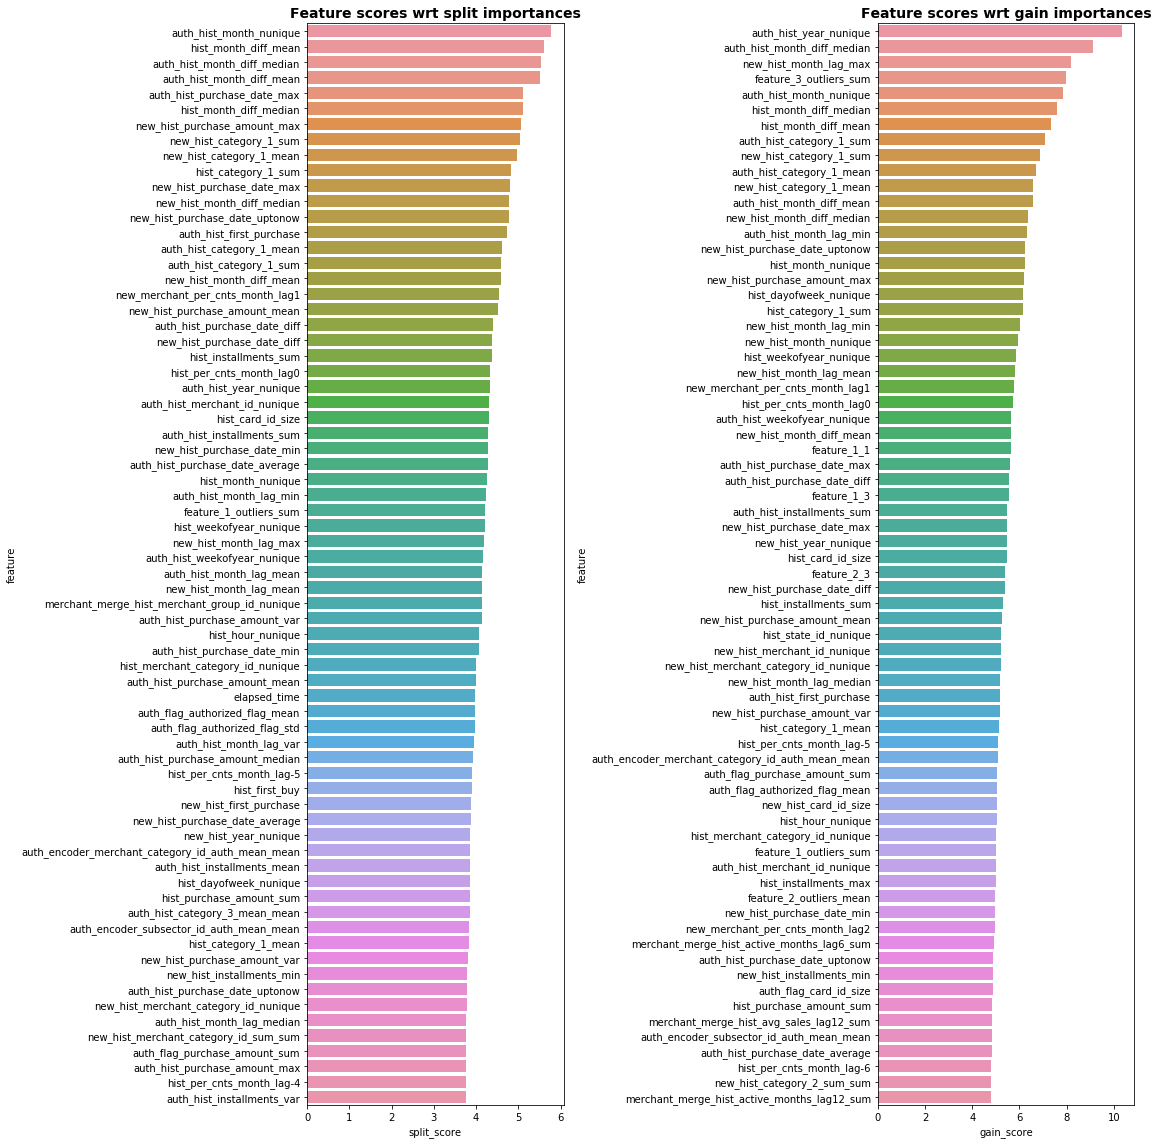

In [861]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

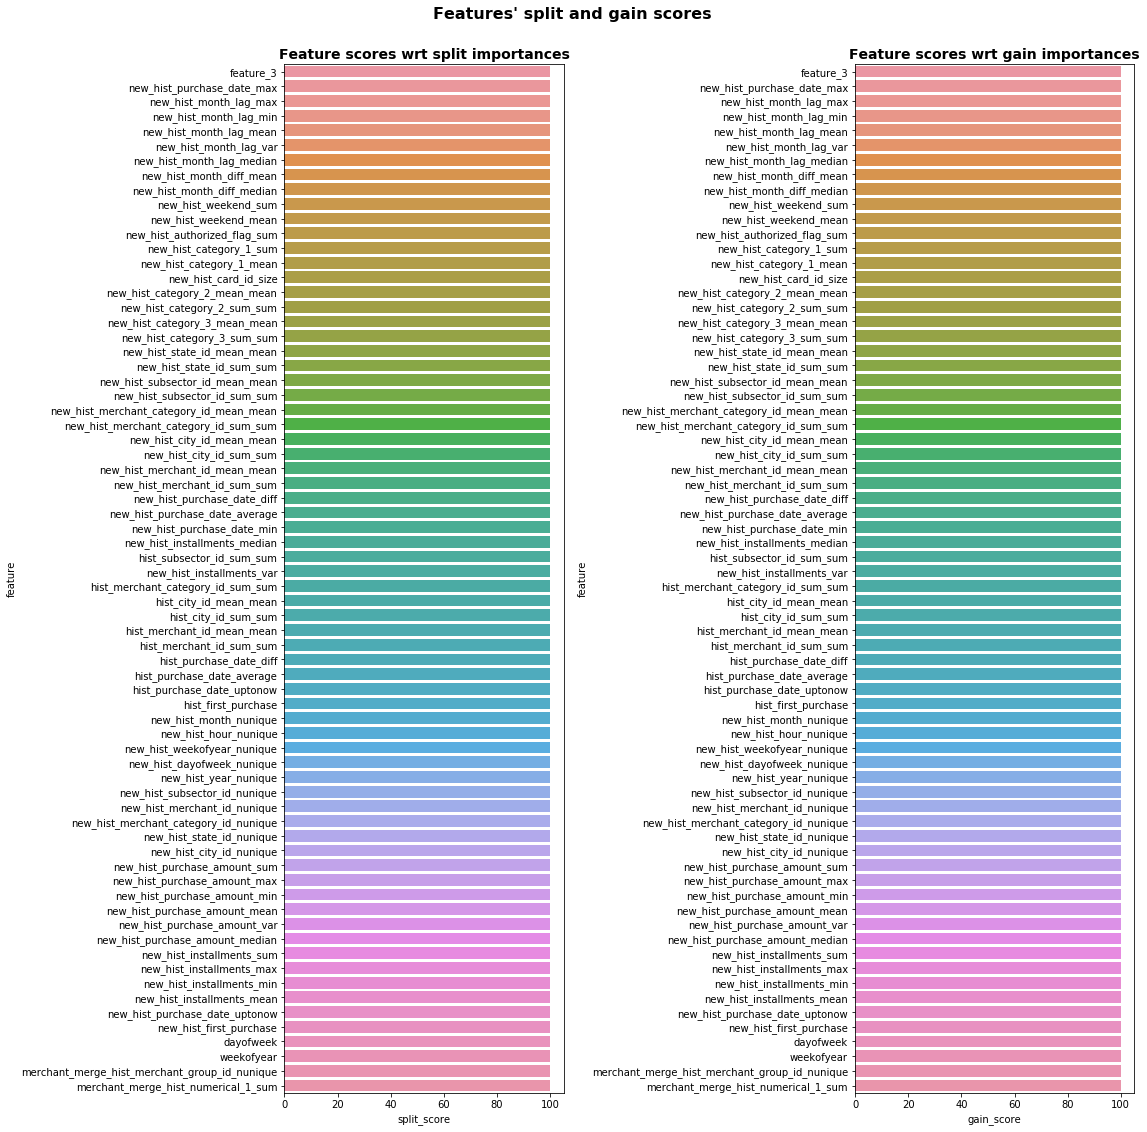

In [862]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [868]:
for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    print(len(gain_feats))  

265
262
262
262
262
262
262
262
262
261
261
261


### Feature importances are extremely small because of cross validation. For now let's use original code again

In [998]:
def get_feature_importances(data, shuffle,param,columns ,seed=None):
    # Gather real features
    #train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['target'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data.loc[:,columns], y, free_raw_data=False, silent=True)
    
    # Fit the model
    clf = lgb.train(params=param, train_set=dtrain, num_boost_round=200)

    #num_round = 1000
    #clf = lgb.train(lgb_params, dtrain, num_round, verbose_eval=100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    #clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(columns)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    #imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    imp_df['trn_score']=np.sqrt(mean_squared_error(y, clf.predict(data.loc[:,columns])))
    
    return imp_df

In [999]:
param_elim=param_opt.copy()
param_elim['nthread']=4
param_elim['device_type']='gpu'

In [1000]:
# Seed the unexpected randomness of this world
np.random.seed(4950)
# 
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=df_train, shuffle=False,param=param_elim,columns=df_train_columns_all)
# 

In [1001]:
actual_imp_df.sort_values('importance_split',ascending=False).head()


,feature,importance_gain,importance_split,trn_score
153,new_hist_purchase_amount_max,761185.018799,430,3.579102
197,new_hist_purchase_date_uptonow,781834.517960,275,3.579102
34,auth_hist_month_nunique,896424.046799,267,3.579102
63,auth_hist_month_diff_mean,859343.885483,244,3.579102
155,new_hist_purchase_amount_mean,220670.206726,241,3.579102


In [1002]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=df_train, shuffle=True,param=param_elim,columns=df_train_columns_all)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   80 of   80 (Spent  17.6 min)

In [1003]:
# Save importances just in case
null_imp_df.to_csv('null_importances_distribution_new_opt.csv')
actual_imp_df.to_csv('actual_importances_ditribution_new_opt.csv')

In [860]:
import matplotlib.gridspec as gridspec
import seaborn as sns

In [877]:
null_imp_df.groupby('feature').mean().sort_values('importance_split',ascending=False).head(10)

,importance_gain,importance_split,trn_score,run
feature,,,,
auth_hist_weekend_mean,17476.150371,90.6375,3.825112,40.5
coef,17310.233854,87.3125,3.825112,40.5
hist_merchant_category_id_mean_mean,16848.520161,83.4500,3.825112,40.5
new_hist_subsector_id_mean_mean,16399.319909,82.4500,3.825112,40.5
hist_merchant_id_sum_sum,15857.988077,82.3750,3.825112,40.5
hist_purchase_amount_min,15903.709669,79.1750,3.825112,40.5
hist_subsector_id_mean_mean,15248.940218,77.1375,3.825112,40.5
new_hist_merchant_id_sum_sum,15132.699108,77.1250,3.825112,40.5
new_hist_first_purchase,15035.811721,76.4250,3.825112,40.5


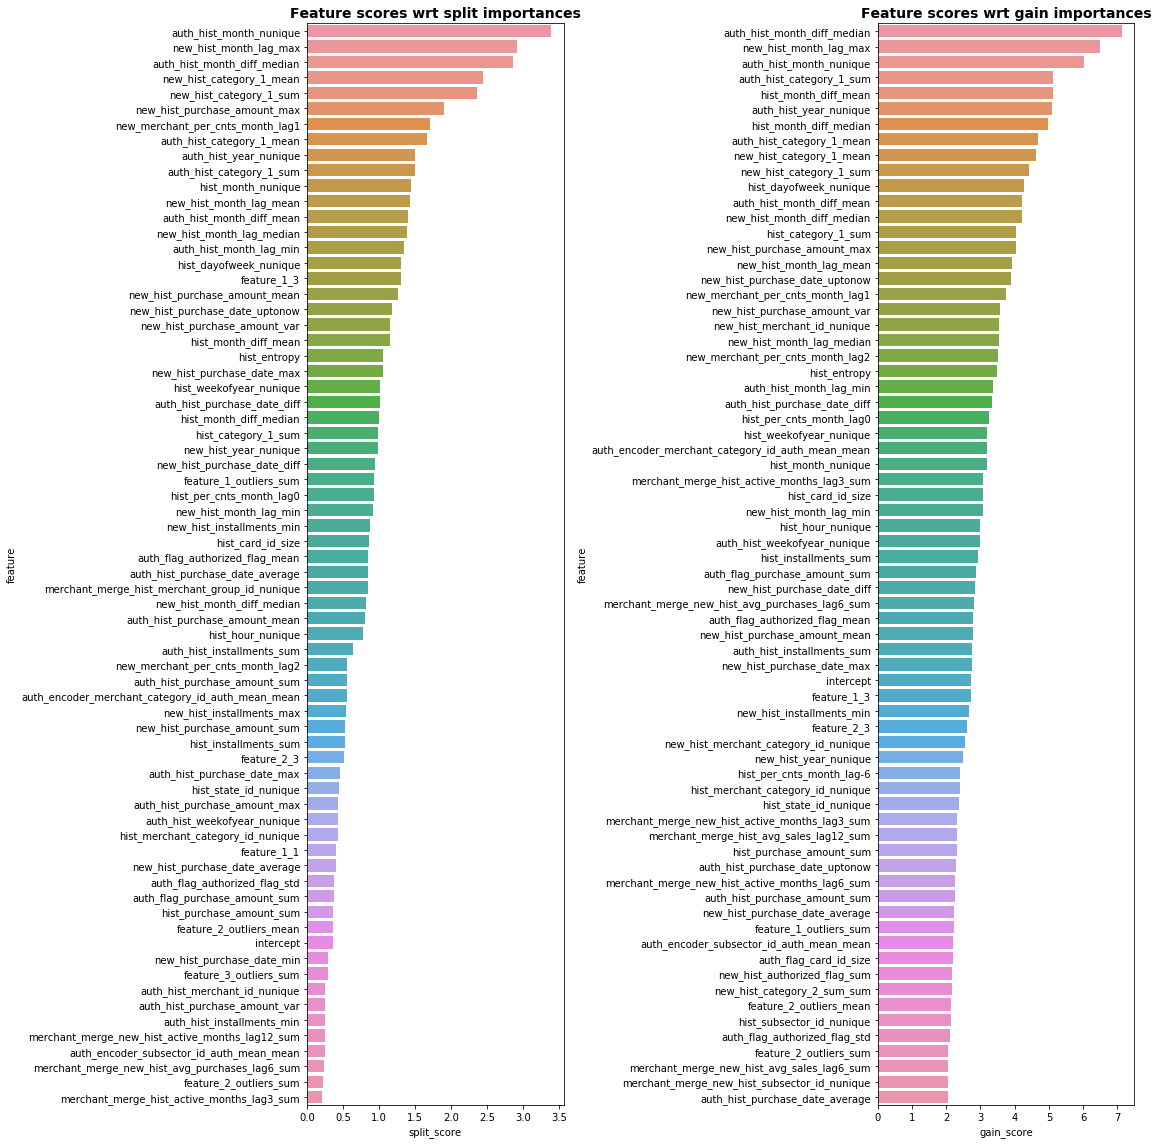

In [878]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

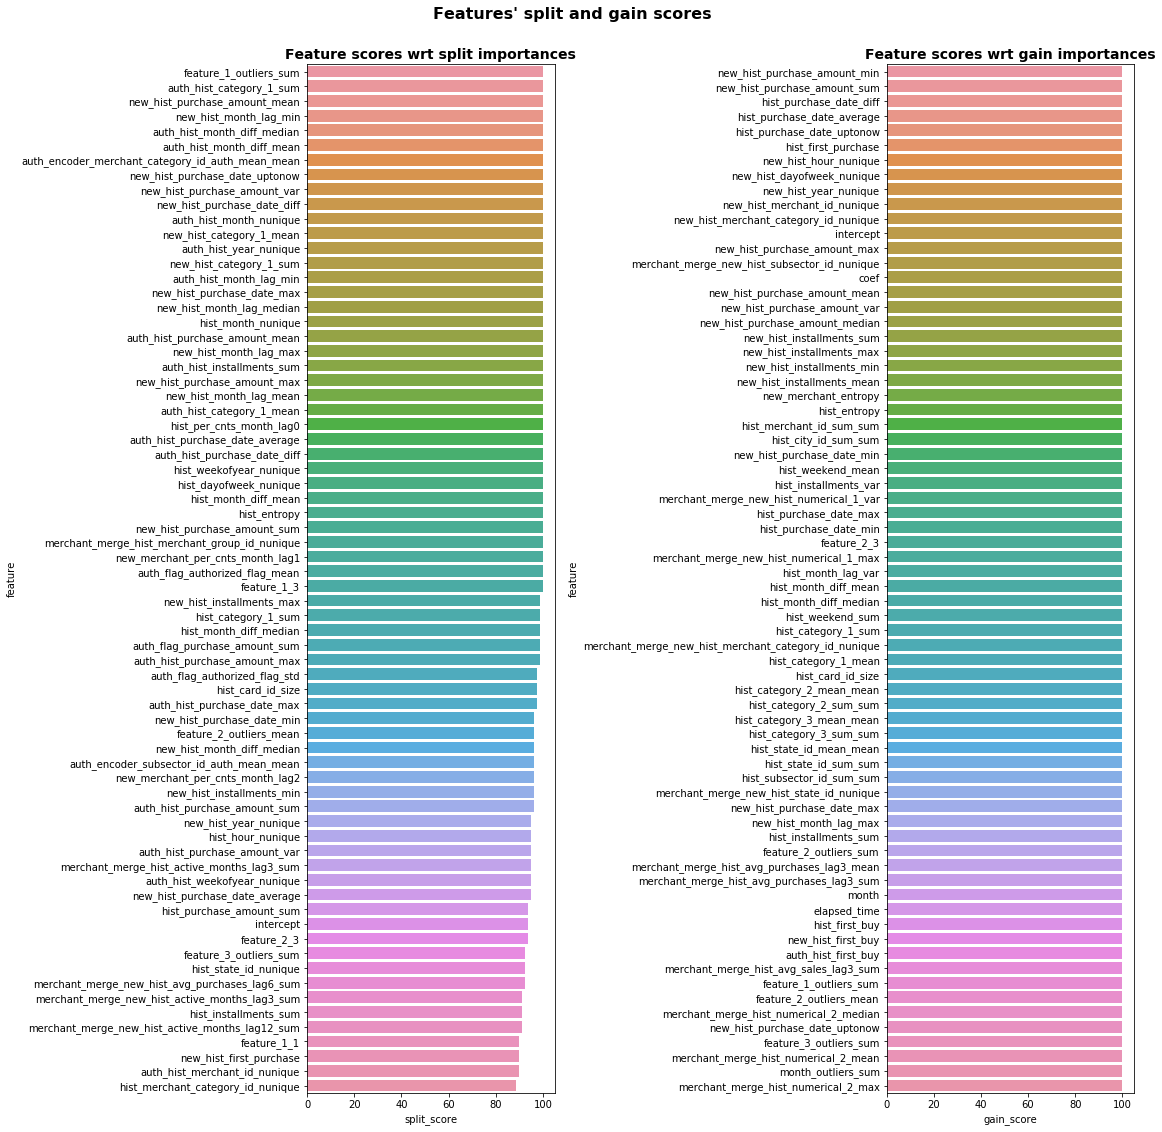

In [879]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [880]:
for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    print(len(split_feats))  

309
172
155
141
127
115
105
93
86
69
57
36


In [882]:
param_elim

{'bagging_fraction': 0.979,
 'bagging_freq': 1,
 'bagging_seed': 42,
 'boosting': 'gbdt',
 'device_type': 'gpu',
 'feature_fraction': 0.503,
 'lambda_l1': 3.96,
 'lambda_l2': 5.7,
 'learning_rate': 0.01,
 'max_depth': 7,
 'metric': 'rmse',
 'min_child_samples': 20,
 'min_data_in_leaf': 31,
 'nthread': 4,
 'num_leaves': 55,
 'objective': 'regression',
 'random_state': 4950,
 'verbosity': -1}

In [883]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None,param=param_elim):
    
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4950)
    oof = np.zeros(len(df))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df,df['outliers'].values)):
#    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx])
    
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],verbose_eval=0, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df.iloc[val_idx][train_features], num_iteration=clf.best_iteration)
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["Feature"] = train_features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        #predictions += clf.predict(df_test[train_features], num_iteration=clf.best_iteration) / folds.n_splits

    return np.sqrt(mean_squared_error(oof, target))

split_results_list=[]
gain_results_list=[]
for threshold in [ 0,10,20,30,40,50,60, 70,80, 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    #gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=df_train, train_features=split_feats, cat_feats=None, target=df_train['target'],param=param_elim)
    print('\t SPLIT : '+str(split_results))
    split_results_list.append(split_results)
#     gain_results = score_feature_selection(df=df_train, train_features=gain_feats, cat_feats=None, target=df_train['target'])
#     print('\t GAIN  : '+ str(gain_results))
#     gain_results_list.append(gain_results)

Results for threshold   0
	 SPLIT : 3.6425805865559058
Results for threshold  10
	 SPLIT : 3.639332308814726
Results for threshold  20
	 SPLIT : 3.6393659316023075
Results for threshold  30
	 SPLIT : 3.6394270563684477
Results for threshold  40
	 SPLIT : 3.6395035461240552
Results for threshold  50
	 SPLIT : 3.639842432290561
Results for threshold  60
	 SPLIT : 3.640392045302908
Results for threshold  70
	 SPLIT : 3.639799267468137
Results for threshold  80
	 SPLIT : 3.640627126178996
Results for threshold  90
	 SPLIT : 3.6396843927860503
Results for threshold  95
	 SPLIT : 3.640815284336549
Results for threshold  99
	 SPLIT : 3.6395481149895477


In [889]:
def score_feature_selection_test(df=None,df_test=None, train_features=None, cat_feats=None, target=None,param=param_elim):
    
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4950)
    oof = np.zeros(len(df))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df,df['outliers'].values)):
#    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx])
    
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],verbose_eval=0, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df.iloc[val_idx][train_features], num_iteration=clf.best_iteration)
    
        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = train_features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        predictions += clf.predict(df_test[train_features], num_iteration=clf.best_iteration) / folds.n_splits
    print(np.sqrt(mean_squared_error(oof, target)))

    return predictions,feature_importance_df

threshold=99
split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
predictions,feature_importance_df = score_feature_selection_test(df=df_train,df_test=df_test, train_features=split_feats, cat_feats=None, target=df_train['target'],param=param_elim)


3.6394067416233127


In [895]:
#LB:3.677
df=pd.DataFrame({'card_id':df_test.card_id,'target':predictions})
df.to_csv("feature_elimination_99.csv",index=False)

In [896]:
feature_importance_df.groupby('Feature').mean().sort_values('importance',ascending=False).head(10)

,importance,fold
Feature,,
auth_hist_month_diff_mean,3363.0,3
hist_month_diff_mean,2861.4,3
new_hist_purchase_date_uptonow,2638.6,3
auth_hist_purchase_amount_mean,2467.6,3
new_hist_purchase_date_max,2461.2,3
new_hist_purchase_amount_max,2436.2,3
auth_hist_purchase_date_diff,2141.0,3
hist_entropy,2053.6,3
auth_hist_purchase_date_average,2008.8,3


In [897]:
#LB:3.682
threshold=10
split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
predictions,feature_importance_df = score_feature_selection_test(df=df_train,df_test=df_test, train_features=split_feats, cat_feats=None, target=df_train['target'],param=param_elim)
df=pd.DataFrame({'card_id':df_test.card_id,'target':predictions})
df.to_csv("feature_elimination_10.csv",index=False)

3.639135470567087


In [898]:
#LB:3.683
threshold=0
split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
predictions,feature_importance_df = score_feature_selection_test(df=df_train,df_test=df_test, train_features=split_feats, cat_feats=None, target=df_train['target'],param=param_elim)
df=pd.DataFrame({'card_id':df_test.card_id,'target':predictions})
df.to_csv("feature_elimination_0.csv",index=False)

3.6425470641242983


In [899]:
#LB:3981
threshold=90
split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
predictions,feature_importance_df = score_feature_selection_test(df=df_train,df_test=df_test, train_features=split_feats, cat_feats=None, target=df_train['target'],param=param_elim)
df=pd.DataFrame({'card_id':df_test.card_id,'target':predictions})
df.to_csv("feature_elimination_90.csv",index=False)

3.6397988630252645


In [901]:
param_elim2=param_elim.copy()
del param_elim2['device_type']
param_elim2

{'bagging_fraction': 0.979,
 'bagging_freq': 1,
 'bagging_seed': 42,
 'boosting': 'gbdt',
 'feature_fraction': 0.503,
 'lambda_l1': 3.96,
 'lambda_l2': 5.7,
 'learning_rate': 0.01,
 'max_depth': 7,
 'metric': 'rmse',
 'min_child_samples': 20,
 'min_data_in_leaf': 31,
 'nthread': 4,
 'num_leaves': 55,
 'objective': 'regression',
 'random_state': 4950,
 'verbosity': -1}

In [902]:
# LB: 3.677
# Now let's train with cpu
param_elim2=param_elim.copy()
del param_elim2['device_type']
threshold=99
split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
predictions,feature_importance_df = score_feature_selection_test(df=df_train,df_test=df_test, train_features=split_feats, cat_feats=None, target=df_train['target'],param=param_elim2)


3.639223697164968


In [903]:
df=pd.DataFrame({'card_id':df_test.card_id,'target':predictions})
df.to_csv("feature_elimination_99_cpu.csv",index=False)

In [905]:
feature_importance_df.groupby('Feature').mean().sort_values('importance',ascending=False).head(10)

,importance,fold
Feature,,
auth_hist_month_diff_mean,3375.0,3
hist_month_diff_mean,2866.4,3
new_hist_purchase_date_uptonow,2627.2,3
auth_hist_purchase_amount_mean,2464.8,3
new_hist_purchase_date_max,2449.2,3
new_hist_purchase_amount_max,2435.6,3
auth_hist_purchase_date_diff,2126.4,3
hist_entropy,2037.8,3
auth_hist_purchase_date_average,2004.6,3


In [913]:
train_data=lgb.Dataset(df_train[split_feats],label=df_train.target)
lgb_cv=lgb.cv(param_elim2,train_data,10000,verbose_eval=200,early_stopping_rounds=400,stratified=False)

[200]	cv_agg's rmse: 3.66668 + 0.0284276
[400]	cv_agg's rmse: 3.64894 + 0.0268449
[600]	cv_agg's rmse: 3.64452 + 0.026654
[800]	cv_agg's rmse: 3.64317 + 0.026903
[1000]	cv_agg's rmse: 3.6429 + 0.0268956
[1200]	cv_agg's rmse: 3.64312 + 0.0266515


In [916]:
len(lgb_cv['rmse-mean']),min(lgb_cv['rmse-mean'])

(901, 3.642753769874806)

In [917]:
clf=lgb.train(param_elim2,train_data,len(lgb_cv['rmse-mean']),valid_sets=[train_data],verbose_eval=100)

[100]	training's rmse: 3.67247
[200]	training's rmse: 3.60729
[300]	training's rmse: 3.5729
[400]	training's rmse: 3.55035
[500]	training's rmse: 3.53317
[600]	training's rmse: 3.51759
[700]	training's rmse: 3.5017
[800]	training's rmse: 3.48883
[900]	training's rmse: 3.47575


In [918]:
predictions=clf.predict(df_test[split_feats],clf.best_iteration)
df=pd.DataFrame({'card_id':df_test.card_id,'target':predictions})
df.to_csv("feature_elimination_99_cpu_all_data.csv",index=False)

In [925]:
def score_feature_selection_shuffle(df=None,df_test=None, train_features=None, cat_feats=None, target=None,param=param_elim):
    
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4950)
    oof = np.zeros(len(df))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df,df['outliers'].values)):
#    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx])
    
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],verbose_eval=0, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df.iloc[val_idx][train_features], num_iteration=clf.best_iteration)
    
        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = train_features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        predictions += clf.predict(df_test[train_features], num_iteration=clf.best_iteration) / folds.n_splits
    print(np.sqrt(mean_squared_error(oof, target)))

    return predictions,feature_importance_df,oof,np.sqrt(mean_squared_error(oof, target))

In [928]:
# Shuffle features and predict
import random
random.seed(4950)
threshold=99
split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
split_feats_shuffle=split_feats[:]
predictions=pd.DataFrame()
feature_importance_df=[]
oof=pd.DataFrame()
error=[]
for i in range(20):
    predictions[i],f,oof[i],e = score_feature_selection_shuffle(df=df_train,df_test=df_test, train_features=split_feats, cat_feats=None, target=df_train['target'],param=param_elim)
    feature_importance_df.append(f)
    error.append(e)
    

    


3.6394114519267915
3.6394043658814246
3.6394688159169104
3.6394400383818835
3.6397861133224936
3.639509259407798
3.6397566785548943
3.639392447468145
3.639448519584973
3.6394351505391573
3.6397185998441945
3.639394573193005
3.6397106059308677
3.6397536717279144
3.639428153138931
3.6394370896131014
3.6395321781923315
3.6394970109662013
3.63937667484632
3.6393944004369607


In [958]:
predictions.mean(axis=1).values

array([-2.23578085, -0.34199046, -1.23559028, ...,  0.95312077,
       -4.91176766, -0.04880739])

In [959]:

df=pd.DataFrame({'card_id':df_test.card_id,'target':predictions.mean(axis=1).values})
df.to_csv("feature_elimination_99_20_shuffle.csv",index=False)

# Now let's try previous Wang's parameters

In [940]:
param_elim3=param.copy()
param_elim3['device']='gpu'
param_elim3['nthread']=4
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=df_train, shuffle=True,param=param_elim3,columns=df_train_columns_all)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   80 of   80 (Spent  17.0 min)

In [941]:
# Save importances just in case
null_imp_df.to_csv('null_importances_distribution_new_param.csv')
actual_imp_df.to_csv('actual_importances_ditribution_new_param.csv')

In [942]:
import matplotlib.gridspec as gridspec
import seaborn as sns

In [943]:
null_imp_df.groupby('feature').mean().sort_values('importance_split',ascending=False).head(10)

,importance_gain,importance_split,trn_score,run
feature,,,,
auth_hist_weekend_mean,20990.032844,60.0000,3.824051,40.5
hist_merchant_id_mean_mean,20528.631551,58.6750,3.824051,40.5
coef,19535.027944,55.8125,3.824051,40.5
new_hist_merchant_id_sum_sum,18623.651686,54.5750,3.824051,40.5
hist_merchant_category_id_mean_mean,19536.675852,54.2000,3.824051,40.5
auth_hist_purchase_amount_min,18040.211752,53.8250,3.824051,40.5
new_hist_purchase_amount_var,17784.048845,52.1875,3.824051,40.5
hist_city_id_mean_mean,17563.881502,51.9625,3.824051,40.5
new_hist_city_id_mean_mean,17846.755258,51.4750,3.824051,40.5


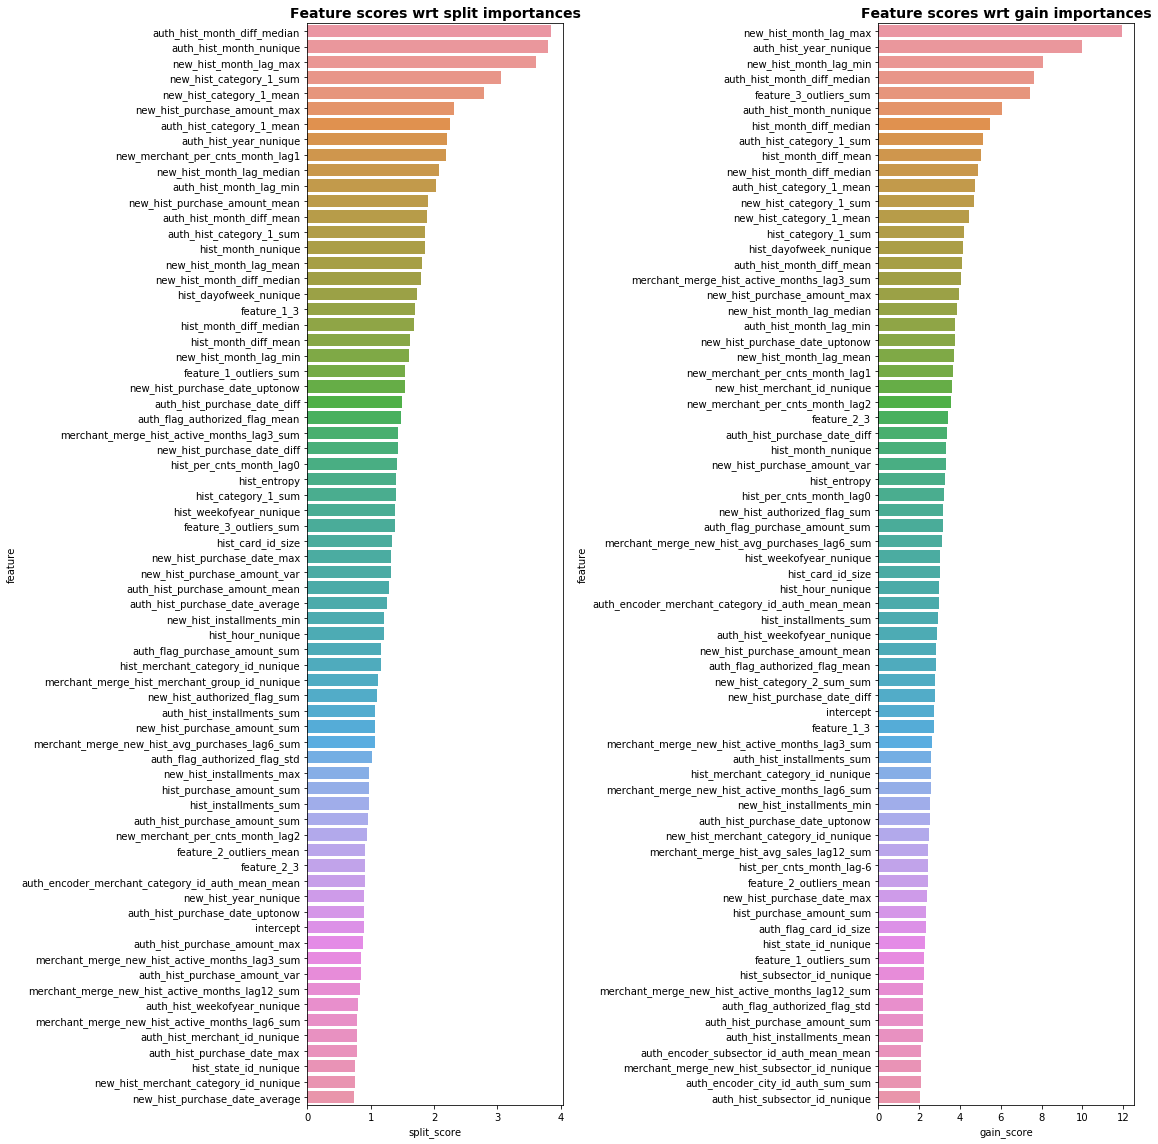

In [944]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

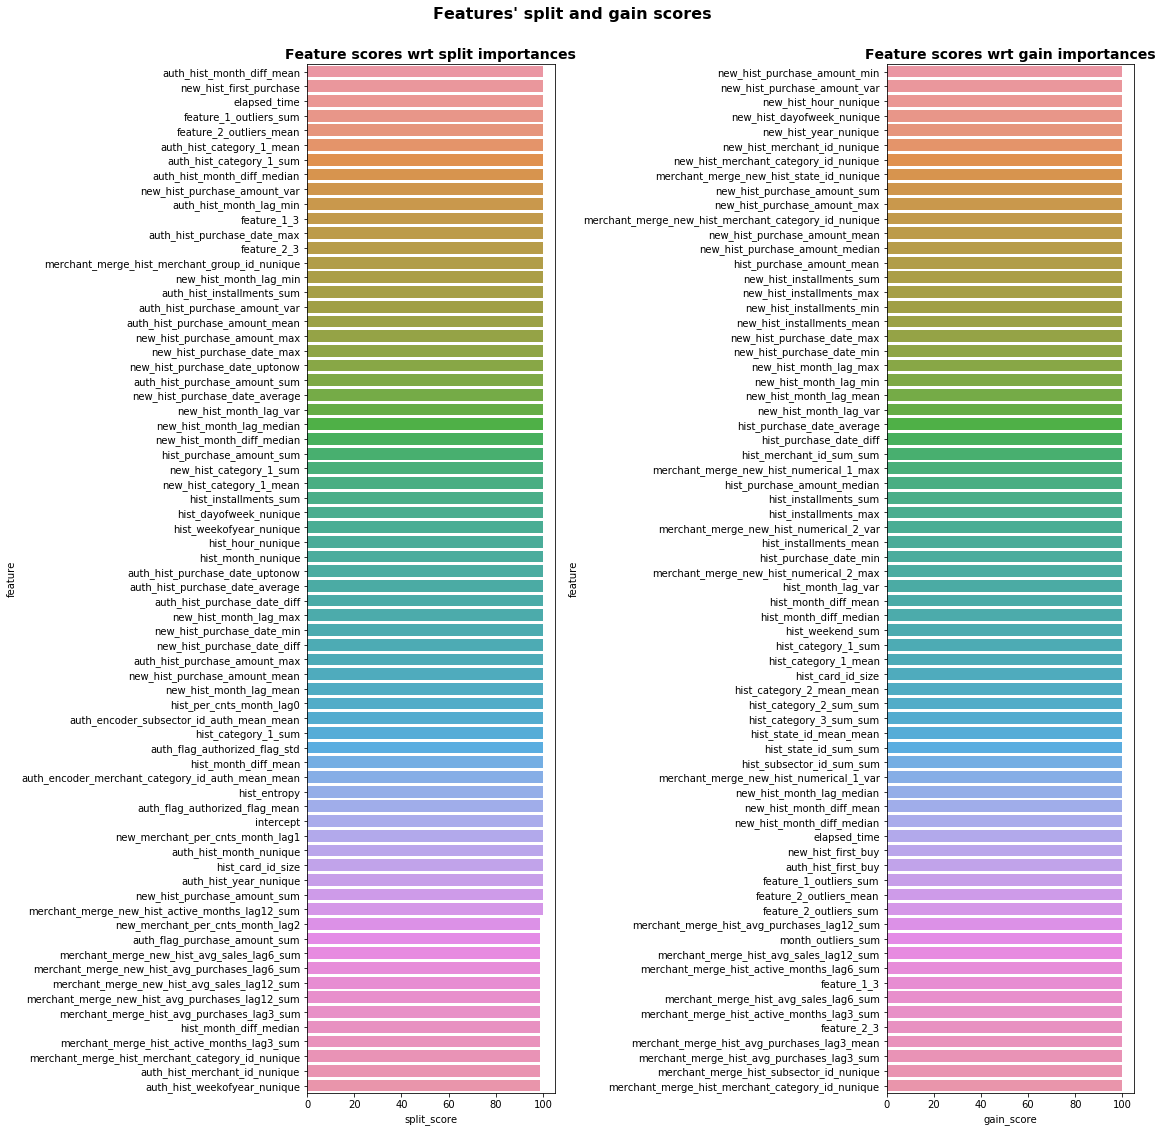

In [945]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [946]:
for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    print(len(split_feats))  

309
235
211
199
186
177
168
157
146
119
98
58


In [947]:

split_results_list=[]
gain_results_list=[]
for threshold in [ 0,10,20,30,40,50,60, 70,80, 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    #gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=df_train, train_features=split_feats, cat_feats=None, target=df_train['target'],param=param_elim3)
    print('\t SPLIT : '+str(split_results))
    split_results_list.append(split_results)
#     gain_results = score_feature_selection(df=df_train, train_features=gain_feats, cat_feats=None, target=df_train['target'])
#     print('\t GAIN  : '+ str(gain_results))
#     gain_results_list.append(gain_results)

Results for threshold   0
	 SPLIT : 3.6478590812435963
Results for threshold  10
	 SPLIT : 3.644168587048178
Results for threshold  20
	 SPLIT : 3.643975292649319
Results for threshold  30
	 SPLIT : 3.6434522966594107
Results for threshold  40
	 SPLIT : 3.6435333001708523
Results for threshold  50
	 SPLIT : 3.6426317678418796
Results for threshold  60
	 SPLIT : 3.6433645858902133
Results for threshold  70
	 SPLIT : 3.6422768866347286
Results for threshold  80
	 SPLIT : 3.6442656919961927
Results for threshold  90
	 SPLIT : 3.643827485022242
Results for threshold  95
	 SPLIT : 3.6450694426947012
Results for threshold  99
	 SPLIT : 3.6447728486616477


In [962]:
def score_feature_selection_test(df=None,df_test=None, train_features=None, cat_feats=None, target=None,param=param_elim):
    
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4950)
    oof = np.zeros(len(df))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df,df['outliers'].values)):
#    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx])
    
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],verbose_eval=0, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df.iloc[val_idx][train_features], num_iteration=clf.best_iteration)
    
        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = train_features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        predictions += clf.predict(df_test[train_features], num_iteration=clf.best_iteration) / folds.n_splits
    print(np.sqrt(mean_squared_error(oof, target)))

    return predictions,feature_importance_df

threshold=70
split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
predictions,feature_importance_df = score_feature_selection_test(df=df_train,df_test=df_test, train_features=split_feats, cat_feats=None, target=df_train['target'],param=param_elim3)


3.642527531715643


In [963]:
#LB:3.678
df=pd.DataFrame({'card_id':df_test.card_id,'target':predictions})
df.to_csv('threshold70_param.csv',index=False)

In [967]:
feature_importance_df.groupby("Feature").mean().sort_values('importance',ascending=False).head(20)

,importance,fold
Feature,,
auth_hist_month_diff_mean,1087.0,3
new_hist_purchase_date_uptonow,996.6,3
hist_month_diff_mean,954.6,3
new_hist_purchase_amount_max,926.6,3
auth_hist_purchase_date_max,732.8,3
hist_entropy,637.2,3
new_hist_purchase_date_max,560.0,3
auth_hist_purchase_date_min,554.2,3
hist_merchant_id_sum_sum,529.2,3


In [970]:
# Same features with optimized params (param_elim instead of param_elim3)
split_results_list=[]
gain_results_list=[]
for threshold in [ 0,10,20,30,40,50,60, 70,80, 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    #gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=df_train, train_features=split_feats, cat_feats=None, target=df_train['target'],param=param_elim)
    print('\t SPLIT : '+str(split_results))
    split_results_list.append(split_results)
#     gain_results = score_feature_selection(df=df_train, train_features=gain_feats, cat_feats=None, target=df_train['target'])
#     print('\t GAIN  : '+ str(gain_results))
#     gain_results_list.append(gain_results)

Results for threshold   0
	 SPLIT : 3.64288336514186
Results for threshold  10
	 SPLIT : 3.6410228737145935
Results for threshold  20
	 SPLIT : 3.640472999637692
Results for threshold  30
	 SPLIT : 3.64020730565695
Results for threshold  40
	 SPLIT : 3.639873508474063
Results for threshold  50
	 SPLIT : 3.6388107057349814
Results for threshold  60
	 SPLIT : 3.639718654634863
Results for threshold  70
	 SPLIT : 3.6391672683172147
Results for threshold  80
	 SPLIT : 3.639273090770866
Results for threshold  90
	 SPLIT : 3.6404241979066505
Results for threshold  95
	 SPLIT : 3.640055693867931
Results for threshold  99
	 SPLIT : 3.6420274680308506


In [977]:
# Let's pick 50 threshold and train with cpu
threshold=50
split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
predictions,feature_importance_df = score_feature_selection_test(df=df_train,df_test=df_test, train_features=split_feats, cat_feats=None, target=df_train['target'],param=param_elim2)


3.6388687091157026


In [980]:
#LB:3.682
df=pd.DataFrame({'card_id':df_test.card_id,'target':predictions})
df.to_csv('threshould_50_177_features.csv',index=False)

In [979]:
len(split_feats)

177

In [981]:
feature_importance_df.groupby('Feature').mean().sort_values('importance',ascending=False).head(20)

,importance,fold
Feature,,
auth_hist_month_diff_mean,1974.8,3
hist_month_diff_mean,1729.4,3
auth_hist_purchase_date_max,1488.0,3
new_hist_purchase_date_uptonow,1386.0,3
new_hist_purchase_amount_max,1322.2,3
new_hist_purchase_date_max,1279.8,3
hist_entropy,878.6,3
new_hist_purchase_amount_mean,801.2,3
auth_hist_purchase_date_min,760.8,3


# Let's do Bayesian optimization on 36 features. Let's use gpu to train. We also have less features to train,.
# Number of features significantly reduced

In [1028]:
def lgb_cv(num_leaves, min_data_in_leaf, bagging_fraction, feature_fraction, lambda_l1,lambda_l2,max_depth, data,features):
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4950)
    oof = np.zeros(data.shape[0])
    param = {
            # general parameters
            'objective': 'regression',
            'boosting': 'gbdt',
            'metric': 'rmse',
            'learning_rate': 0.01,
            # tuning parameters
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf),
            'bagging_freq': 1,
            'bagging_fraction': bagging_fraction,
            'feature_fraction': feature_fraction,
            'lambda_l1': lambda_l1,
            'lambda_l2': lambda_l2,
            'max_depth': int(max_depth),
            'device':'gpu'
        }
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(data, data.outliers)):
        #print(f'fold: {fold_}')
        trn_data = lgb.Dataset(data[features].iloc[trn_idx], label=data.target.iloc[trn_idx])
        val_data = lgb.Dataset(data[features].iloc[val_idx], label=data.target.iloc[val_idx])
        
        clf = lgb.train(param, trn_data, 10000, valid_sets=[trn_data, val_data], verbose_eval=False, early_stopping_rounds=400)
        oof[val_idx] = clf.predict(data[features].iloc[val_idx], num_iteration=clf.best_iteration)
        
        del clf, trn_idx, val_idx
        gc.collect()
    return -mean_squared_error(target, oof)**0.5

In [1029]:
def optimize_lgb(data,features):
    def lgb_crossval(num_leaves, min_data_in_leaf, bagging_fraction, feature_fraction, lambda_l1,lambda_l2,max_depth):
        return lgb_cv(num_leaves, min_data_in_leaf, bagging_fraction, feature_fraction, lambda_l1,lambda_l2,max_depth, data,features )
    
    optimizer = BayesianOptimization(lgb_crossval, {
        'num_leaves': (40, 60),
        'min_data_in_leaf': (30, 60),
        'bagging_fraction': (0.5, 1.0),
        'feature_fraction': (0.5, 1.0),
        'lambda_l1': (0, 10),
        'lambda_l2':(0,10),
        'max_depth':(2,20)
    })

    start_time = timer()
    optimizer.maximize(init_points=10, n_iter=200, acq='ucb', kappa=10)
    timer(start_time)
    print("Final result:", optimizer.max)

In [1030]:
# Save importances just in case
null_imp_df=pd.read_csv('null_importances_distribution_new_opt.csv')
actual_imp_df=pd.read_csv('actual_importances_ditribution_new_opt.csv')

In [1031]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])


In [1032]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

In [1033]:
for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    print(len(split_feats))  

309
169
153
139
128
115
101
90
83
70
59
37


In [1034]:
threshould=99
split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
train = df_train

#train = reduce_mem_usage(train)
optimize_lgb(train, split_feats)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------
|  1        | -3.645    |  0.8773   |  0.8752   |  2.427    |  5.775    |  13.42    |  49.77    |  41.68    |
|  2        | -3.644    |  0.8572   |  0.9756   |  0.2835   |  5.45     |  5.569    |  38.51    |  58.39    |
|  3        | -3.641    |  0.5943   |  0.9749   |  3.608    |  9.063    |  6.648    |  46.6     |  40.15    |
|  4        | -3.646    |  0.9977   |  0.8151   |  9.369    |  8.966    |  5.14     |  48.71    |  55.5     |
|  5        | -3.642    |  0.5327   |  0.6245   |  3.801    |  1.934    |  9.752    |  54.09    |  55.16    |
|  6        | -3.643    |  0.9086   |  0.5519   |  2.676    |  3.801    |  12.36    |  46.59    |  47.98    |
|  7        | -3.644    |  0.8751   |  0.7492   |  4.276    |  7.246    |  15.19    |  55.54    |  43.07    |
|  8      

|  45       | -3.644    |  0.993    |  0.5028   |  4.67     |  0.8734   |  12.59    |  31.2     |  59.55    |
|  46       | -3.643    |  0.5746   |  0.5541   |  0.3054   |  9.695    |  11.56    |  37.99    |  46.06    |
|  47       | -3.645    |  0.7369   |  0.8197   |  0.1239   |  0.001145 |  18.89    |  41.7     |  40.54    |
|  48       | -3.643    |  0.9147   |  0.9406   |  5.747    |  9.852    |  9.543    |  59.96    |  52.02    |
|  49       | -3.657    |  0.6261   |  0.752    |  0.005578 |  0.09374  |  3.966    |  41.02    |  59.91    |
|  50       | -3.643    |  0.5809   |  0.6075   |  9.605    |  0.06958  |  10.86    |  50.24    |  40.33    |
|  51       | -3.646    |  0.8449   |  0.9745   |  0.05388  |  0.3832   |  19.69    |  46.02    |  57.24    |
|  52       | -3.644    |  0.7046   |  0.8831   |  0.07503  |  0.3408   |  10.03    |  59.67    |  40.23    |
|  53       | -3.646    |  0.9286   |  0.9294   |  0.3071   |  0.6203   |  12.08    |  30.33    |  40.18    |
|  54     

|  91       | -3.643    |  0.9478   |  0.553    |  9.892    |  0.7582   |  11.63    |  30.36    |  59.4     |
|  92       | -3.642    |  0.5186   |  0.972    |  0.6277   |  0.1828   |  9.97     |  53.57    |  46.13    |
|  93       | -3.643    |  0.8324   |  0.6794   |  0.3576   |  9.867    |  10.04    |  35.77    |  59.86    |
|  94       | -3.643    |  0.5071   |  0.9198   |  9.853    |  9.868    |  15.17    |  59.25    |  50.28    |
|  95       | -3.644    |  0.9923   |  0.6058   |  9.851    |  0.03252  |  19.75    |  40.21    |  58.64    |
|  96       | -3.642    |  0.6544   |  0.553    |  6.092    |  9.387    |  14.71    |  59.9     |  59.87    |
|  97       | -3.645    |  0.7837   |  0.967    |  9.965    |  4.534    |  19.89    |  32.62    |  40.29    |
|  98       | -3.644    |  0.5567   |  0.865    |  0.2466   |  0.2126   |  12.26    |  59.9     |  50.6     |
|  99       | -3.643    |  0.5653   |  0.9351   |  9.797    |  9.778    |  13.45    |  36.79    |  40.25    |
|  100    

|  137      | -3.642    |  0.9276   |  0.5696   |  9.956    |  9.813    |  19.72    |  38.75    |  41.09    |
|  138      | -3.643    |  0.9844   |  0.8153   |  9.996    |  6.38     |  8.533    |  30.16    |  59.61    |
|  139      | -3.642    |  0.996    |  0.5034   |  5.121    |  4.194    |  8.849    |  44.2     |  54.96    |
|  140      | -3.645    |  0.5494   |  0.9461   |  0.1302   |  9.906    |  19.86    |  30.33    |  40.01    |
|  141      | -3.644    |  0.5809   |  0.9961   |  0.02293  |  0.1666   |  11.2     |  47.07    |  40.32    |
|  142      | -3.643    |  0.8465   |  0.9334   |  0.5677   |  9.656    |  10.18    |  55.3     |  59.92    |
|  143      | -3.642    |  0.8605   |  0.9847   |  9.982    |  0.05637  |  7.027    |  41.05    |  40.22    |
|  144      | -3.643    |  0.7538   |  0.9965   |  0.07795  |  9.838    |  9.264    |  41.46    |  40.42    |
|  145      | -3.643    |  0.8934   |  0.8087   |  9.875    |  9.961    |  12.45    |  51.82    |  40.02    |
|  146    

|  182      | -3.643    |  0.9652   |  0.5064   |  9.923    |  7.152    |  19.98    |  34.41    |  54.24    |
|  183      | -3.644    |  0.9591   |  0.7122   |  0.0507   |  4.4      |  14.48    |  58.89    |  40.24    |
|  184      | -3.643    |  0.6782   |  0.5386   |  0.7015   |  2.47     |  19.91    |  35.49    |  40.03    |
|  185      | -3.641    |  0.5187   |  0.9889   |  0.1447   |  5.143    |  6.539    |  54.35    |  52.31    |
|  186      | -3.643    |  0.7251   |  0.9305   |  9.964    |  0.2413   |  10.97    |  45.37    |  53.37    |
|  187      | -3.645    |  0.5453   |  0.6316   |  0.6261   |  1.713    |  19.93    |  30.04    |  40.24    |
|  188      | -3.642    |  0.5194   |  0.5754   |  9.915    |  5.931    |  9.357    |  55.19    |  43.69    |
|  189      | -3.643    |  0.8038   |  0.5527   |  4.858    |  9.287    |  19.85    |  57.43    |  53.33    |
|  190      | -3.642    |  0.9934   |  0.5814   |  5.098    |  9.959    |  9.3      |  48.89    |  55.98    |
|  191    

In [1064]:
i=0
for item in split_feats_shuffle:
    if item in split_feats:
        i+=1
    else:
        print(item)


hist_month_nunique
merchant_merge_hist_merchant_group_id_nunique


In [1065]:
i

34

In [1066]:
i=0
for item in split_feats:
    if item in split_feats_shuffle:
        i+=1
    else:
        print(item)

hist_category_1_sum
new_hist_month_diff_median
new_hist_purchase_date_average


In [1061]:
i

34

In [1053]:
df_features=pd.Series(split_feats_shuffle)
df_features.to_pickle('36features')

In [1067]:
a=set(split_feats)
b=set(split_feats_shuffle)
c=b.union(a)

In [1068]:
new_feature=list(c)

In [1069]:
len(new_feature)

39

In [1070]:
predictions,feature_importance_df = score_feature_selection_test(df=df_train,df_test=df_test, train_features=new_feature, cat_feats=None, target=df_train['target'],param=param_elim2)


3.639305982712369


## Let's do bayesian optimization on new_feature

In [1073]:
optimize_lgb(train, new_feature)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------
|  1        | -3.639    |  0.8781   |  0.5715   |  8.074    |  0.5564   |  6.637    |  54.72    |  57.08    |
|  2        | -3.641    |  0.9063   |  0.5739   |  8.822    |  4.709    |  17.33    |  45.64    |  46.48    |
|  3        | -3.643    |  0.9218   |  0.9453   |  9.657    |  4.978    |  18.36    |  39.75    |  40.6     |
|  4        | -3.642    |  0.9051   |  0.9552   |  7.549    |  0.7221   |  10.91    |  50.16    |  44.7     |
|  5        | -3.646    |  0.8122   |  0.721    |  3.49     |  9.952    |  4.578    |  31.97    |  47.25    |
|  6        | -3.642    |  0.6742   |  0.5622   |  3.79     |  8.814    |  18.53    |  35.71    |  53.66    |
|  7        | -3.645    |  0.9023   |  0.9774   |  9.739    |  0.07507  |  13.89    |  50.46    |  55.71    |
|  8      

|  45       | -3.642    |  0.691    |  0.5227   |  0.8022   |  0.1848   |  19.49    |  59.84    |  49.03    |
|  46       | -3.641    |  0.9831   |  0.6062   |  0.02045  |  6.343    |  8.942    |  46.64    |  50.02    |
|  47       | -3.64     |  0.5492   |  0.5051   |  9.795    |  1.106    |  6.946    |  39.36    |  52.96    |
|  48       | -3.64     |  0.5741   |  0.5087   |  9.965    |  6.5      |  10.88    |  58.53    |  59.99    |
|  49       | -3.642    |  0.6933   |  0.5407   |  0.5503   |  0.31     |  19.58    |  46.31    |  40.95    |
|  50       | -3.641    |  0.9655   |  0.5166   |  9.815    |  9.233    |  12.13    |  32.8     |  40.69    |
|  51       | -3.639    |  0.859    |  0.5494   |  9.937    |  9.985    |  19.28    |  58.66    |  57.69    |
|  52       | -3.64     |  0.6645   |  0.5194   |  0.5772   |  0.358    |  9.06     |  59.7     |  42.38    |
|  53       | -3.639    |  0.5397   |  0.5083   |  9.624    |  9.65     |  6.36     |  48.8     |  52.08    |
|  54     

|  90       | -3.642    |  0.5095   |  0.5598   |  0.3241   |  2.841    |  13.48    |  40.07    |  40.51    |
|  91       | -3.641    |  0.6324   |  0.5714   |  0.08057  |  0.03472  |  5.205    |  51.52    |  40.36    |
|  92       | -3.641    |  0.9506   |  0.5014   |  4.129    |  5.842    |  13.07    |  30.31    |  59.69    |
|  93       | -3.639    |  0.9456   |  0.5635   |  0.02655  |  9.597    |  10.8     |  59.38    |  59.23    |
|  94       | -3.642    |  0.8243   |  0.5859   |  0.2161   |  0.3915   |  12.43    |  45.9     |  59.86    |
|  95       | -3.644    |  0.619    |  0.9942   |  9.993    |  0.2359   |  18.64    |  30.2     |  51.77    |
|  96       | -3.638    |  0.963    |  0.5038   |  9.907    |  4.445    |  8.619    |  53.88    |  50.12    |
|  97       | -3.641    |  0.9444   |  0.5465   |  9.905    |  9.67     |  19.77    |  38.53    |  59.53    |
|  98       | -3.642    |  0.5651   |  0.8884   |  0.2704   |  9.95     |  19.59    |  30.3     |  40.41    |
|  99     

|  135      | -3.641    |  0.549    |  0.5343   |  7.065    |  9.617    |  11.2     |  59.57    |  59.72    |
|  136      | -3.641    |  0.9051   |  0.52     |  2.795    |  9.443    |  19.94    |  59.6     |  52.91    |
|  137      | -3.642    |  0.9031   |  0.9978   |  0.3218   |  6.863    |  9.279    |  30.47    |  45.17    |
|  138      | -3.642    |  0.9903   |  0.5889   |  0.5844   |  0.2398   |  12.75    |  51.1     |  40.04    |
|  139      | -3.639    |  0.6828   |  0.5065   |  6.037    |  3.377    |  7.741    |  46.1     |  55.25    |
|  140      | -3.642    |  0.9095   |  0.506    |  0.04719  |  0.1173   |  19.63    |  34.61    |  44.15    |
|  141      | -3.643    |  0.9268   |  0.747    |  0.03319  |  9.936    |  19.96    |  35.23    |  56.69    |
|  142      | -3.639    |  0.9159   |  0.5843   |  1.883    |  0.2234   |  7.873    |  59.74    |  59.99    |
|  143      | -3.641    |  0.5165   |  0.5379   |  9.871    |  8.896    |  11.55    |  59.62    |  45.99    |
|  144    

|  180      | -3.641    |  0.9018   |  0.5475   |  0.06383  |  0.0567   |  18.93    |  53.85    |  49.75    |
|  181      | -3.64     |  0.5664   |  0.5057   |  4.064    |  1.385    |  9.949    |  59.02    |  55.17    |
|  182      | -3.674    |  0.8972   |  0.5383   |  0.204    |  9.876    |  2.844    |  30.17    |  50.89    |
|  183      | -3.641    |  0.5107   |  0.5605   |  3.166    |  9.497    |  7.507    |  34.93    |  40.19    |
|  184      | -3.639    |  0.9587   |  0.5176   |  6.175    |  9.989    |  7.868    |  36.76    |  51.18    |
|  185      | -3.64     |  0.6314   |  0.9751   |  0.05194  |  0.02355  |  8.536    |  33.85    |  45.01    |
|  186      | -3.643    |  0.5155   |  0.8384   |  5.06     |  9.932    |  19.94    |  36.08    |  46.23    |
|  187      | -3.64     |  0.6313   |  0.594    |  0.4195   |  9.8      |  11.01    |  46.54    |  59.2     |
|  188      | -3.641    |  0.9508   |  0.5289   |  3.226    |  9.195    |  19.78    |  47.79    |  46.5     |
|  189    

Time taken: 6 hours 52 minutes and 58.66 seconds.
Final result: {'target': -3.6380826917563622, 'params': {'bagging_fraction': 0.9620990918388843, 'feature_fraction': 0.5022640863472714, 'lambda_l1': 9.122472590911775, 'lambda_l2': 7.86566220050512, 'max_depth': 8.50796913253709, 'min_data_in_leaf': 56.278140694838626, 'num_leaves': 56.09439970824988}}

In [1123]:
param_opt_new = {
            # general parameters
            'objective': 'regression',
            'boosting': 'gbdt',
            'metric': 'rmse',
            'learning_rate': 0.01,
            # tuning parameters
            'num_leaves': 56,
            'min_data_in_leaf': 56,
            'bagging_freq': 1,
            'bagging_fraction': 0.9620,
            'feature_fraction': 0.5022,
            'lambda_l1': 9.1224,
            'lambda_l2': 7.8656,
            'max_depth': 8,
        }

In [1124]:
predictions,feature_importance_df = score_feature_selection_test(df=df_train,df_test=df_test, train_features=new_feature, cat_feats=None, target=df_train['target'],param=param_opt_new)


3.6385232186385608


In [1132]:
#LB:3.679
df=pd.DataFrame({'card_id':df_test.card_id,'target':predictions})
df.to_csv('39_feature_bayes_opt.csv',index=False)

In [1138]:
predictions,feature_importance_df = score_feature_selection_test(df=df_train,df_test=df_test, train_features=split_feats_shuffle, cat_feats=None, target=df_train['target'],param=param_opt_new)


3.6390207888701243


In [1121]:
lgb_cv(num_leaves=56, min_data_in_leaf=56, bagging_fraction=0.962, feature_fraction=0.502, lambda_l1=9.122,lambda_l2=7.865,max_depth=8, data=df_train,features=new_feature)

-3.638315741926314

In [ ]:
param_opt_new

In [1097]:
# Let's add knn results and run the code.
df_knn_test=pd.read_pickle('test_target_500nearst_neighbor.pickle')
df_knn_train=pd.read_pickle('train_target_500nearst_neighbor.pickle')

In [1136]:
df_knn_test.head()

,500knn,card_id
0,-2.399711,C_ID_0ab67a22ab
1,-0.386445,C_ID_130fd0cbdd
2,0.178241,C_ID_b709037bc5
3,-0.152480,C_ID_d27d835a9f
4,-0.243303,C_ID_2b5e3df5c2


In [1137]:
#LB:3.846
df=pd.DataFrame()
df['card_id']=df_knn_test.card_id
df['target']=df_knn_test['500knn']
df.to_csv('500knn_submission.csv',index=False)


In [ ]:
df=pd.DataFrame({'card_id':df_test.card_id,})

In [1098]:
df_knn_test.columns=['500knn','card_id']
df_knn_train.columns=['500knn','card_id']

In [1101]:
df_train=df_train.merge(df_knn_train, on='card_id',how='left')
df_test=df_test.merge(df_knn_test, on='card_id',how='left')

In [1107]:
df_train_columns_knn=df_train_columns[:]
df_train_columns_knn.append('500knn')

In [1108]:
predictions,feature_importance_df = score_feature_selection_test(df=df_train,df_test=df_test, train_features=df_train_columns_knn, cat_feats=None, target=df_train['target'],param=param_elim2)



3.6437800393853967


In [1111]:
feature_importance_df.groupby('Feature').mean().sort_values('importance',ascending=False).head(10)

,importance,fold
Feature,,
500knn,2645.2,3
auth_hist_month_diff_mean,1306.8,3
new_hist_purchase_date_uptonow,1089.0,3
new_hist_purchase_amount_max,1085.6,3
hist_month_diff_mean,937.4,3
auth_hist_purchase_date_max,919.4,3
new_hist_purchase_date_max,794.4,3
new_hist_purchase_amount_mean,667.6,3
auth_hist_month_nunique,649.2,3


In [1113]:
new_feature_knn=new_feature[:]
new_feature_knn.append('500knn')
predictions,feature_importance_df = score_feature_selection_test(df=df_train,df_test=df_test, train_features=new_feature_knn, cat_feats=None, target=df_train['target'],param=param_elim2)


3.640745911004506


## Knn is LB score is really bad. Let's choose features with highest importance

In [1139]:
df_train_knn=df_train[split_feats_shuffle].copy()
df_test_knn=df_test[split_feats_shuffle].copy()

In [1141]:
df_test_knn.isnull().any()

hist_per_cnts_month_lag0                            False
new_merchant_per_cnts_month_lag1                     True
auth_flag_authorized_flag_mean                      False
auth_encoder_merchant_category_id_auth_mean_mean    False
auth_hist_month_nunique                             False
auth_hist_year_nunique                              False
auth_hist_purchase_amount_mean                      False
auth_hist_installments_sum                          False
auth_hist_month_lag_min                             False
auth_hist_month_diff_mean                           False
auth_hist_month_diff_median                         False
auth_hist_category_1_sum                            False
auth_hist_category_1_mean                           False
auth_hist_purchase_date_diff                        False
auth_hist_purchase_date_average                     False
hist_month_nunique                                   True
hist_weekofyear_nunique                              True
hist_dayofweek

In [1142]:
df_train_knn.fillna(0,inplace = True)
df_test_knn.fillna(0,inplace = True)

In [1143]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(df_train_knn)
X_test_minmax = min_max_scaler.fit_transform(df_test_knn)

In [1144]:
train = pd.DataFrame(X_train_minmax,columns = split_feats_shuffle)
train['card_id'] = df_train.card_id
train['target'] = df_train.target
test = pd.DataFrame(X_test_minmax,columns = split_feats_shuffle)
test['card_id'] = df_test.card_id
train.head()

,hist_per_cnts_month_lag0,new_merchant_per_cnts_month_lag1,auth_flag_authorized_flag_mean,auth_encoder_merchant_category_id_auth_mean_mean,auth_hist_month_nunique,auth_hist_year_nunique,auth_hist_purchase_amount_mean,auth_hist_installments_sum,auth_hist_month_lag_min,auth_hist_month_diff_mean,...,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_purchase_date_diff,new_hist_purchase_date_uptonow,feature_1_outliers_sum,feature_1_3,merchant_merge_hist_merchant_group_id_nunique,hist_entropy,card_id,target
0,0.028894,0.190476,0.948428,0.972955,0.7,1.0,0.002892,0.005435,0.416667,0.008720,...,0.0000,0.000000,0.885246,0.077348,0.648368,0.0,0.268657,0.760904,C_ID_92a2005557,-0.820283
1,0.064070,0.047619,0.967583,0.946396,1.0,1.0,0.003455,0.307971,0.083333,0.086453,...,0.0000,0.000000,0.918033,0.093923,0.172107,0.0,0.380597,0.926727,C_ID_3d0044924f,0.392913
2,0.001256,0.000000,0.952026,0.960104,0.8,1.0,0.001782,0.005435,0.000000,0.005629,...,0.0000,0.000000,0.000000,0.088398,0.734421,0.0,0.029851,0.860436,C_ID_d639edf6cd,0.688056
3,0.020101,0.031746,1.000000,0.933095,0.4,1.0,0.002744,0.056159,0.666667,0.001998,...,0.0625,0.142857,0.672131,0.118785,0.172107,0.0,0.141791,0.589074,C_ID_186d6a6901,0.142495
4,0.043970,0.253968,0.961224,0.956337,0.2,1.0,0.005509,0.092391,0.833333,0.004207,...,0.1250,0.055556,0.934426,0.091160,0.000000,0.0,0.190299,0.496529,C_ID_cdbd2c0db2,-0.159749


In [1147]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=50,n_jobs = 4)
knn.fit(train[split_feats_shuffle]) 

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=4, n_neighbors=50, p=2, radius=1.0)

In [1148]:
train_neigh = knn.kneighbors(train[split_feats_shuffle], return_distance=False) 
test_neigh = knn.kneighbors(test[split_feats_shuffle], return_distance=False) 
test_neigh[1000]

array([186416,  30067, 130684,  38791, 186544, 148969, 179801,  54343,
       195927, 174722, 128199,  96058, 131811, 105881,  75426, 127247,
       186086, 157207,  48949,  80913, 102365, 187968, 153907, 126090,
        89385,   5761,  52227,  11841,  24507, 194340,  28194,  30737,
        32080, 156005, 115580,  38818,  24309,  72305, 186768,   3100,
        44989,  74547,  64753,   7117,  88110,  27741,  48945, 196369,
       109624,  79253], dtype=int64)

In [1149]:
test_neigh.shape,train.iloc[0].target

((123623, 50), -0.8202826)

In [1150]:
train_target = np.zeros(len(df_train))

In [1151]:
for i in range(len(df_train)):
    cur = train_neigh[i]
    target_mean = 0
    for index in cur:
        target_mean += train.iloc[index].target
    train_target[i] = target_mean / len(cur)
    if i % 1000 == 0:
        print(i)
df_train_target = pd.DataFrame(train_target)
df_train_target['card_id'] = df_train.card_id

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [1152]:
test_target = np.zeros(len(df_test))
for i in range(len(df_test)):
    cur = test_neigh[i]
    target_mean = 0
    for index in cur:
        target_mean += train.iloc[index].target
    test_target[i] = target_mean / len(cur)
    if i % 1000 == 0:
        print(i)
df_test_target = pd.DataFrame(test_target)
df_test_target['card_id'] = df_test.card_id

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000


In [1153]:
train_target.shape,test_target.shape

((201917,), (123623,))

In [1155]:
# df_train_50_neastneighbor.columns = ['50nearstneighbor_36_feats','card_id']
# df_test_50_neastneighbor.columns = ['50nearstneighbor_36_feats','card_id']
df_train_target.to_pickle('train_target_50nearst_neighbor_36_feats.pickle')
df_test_target.to_pickle('test_target_50nearst_neighbor_36_feats.pickle')

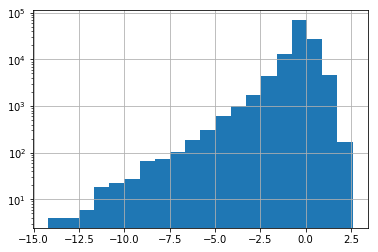

In [1159]:
plt.figure()
df_test_target[0].hist(bins=20)
plt.yscale('log')

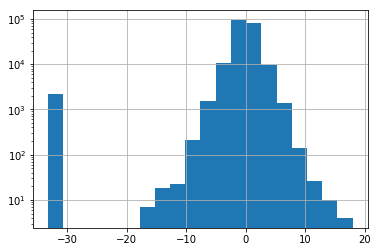

In [1161]:
plt.figure()
df_train.target.hist(bins=20)
plt.yscale('log')

In [1170]:
#LB:3.805 wow this is better than previous 500knn
df=pd.DataFrame()
df['card_id']=df_test.card_id
df['target']=df_test_target.iloc[:,0]
df.to_csv('50neighbors_36_feature.csv',index=False)

## Now,let's 500 nearest neighbors

In [1171]:
knn = NearestNeighbors(n_neighbors=500,n_jobs = 4)
knn.fit(train[split_feats_shuffle]) 

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=4, n_neighbors=500, p=2, radius=1.0)

In [1172]:
train_neigh = knn.kneighbors(train[split_feats_shuffle], return_distance=False) 
test_neigh = knn.kneighbors(test[split_feats_shuffle], return_distance=False) 
test_neigh[1000]

array([186416,  30067, 130684,  38791, 186544, 148969, 179801,  54343,
       195927, 174722, 128199,  96058, 131811, 105881,  75426, 127247,
       186086, 157207,  48949,  80913, 102365, 187968, 153907, 126090,
        89385,   5761,  52227,  11841,  24507, 194340,  28194,  30737,
        32080, 156005, 115580,  38818,  24309,  72305, 186768,   3100,
        44989,  74547,  64753,   7117,  88110,  27741,  48945, 196369,
       109624,  79253, 112904, 199488, 141790,  46458,  16830,  37732,
       142335,  54922, 175577, 155291,  82733, 146374,  39878,  37743,
       182418,  19916,  24887,  69438, 126424, 154091,  35628, 193267,
        18775, 127073,  41135, 200005,  21911, 103708,  70788, 111513,
        99876, 126073,  43325,  78673, 129632, 125536,  30653,  94671,
       103849,  46412, 162714,  98804,  34581,  36162,  54956,  99038,
        33264, 102652, 124462, 142675, 114076,  50772,  73345, 171161,
        16157, 143921, 100084,  67166, 195565, 144416,  49223, 162009,
      

In [1173]:
train_target = np.zeros(len(df_train))

In [1174]:
for i in range(len(df_train)):
    cur = train_neigh[i]
    target_mean = 0
    for index in cur:
        target_mean += train.iloc[index].target
    train_target[i] = target_mean / len(cur)
    if i % 1000 == 0:
        print(i)
df_train_target = pd.DataFrame(train_target)
df_train_target['card_id'] = df_train.card_id

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [1175]:
test_target = np.zeros(len(df_test))
for i in range(len(df_test)):
    cur = test_neigh[i]
    target_mean = 0
    for index in cur:
        target_mean += train.iloc[index].target
    test_target[i] = target_mean / len(cur)
    if i % 1000 == 0:
        print(i)
df_test_target = pd.DataFrame(test_target)
df_test_target['card_id'] = df_test.card_id

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000


In [1176]:
train_target.shape,test_target.shape

((201917,), (123623,))

In [1177]:
# df_train_50_neastneighbor.columns = ['50nearstneighbor_36_feats','card_id']
# df_test_50_neastneighbor.columns = ['50nearstneighbor_36_feats','card_id']
df_train_target.to_pickle('train_target_500nearst_neighbor_36_feats.pickle')
df_test_target.to_pickle('test_target_500nearst_neighbor_36_feats.pickle')